# Spherical Fourier Neural Operators

A simple notebook to showcase spherical Fourier Neural Operators


## Preparation

In [1]:
from functools import partial
import torch
import torch.nn as nn
from torch.utils.checkpoint import checkpoint
from dataclasses import dataclass
from typing import Any, Tuple
# import torch_harmonics as th
# import torch_harmonics.distributed as thd

# from torch_harmonics import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.fft
from torch.utils.checkpoint import checkpoint
from torch.cuda import amp
import math
from tqdm import tqdm



In [2]:
# # helpers
# from modulus.models.sfno.layers import trunc_normal_, DropPath, MLP

# # import global convolution and non-linear spectral layers
# from modulus.models.sfno.layers import SpectralAttention2d
# from modulus.models.sfno.s2convolutions import SpectralConvS2, SpectralAttentionS2

# # get spectral transforms from torch_harmonics
# import torch_harmonics as th
# import torch_harmonics.distributed as thd

# # wrap fft, to unify interface to spectral transforms
# from modulus.models.sfno.layers import RealFFT2
# from modulus.utils.sfno.distributed.layers import (
#     DistributedRealFFT2,
#     DistributedInverseRealFFT2,
#     DistributedMLP,
# )

# # more distributed stuff
# from modulus.utils.sfno.distributed import comm

# # layer normalization
# from apex.normalization import FusedLayerNorm
# from modulus.utils.sfno.distributed.layer_norm import DistributedInstanceNorm2d

# from modulus.models.module import Module
# from modulus.models.meta import ModelMetaData

In [3]:
# Copyright (c) 2023, NVIDIA CORPORATION & AFFILIATES. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from dataclasses import dataclass


@dataclass
class ModelMetaData:
    """Data class for storing essential meta data needed for all Modulus Models"""

    # Model info
    name: str = "ModulusModule"
    # Optimization
    jit: bool = False
    cuda_graphs: bool = False
    amp: bool = False
    amp_cpu: bool = None
    amp_gpu: bool = None
    torch_fx: bool = False
    # Inference
    onnx: bool = False
    onnx_gpu: bool = None
    onnx_cpu: bool = None
    onnx_runtime: bool = False
    trt: bool = False
    # Physics informed
    var_dim: int = -1
    func_torch: bool = False
    auto_grad: bool = False

    def __post_init__(self):
        self.amp_cpu = self.amp if self.amp_cpu is None else self.amp_cpu
        self.amp_gpu = self.amp if self.amp_gpu is None else self.amp_gpu
        self.onnx_cpu = self.onnx if self.onnx_cpu is None else self.onnx_cpu
        self.onnx_gpu = self.onnx if self.onnx_gpu is None else self.onnx_gpu

import torch
import logging

from typing import Union
from pathlib import Path


class Module(torch.nn.Module):
    """The base class for all network models in Modulus.

    This should be used as a direct replacement for torch.nn.module

    Parameters
    ----------
    meta : ModelMetaData, optional
        Meta data class for storing info regarding model, by default None
    """

    def __init__(self, meta: ModelMetaData = None):
        super().__init__()

        if not meta or not isinstance(meta, ModelMetaData):
            self.meta = ModelMetaData()
        else:
            self.meta = meta

        self.logger = logging.getLogger("core.module")
        handler = logging.StreamHandler()
        formatter = logging.Formatter(
            f"[%(asctime)s - %(levelname)s] %(message)s", datefmt="%H:%M:%S"
        )
        handler.setFormatter(formatter)
        self.logger.addHandler(handler)
        self.logger.setLevel(logging.WARNING)

        # dummy buffer for getting where the networks device
        self.register_buffer("device_buffer", torch.empty(0))

    def debug(self):
        """Turn on debug logging"""
        self.logger.handlers.clear()
        handler = logging.StreamHandler()
        formatter = logging.Formatter(
            f"[%(asctime)s - %(levelname)s - {self.meta.name}] %(message)s",
            datefmt="%Y-%m-%d %H:%M:%S",
        )
        handler.setFormatter(formatter)
        self.logger.addHandler(handler)
        self.logger.setLevel(logging.DEBUG)
        # TODO: set up debug log
        # fh = logging.FileHandler(f'modulus-core-{self.meta.name}.log')

    def save(self, file_name: Union[str, None] = None) -> None:
        """Simple utility for saving just the model

        Parameters
        ----------
        file_name : Union[str,None], optional
            File name to save model weight to. When none is provide it will default to
            the model's name set in the meta data, by default None

        Raises
        ------
        IOError
            If file_name provided has a parent path that does not exist
        """
        if file_name is None:
            file_name = self.meta.name + ".pt"

        file_name = Path(file_name)
        if not file_name.parents[0].is_dir():
            raise IOError(
                f"Model checkpoint parent directory {file_name.parents[0]} not found"
            )

        torch.save(self.state_dict(), str(file_name))

    def load(self, file_name: Union[str, None] = None) -> None:
        """Simple utility for loading the model from checkpoint

        Parameters
        ----------
        file_name : Union[str,None], optional
            Checkpoint file name. When none is provide it will default to the model's
            name set in the meta data, by default None

        Raises
        ------
        IOError
            If file_name provided does not exist
        """
        if file_name is None:
            file_name = self.meta.name + ".pt"

        file_name = Path(file_name)
        if not file_name.exists():
            raise IOError(f"Model checkpoint {file_name} not found")

        model_dict = torch.load(file_name, map_location=self.device)
        self.load_state_dict(model_dict)

    @property
    def device(self) -> torch.device:
        """Get device model is on

        Returns
        -------
        torch.device
            PyTorch device
        """
        return self.device_buffer.device

    def num_parameters(self) -> int:
        """Gets the number of learnable parameters"""
        count = 0
        for name, param in self.named_parameters():
            count += param.numel()
        return count

**!Contraction!**

In [4]:
import torch


@torch.jit.script
def compl_mul1d_fwd(
    a: torch.Tensor, b: torch.Tensor
) -> torch.Tensor:  # pragma: no cover
    """
    Performs a complex-valued multiplication operation between two 1-dimensional
    tensors.
    """
    ac = torch.view_as_complex(a)
    bc = torch.view_as_complex(b)
    resc = torch.einsum("bix,io->box", ac, bc)
    res = torch.view_as_real(resc)
    return res


@torch.jit.script
def compl_muladd1d_fwd(
    a: torch.Tensor, b: torch.Tensor, c: torch.Tensor
) -> torch.Tensor:  # pragma: no cover
    """
    Performs complex multiplication of two 1-dimensional tensors 'a' and 'b', and then
    adds a third tensor 'c'.
    """
    tmpcc = torch.view_as_complex(compl_mul1d_fwd(a, b))
    cc = torch.view_as_complex(c)
    return torch.view_as_real(tmpcc + cc)


@torch.jit.script
def compl_mul2d_fwd(
    a: torch.Tensor, b: torch.Tensor
) -> torch.Tensor:  # pragma: no cover
    """
    Performs a complex-valued multiplication operation between two 2-dimensional
    tensors.
    """
    ac = torch.view_as_complex(a)
    bc = torch.view_as_complex(b)
    resc = torch.einsum("bixy,io->boxy", ac, bc)
    res = torch.view_as_real(resc)
    return res


@torch.jit.script
def compl_muladd2d_fwd(
    a: torch.Tensor, b: torch.Tensor, c: torch.Tensor
) -> torch.Tensor:  # pragma: no cover
    """
    Performs complex multiplication of two 2-dimensional tensors 'a' and 'b', and then
    adds a third tensor 'c'.
    """
    tmpcc = torch.view_as_complex(compl_mul2d_fwd(a, b))
    cc = torch.view_as_complex(c)
    return torch.view_as_real(tmpcc + cc)


@torch.jit.script  # TODO remove
def _contract_localconv_fwd(
    a: torch.Tensor, b: torch.Tensor
) -> torch.Tensor:  # pragma: no cover
    """
    Performs a complex local convolution operation between two tensors 'a' and 'b'.
    """
    ac = torch.view_as_complex(a)
    bc = torch.view_as_complex(b)
    resc = torch.einsum("bixy,iox->boxy", ac, bc)
    res = torch.view_as_real(resc)
    return res


@torch.jit.script  # TODO remove
def _contract_blockconv_fwd(
    a: torch.Tensor, b: torch.Tensor
) -> torch.Tensor:  # pragma: no cover
    """
    Performs a complex block convolution operation between two tensors 'a' and 'b'.
    """
    ac = torch.view_as_complex(a)
    bc = torch.view_as_complex(b)
    resc = torch.einsum("bim,imn->bin", ac, bc)
    res = torch.view_as_real(resc)
    return res


@torch.jit.script  # TODO remove
def _contractadd_blockconv_fwd(
    a: torch.Tensor, b: torch.Tensor, c: torch.Tensor
) -> torch.Tensor:  # pragma: no cover
    """
    Performs a complex block convolution operation between two tensors 'a' and 'b', and
    then adds a third tensor 'c'.
    """
    tmpcc = torch.view_as_complex(_contract_blockconv_fwd(a, b))
    cc = torch.view_as_complex(c)
    return torch.view_as_real(tmpcc + cc)


# for the experimental layer
@torch.jit.script  # TODO remove
def compl_exp_mul2d_fwd(
    a: torch.Tensor, b: torch.Tensor
) -> torch.Tensor:  # pragma: no cover
    """
    Performs a 2D complex multiplication operation between two tensors 'a' and 'b'.
    """
    ac = torch.view_as_complex(a)
    bc = torch.view_as_complex(b)
    resc = torch.einsum("bixy,xio->boxy", ac, bc)
    res = torch.view_as_real(resc)
    return res


@torch.jit.script
def compl_exp_muladd2d_fwd(  # TODO remove
    a: torch.Tensor, b: torch.Tensor, c: torch.Tensor
) -> torch.Tensor:  # pragma: no cover
    """
    Performs a 2D complex multiplication operation between two tensors 'a' and 'b',
    and then adds a third tensor 'c'.
    """
    tmpcc = torch.view_as_complex(compl_exp_mul2d_fwd(a, b))
    cc = torch.view_as_complex(c)
    return torch.view_as_real(tmpcc + cc)


@torch.jit.script
def real_mul2d_fwd(
    a: torch.Tensor, b: torch.Tensor
) -> torch.Tensor:  # pragma: no cover
    """
    Performs a 2D real multiplication operation between two tensors 'a' and 'b'.
    """
    res = torch.einsum("bixy,io->boxy", a, b)
    return res


@torch.jit.script
def real_muladd2d_fwd(
    a: torch.Tensor, b: torch.Tensor, c: torch.Tensor
) -> torch.Tensor:  # pragma: no cover
    """
    Performs a 2D real multiplication operation between two tensors 'a' and 'b', and
    then adds a third tensor 'c'.
    """
    res = real_mul2d_fwd(a, b) + c
    return res


# new contractions set to replace older ones. We use complex
@torch.jit.script
def _contract_diagonal(
    a: torch.Tensor, b: torch.Tensor
) -> torch.Tensor:  # pragma: no cover
    """
    Performs a complex diagonal operation between two tensors 'a' and 'b'.
    """
    ac = torch.view_as_complex(a)
    bc = torch.view_as_complex(b)
    resc = torch.einsum("bixy,ioxy->boxy", ac, bc)
    res = torch.view_as_real(resc)
    return res


@torch.jit.script
def _contract_dhconv(
    a: torch.Tensor, b: torch.Tensor
) -> torch.Tensor:  # pragma: no cover
    """
    Performs a complex Driscoll-Healy style convolution operation between two tensors
    'a' and 'b'.
    """
    ac = torch.view_as_complex(a)
    bc = torch.view_as_complex(b)
    resc = torch.einsum("bixy,iox->boxy", ac, bc)
    res = torch.view_as_real(resc)
    return res


@torch.jit.script
def _contract_sep_diagonal(
    a: torch.Tensor, b: torch.Tensor
) -> torch.Tensor:  # pragma: no cover
    """
    Performs a complex convolution operation between two tensors 'a' and 'b'
    """
    ac = torch.view_as_complex(a)
    bc = torch.view_as_complex(b)
    resc = torch.einsum("bixy,ixy->boxy", ac, bc)
    res = torch.view_as_real(resc)
    return res


@torch.jit.script
def _contract_sep_dhconv(
    a: torch.Tensor, b: torch.Tensor
) -> torch.Tensor:  # pragma: no cover
    """
    Performs a complex convolution operation between two tensors 'a' and 'b'
    """
    ac = torch.view_as_complex(a)
    bc = torch.view_as_complex(b)
    resc = torch.einsum("bixy,ix->boxy", ac, bc)
    res = torch.view_as_real(resc)
    return res

**!Factorization!**

In [5]:
import torch

import tensorly as tl

tl.set_backend("pytorch")
# from tensorly.plugins import use_opt_einsum
# use_opt_einsum('optimal')

# from tltorch.factorized_tensors.core import FactorizedTensor

einsum_symbols = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"


def _contract_dense(
    x, weight, separable=False, operator_type="diagonal"
):  # pragma: no cover
    order = tl.ndim(x)
    # batch-size, in_channels, x, y...
    x_syms = list(einsum_symbols[:order])

    # in_channels, out_channels, x, y...
    weight_syms = list(x_syms[1:])  # no batch-size

    # batch-size, out_channels, x, y...
    if separable:
        out_syms = [x_syms[0]] + list(weight_syms)
    else:
        weight_syms.insert(1, einsum_symbols[order])  # outputs
        out_syms = list(weight_syms)
        out_syms[0] = x_syms[0]

    if operator_type == "diagonal":
        pass
    elif operator_type == "block-diagonal":
        weight_syms.insert(-1, einsum_symbols[order + 1])
        out_syms[-1] = weight_syms[-2]
    elif operator_type == "dhconv":
        weight_syms.pop()
    else:
        raise ValueError(f"Unkonw operator type {operator_type}")

    eq = "".join(x_syms) + "," + "".join(weight_syms) + "->" + "".join(out_syms)

    if not torch.is_tensor(weight):
        weight = weight.to_tensor()

    return tl.einsum(eq, x, weight)


def _contract_cp(
    x, cp_weight, separable=False, operator_type="diagonal"
):  # pragma: no cover
    order = tl.ndim(x)

    x_syms = str(einsum_symbols[:order])
    rank_sym = einsum_symbols[order]
    out_sym = einsum_symbols[order + 1]
    out_syms = list(x_syms)

    if separable:
        factor_syms = [einsum_symbols[1] + rank_sym]  # in only
    else:
        out_syms[1] = out_sym
        factor_syms = [einsum_symbols[1] + rank_sym, out_sym + rank_sym]  # in, out

    factor_syms += [xs + rank_sym for xs in x_syms[2:]]  # x, y, ...

    if operator_type == "diagonal":
        pass
    elif operator_type == "block-diagonal":
        out_syms[-1] = einsum_symbols[order + 2]
        factor_syms += [out_syms[-1] + rank_sym]
    elif operator_type == "dhconv":
        factor_syms.pop()
    else:
        raise ValueError(f"Unkonw operator type {operator_type}")

    eq = (
        x_syms + "," + rank_sym + "," + ",".join(factor_syms) + "->" + "".join(out_syms)
    )

    return tl.einsum(eq, x, cp_weight.weights, *cp_weight.factors)


def _contract_tucker(
    x, tucker_weight, separable=False, operator_type="diagonal"
):  # pragma: no cover
    order = tl.ndim(x)

    x_syms = str(einsum_symbols[:order])
    out_sym = einsum_symbols[order]
    out_syms = list(x_syms)
    if separable:
        core_syms = einsum_symbols[order + 1 : 2 * order]
        # factor_syms = [einsum_symbols[1]+core_syms[0]] #in only
        factor_syms = [xs + rs for (xs, rs) in zip(x_syms[1:], core_syms)]  # x, y, ...

    else:
        core_syms = einsum_symbols[order + 1 : 2 * order + 1]
        out_syms[1] = out_sym
        factor_syms = [
            einsum_symbols[1] + core_syms[0],
            out_sym + core_syms[1],
        ]  # out, in
        factor_syms += [
            xs + rs for (xs, rs) in zip(x_syms[2:], core_syms[2:])
        ]  # x, y, ...

    if operator_type == "diagonal":
        pass
    elif operator_type == "block-diagonal":
        raise NotImplementedError(
            f"Operator type {operator_type} not implemented for Tucker"
        )
    else:
        raise ValueError(f"Unkonw operator type {operator_type}")

    eq = (
        x_syms
        + ","
        + core_syms
        + ","
        + ",".join(factor_syms)
        + "->"
        + "".join(out_syms)
    )

    return tl.einsum(eq, x, tucker_weight.core, *tucker_weight.factors)


def _contract_tt(
    x, tt_weight, separable=False, operator_type="diagonal"
):  # pragma: no cover
    order = tl.ndim(x)

    x_syms = list(einsum_symbols[:order])
    weight_syms = list(x_syms[1:])  # no batch-size

    if not separable:
        weight_syms.insert(1, einsum_symbols[order])  # outputs
        out_syms = list(weight_syms)
        out_syms[0] = x_syms[0]
    else:
        out_syms = list(x_syms)

    if operator_type == "diagonal":
        pass
    elif operator_type == "block-diagonal":
        weight_syms.insert(-1, einsum_symbols[order + 1])
        out_syms[-1] = weight_syms[-2]
    elif operator_type == "dhconv":
        weight_syms.pop()
    else:
        raise ValueError(f"Unkonw operator type {operator_type}")

    rank_syms = list(einsum_symbols[order + 2 :])
    tt_syms = []
    for i, s in enumerate(weight_syms):
        tt_syms.append([rank_syms[i], s, rank_syms[i + 1]])
    eq = (
        "".join(x_syms)
        + ","
        + ",".join("".join(f) for f in tt_syms)
        + "->"
        + "".join(out_syms)
    )

    return tl.einsum(eq, x, *tt_weight.factors)


# jitted PyTorch contractions:
def _contract_dense_pytorch(
    x, weight, separable=False, operator_type="diagonal"
):  # pragma: no cover

    # to cheat the fused optimizers convert to real here
    x = torch.view_as_real(x)

    if separable:
        if operator_type == "diagonal":
            x = _contract_sep_diagonal(x, weight)
        elif operator_type == "dhconv":
            x = _contract_sep_dhconv(x, weight)
        else:
            raise ValueError(f"Unkonw operator type {operator_type}")
    else:
        if operator_type == "diagonal":
            x = _contract_diagonal(x, weight)
        elif operator_type == "dhconv":
            x = _contract_dhconv(x, weight)
        else:
            raise ValueError(f"Unkonw operator type {operator_type}")

    # to cheat the fused optimizers convert to real here
    x = torch.view_as_complex(x)
    return x


def get_contract_fun(
    weight, implementation="reconstructed", separable=False, operator_type="diagonal"
):  # pragma: no cover
    """Generic ND implementation of Fourier Spectral Conv contraction

    Parameters
    ----------
    weight : tensorly-torch's FactorizedTensor
    implementation : {'reconstructed', 'factorized'}, default is 'reconstructed'
        whether to reconstruct the weight and do a forward pass (reconstructed)
        or contract directly the factors of the factorized weight with the input
        (factorized)

    Returns
    -------
    function : (x, weight) -> x * weight in Fourier space
    """
    if implementation == "reconstructed":
        return _contract_dense
    elif implementation == "factorized":
        if torch.is_tensor(weight):
            return _contract_dense_pytorch
        elif isinstance(weight, FactorizedTensor):
            raise ValueError(f"tensorly not found")
        else:
            raise ValueError(
                f"Got unexpected weight type of class {weight.__class__.__name__}"
            )
    else:
        raise ValueError(
            f'Got {implementation=}, expected "reconstructed" or "factorized"'
        )

**!Activation!**

In [6]:
# Copyright (c) 2023, NVIDIA CORPORATION & AFFILIATES. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import torch
from torch import nn


class ComplexReLU(nn.Module):
    """
    Complex-valued variants of the ReLU activation function
    """

    def __init__(self, negative_slope=0.0, mode="real", bias_shape=None, scale=1.0):
        super(ComplexReLU, self).__init__()

        # store parameters
        self.mode = mode
        if self.mode in ["modulus", "halfplane"]:
            if bias_shape is not None:
                self.bias = nn.Parameter(
                    scale * torch.ones(bias_shape, dtype=torch.float32)
                )
            else:
                self.bias = nn.Parameter(scale * torch.ones((1), dtype=torch.float32))
        else:
            self.bias = 0

        self.negative_slope = negative_slope
        self.act = nn.LeakyReLU(negative_slope=negative_slope)

    def forward(self, z: torch.Tensor) -> torch.Tensor:

        if self.mode == "cartesian":
            zr = torch.view_as_real(z)
            za = self.act(zr)
            out = torch.view_as_complex(za)

        elif self.mode == "modulus":
            zabs = torch.sqrt(torch.square(z.real) + torch.square(z.imag))
            out = torch.where(zabs + self.bias > 0, (zabs + self.bias) * z / zabs, 0.0)
            # out = self.act(zabs - self.bias) * torch.exp(1.j * z.angle())

        elif self.mode == "halfplane":
            # bias is an angle parameter in this case
            modified_angle = torch.angle(z) - self.bias
            condition = torch.logical_and(
                (0.0 <= modified_angle), (modified_angle < torch.pi / 2.0)
            )
            out = torch.where(condition, z, self.negative_slope * z)

        elif self.mode == "real":
            zr = torch.view_as_real(z)
            outr = zr.clone()
            outr[..., 0] = self.act(zr[..., 0])
            out = torch.view_as_complex(outr)

        else:
            raise NotImplementedError

        return out


class ComplexActivation(nn.Module):
    """
    A module implementing complex-valued activation functions.
    The module supports different modes of operation, depending on how
    the complex numbers are treated for the activation function:
    - "cartesian": the activation function is applied separately to the
       real and imaginary parts of the complex input.
    - "modulus": the activation function is applied to the modulus of
       the complex input, after adding a learnable bias.
    - any other mode: the complex input is returned as-is (identity operation).
    """

    def __init__(self, activation, mode="cartesian", bias_shape=None):
        super(ComplexActivation, self).__init__()

        # store parameters
        self.mode = mode
        if self.mode == "modulus":
            if bias_shape is not None:
                self.bias = nn.Parameter(torch.zeros(bias_shape, dtype=torch.float32))
            else:
                self.bias = nn.Parameter(torch.zeros((1), dtype=torch.float32))
        else:
            bias = torch.zeros((1), dtype=torch.float32)
            self.register_buffer("bias", bias)

        # real valued activation
        self.act = activation

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        if self.mode == "cartesian":
            zr = torch.view_as_real(z)
            za = self.act(zr)
            out = torch.view_as_complex(za)
        elif self.mode == "modulus":
            zabs = torch.sqrt(torch.square(z.real) + torch.square(z.imag))
            out = self.act(zabs + self.bias) * torch.exp(1.0j * z.angle())
        else:
            # identity
            out = z

        return out

**!Initialization!**

In [7]:


import math
import torch
import warnings


def _no_grad_trunc_normal_(tensor, mean, std, a, b):
    # Cut & paste from PyTorch official master until it's in a few official releases - RW
    # Method based on https://people.sc.fsu.edu/~jburkardt/presentations/truncated_normal.pdf
    def norm_cdf(x):
        # Computes standard normal cumulative distribution function
        return (1.0 + math.erf(x / math.sqrt(2.0))) / 2.0

    if (mean < a - 2 * std) or (mean > b + 2 * std):
        warnings.warn(
            "mean is more than 2 std from [a, b] in nn.init.trunc_normal_. "
            "The distribution of values may be incorrect.",
            stacklevel=2,
        )

    with torch.no_grad():
        # Values are generated by using a truncated uniform distribution and
        # then using the inverse CDF for the normal distribution.
        # Get upper and lower cdf values
        l = norm_cdf((a - mean) / std)
        u = norm_cdf((b - mean) / std)

        # Uniformly fill tensor with values from [l, u], then translate to
        # [2l-1, 2u-1].
        tensor.uniform_(2 * l - 1, 2 * u - 1)

        # Use inverse cdf transform for normal distribution to get truncated
        # standard normal
        tensor.erfinv_()

        # Transform to proper mean, std
        tensor.mul_(std * math.sqrt(2.0))
        tensor.add_(mean)

        # Clamp to ensure it's in the proper range
        tensor.clamp_(min=a, max=b)
        return tensor


def trunc_normal_(tensor, mean=0.0, std=1.0, a=-2.0, b=2.0):
    r"""Fills the input Tensor with values drawn from a truncated
    normal distribution. The values are effectively drawn from the
    normal distribution :math:`\mathcal{N}(\text{mean}, \text{std}^2)`
    with values outside :math:`[a, b]` redrawn until they are within
    the bounds. The method used for generating the random values works
    best when :math:`a \leq \text{mean} \leq b`.
    Args:
    tensor: an n-dimensional `torch.Tensor`
    mean: the mean of the normal distribution
    std: the standard deviation of the normal distribution
    a: the minimum cutoff value
    b: the maximum cutoff value
    """
    return _no_grad_trunc_normal_(tensor, mean, std, a, b)

**!Layers!**

In [8]:



@torch.jit.script
def drop_path(
    x: torch.Tensor, drop_prob: float = 0.0, training: bool = False
) -> torch.Tensor:  # pragma: no cover
    """Drop paths (Stochastic Depth) per sample (when applied in main path of
    residual blocks).
    This is the same as the DropConnect impl for EfficientNet, etc networks, however,
    the original name is misleading as 'Drop Connect' is a different form of dropout in
    a separate paper. See discussion:
        https://github.com/tensorflow/tpu/issues/494#issuecomment-532968956
    We've opted for changing the layer and argument names to 'drop path' rather than
    mix DropConnect as a layer name and use 'survival rate' as the argument.
    """
    if drop_prob == 0.0 or not training:
        return x
    keep_prob = 1.0 - drop_prob
    shape = (x.shape[0],) + (1,) * (
        x.ndim - 1
    )  # work with diff dim tensors, not just 2d ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output


class DropPath(nn.Module):
    """
    Drop paths (Stochastic Depth) per sample (when applied in main path of residual
    blocks).
    """

    def __init__(self, drop_prob=None):  # pragma: no cover
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):  # pragma: no cover
        return drop_path(x, self.drop_prob, self.training)


class PatchEmbed(nn.Module):
    """
    Divides the input image into patches and embeds them into a specified dimension
    using a convolutional layer.
    """

    def __init__(
        self, img_size=(224, 224), patch_size=(16, 16), in_chans=3, embed_dim=768
    ):  # pragma: no cover
        super(PatchEmbed, self).__init__()
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.proj = nn.Conv2d(
            in_chans, embed_dim, kernel_size=patch_size, stride=patch_size
        )

    def forward(self, x):  # pragma: no cover
        # gather input
        B, C, H, W = x.shape
        assert (
            H == self.img_size[0] and W == self.img_size[1]
        ), f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        # new: B, C, H*W
        x = self.proj(x).flatten(2)
        return x


class MLP(nn.Module):
    """
    Basic CNN with support for gradient checkpointing
    """

    def __init__(
        self,
        in_features,
        hidden_features=None,
        out_features=None,
        act_layer=nn.GELU,
        output_bias=True,
        drop_rate=0.0,
        checkpointing=0,
    ):  # pragma: no cover
        super(MLP, self).__init__()
        self.checkpointing = checkpointing
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features

        fc1 = nn.Conv2d(in_features, hidden_features, 1, bias=True)
        act = act_layer()
        fc2 = nn.Conv2d(hidden_features, out_features, 1, bias=output_bias)
        if drop_rate > 0.0:
            drop = nn.Dropout(drop_rate)
            self.fwd = nn.Sequential(fc1, act, drop, fc2, drop)
        else:
            self.fwd = nn.Sequential(fc1, act, fc2)

        # by default, all weights are shared

    @torch.jit.ignore
    def checkpoint_forward(self, x):  # pragma: no cover
        """Forward method with support for gradient checkpointing"""
        return checkpoint(self.fwd, x)

    def forward(self, x):  # pragma: no cover
        if self.checkpointing >= 2:
            return self.checkpoint_forward(x)
        else:
            return self.fwd(x)


class RealFFT2(nn.Module):
    """
    Helper routine to wrap FFT similarly to the SHT
    """

    def __init__(self, nlat, nlon, lmax=None, mmax=None):  # pragma: no cover
        super(RealFFT2, self).__init__()

        # use local FFT here
        self.fft_handle = torch.fft.rfft2

        self.nlat = nlat
        self.nlon = nlon
        self.lmax = lmax or self.nlat
        self.mmax = mmax or self.nlon // 2 + 1

        self.truncate = True
        if (self.lmax == self.nlat) and (self.mmax == (self.nlon // 2 + 1)):
            self.truncate = False

        # self.num_batches = 1
        assert self.lmax % 2 == 0

    def forward(self, x):  # pragma: no cover
        y = self.fft_handle(x, (self.nlat, self.nlon), (-2, -1), "ortho")

        if self.truncate:
            y = torch.cat(
                (
                    y[..., : math.ceil(self.lmax / 2), : self.mmax],
                    y[..., -math.floor(self.lmax / 2) :, : self.mmax],
                ),
                dim=-2,
            )

        return y


class InverseRealFFT2(nn.Module):
    """
    Helper routine to wrap FFT similarly to the SHT
    """

    def __init__(self, nlat, nlon, lmax=None, mmax=None):  # pragma: no cover
        super(InverseRealFFT2, self).__init__()

        # use local FFT here
        self.ifft_handle = torch.fft.irfft2

        self.nlat = nlat
        self.nlon = nlon
        self.lmax = lmax or self.nlat
        self.mmax = mmax or self.nlon // 2 + 1

    def forward(self, x):  # pragma: no cover
        out = self.ifft_handle(x, (self.nlat, self.nlon), (-2, -1), "ortho")

        return out


# class SpectralConv2d(nn.Module):
#     """
#     Spectral Convolution as utilized in
#     """

#     def __init__(
#         self,
#         forward_transform,
#         inverse_transform,
#         hidden_size,
#         sparsity_threshold=0.0,
#         hard_thresholding_fraction=1,
#         use_complex_kernels=False,
#         compression=None,
#         rank=0,
#         bias=False,
#     ):  # pragma: no cover
#         super(SpectralConv2d, self).__init__()

#         self.hidden_size = hidden_size
#         self.sparsity_threshold = sparsity_threshold
#         self.hard_thresholding_fraction = hard_thresholding_fraction
#         self.scale = 1 / hidden_size**2
#         self.contract_handle = (
#             compl_contract2d_fwd_c if use_complex_kernels else compl_contract2d_fwd
#         )

#         self.forward_transform = forward_transform
#         self.inverse_transform = inverse_transform

#         self.output_dims = (self.inverse_transform.nlat, self.inverse_transform.nlon)
#         modes_lat = self.inverse_transform.lmax
#         modes_lon = self.inverse_transform.mmax
#         self.modes_lat = int(modes_lat * self.hard_thresholding_fraction)
#         self.modes_lon = int(modes_lon * self.hard_thresholding_fraction)

#         # new simple linear layer
#         self.w = nn.Parameter(
#             self.scale
#             * torch.randn(
#                 self.hidden_size, self.hidden_size, self.modes_lat, self.modes_lon, 2
#             )
#         )
#         # optional bias
#         if bias:
#             self.b = nn.Parameter(
#                 self.scale * torch.randn(1, self.hidden_size, *self.output_dims)
#             )

#     def forward(self, x):  # pragma: no cover

#         dtype = x.dtype
#         # x = x.float()
#         B, C, H, W = x.shape

#         with amp.autocast(enabled=False):
#             x = x.to(torch.float32)
#             x = self.forward_transform(x)
#             x = torch.view_as_real(x)
#             x = x.to(dtype)

#         # do spectral conv
#         modes = torch.zeros(x.shape, device=x.device)

#         # modes[:, :, :self.modes_lat,  :self.modes_lon, :] = self.contract_handle(x[:, :, :self.modes_lat,  :self.modes_lon, :], self.wh)
#         # modes[:, :, -self.modes_lat:, :self.modes_lon, :] = self.contract_handle(x[:, :, -self.modes_lat:, :self.modes_lon, :], self.wl)
#         modes = self.contract_handle(x, self.w)

#         # finalize
#         x = F.softshrink(modes, lambd=self.sparsity_threshold)
#         x = torch.view_as_complex(x)

#         with amp.autocast(enabled=False):
#             x = x.to(torch.float32)
#             x = torch.view_as_complex(x)
#             x = x.contiguous()
#             x = self.inverse_transform(x)
#             x = x.to(dtype)

#         if hasattr(self, "b"):
#             x = x + self.b

#         return x


# class SpectralConvS2(nn.Module):
#     """
#     Spectral Convolution as utilized in
#     """

#     def __init__(
#         self,
#         forward_transform,
#         inverse_transform,
#         hidden_size,
#         sparsity_threshold=0.0,
#         use_complex_kernels=False,
#         compression=None,
#         rank=128,
#         bias=False,
#     ):  # pragma: no cover
#         super(SpectralConvS2, self).__init__()

#         self.hidden_size = hidden_size
#         self.sparsity_threshold = sparsity_threshold
#         self.scale = 0.02

#         self.forward_transform = forward_transform
#         self.inverse_transform = inverse_transform

#         self.modes_lat = self.forward_transform.lmax
#         self.modes_lon = self.forward_transform.mmax

#         assert self.inverse_transform.lmax == self.modes_lat
#         assert self.inverse_transform.mmax == self.modes_lon

#         # remember the lower triangular indices
#         ii, jj = torch.tril_indices(self.modes_lat, self.modes_lon)
#         self.register_buffer("ii", ii)
#         self.register_buffer("jj", jj)

#         if compression == "tt":
#             self.rank = rank
#             # tensortrain coefficients
#             g1 = nn.Parameter(self.scale * torch.randn(self.hidden_size, self.rank, 2))
#             g2 = nn.Parameter(
#                 self.scale * torch.randn(self.rank, self.hidden_size, self.rank, 2)
#             )
#             g3 = nn.Parameter(self.scale * torch.randn(self.rank, len(ii), 2))
#             self.w = nn.ParameterList([g1, g2, g3])

#             self.contract_handle = (
#                 contract_tt  # if use_complex_kernels else raise(NotImplementedError)
#             )
#         else:
#             self.w = nn.Parameter(
#                 self.scale * torch.randn(self.hidden_size, self.hidden_size, len(ii), 2)
#             )
#             self.contract_handle = (
#                 compl_contract_fwd_c if use_complex_kernels else compl_contract_fwd
#             )

#         if bias:
#             self.b = nn.Parameter(
#                 self.scale * torch.randn(1, self.hidden_size, *self.output_dims)
#             )

#     def forward(self, x):  # pragma: no cover
#         dtype = x.dtype
#         # x = x.float()
#         B, C, H, W = x.shape

#         with amp.autocast(enabled=False):
#             x = x.to(torch.float32)
#             x = x.contiguous()
#             x = self.forward_transform(x)
#             x = torch.view_as_real(x)
#             x = x.to(dtype)

#         # do spectral conv
#         modes = torch.zeros(x.shape, device=x.device)
#         modes[:, :, self.ii, self.jj, :] = self.contract_handle(
#             x[:, :, self.ii, self.jj, :], self.w
#         )

#         # finalize
#         x = F.softshrink(modes, lambd=self.sparsity_threshold)

#         with amp.autocast(enabled=False):
#             x = x.to(torch.float32)
#             x = torch.view_as_complex(x)
#             x = self.inverse_transform(x)
#             x = x.to(dtype)

#         if hasattr(self, "b"):
#             x = x + self.b

#         return x


# class SpectralAttention2d(nn.Module):
#     """
#     2d Spectral Attention layer
#     """

#     def __init__(
#         self,
#         forward_transform,
#         inverse_transform,
#         embed_dim,
#         sparsity_threshold=0.0,
#         hidden_size_factor=2,
#         use_complex_network=True,
#         use_complex_kernels=False,
#         complex_activation="real",
#         bias=False,
#         spectral_layers=1,
#         drop_rate=0.0,
#     ):  # pragma: no cover
#         super(SpectralAttention2d, self).__init__()

#         self.embed_dim = embed_dim
#         self.sparsity_threshold = sparsity_threshold
#         self.hidden_size = int(hidden_size_factor * self.embed_dim)
#         self.scale = 0.02
#         self.spectral_layers = spectral_layers
#         self.mul_add_handle = (
#             compl_muladd2d_fwd_c if use_complex_kernels else compl_muladd2d_fwd
#         )
#         self.mul_handle = compl_mul2d_fwd_c if use_complex_kernels else compl_mul2d_fwd

#         self.modes_lat = forward_transform.lmax
#         self.modes_lon = forward_transform.mmax

#         # only storing the forward handle to be able to call it
#         self.forward_transform = forward_transform.forward
#         self.inverse_transform = inverse_transform.forward

#         assert inverse_transform.lmax == self.modes_lat
#         assert inverse_transform.mmax == self.modes_lon

#         # weights
#         w = [self.scale * torch.randn(self.embed_dim, self.hidden_size, 2)]
#         # w = [self.scale * torch.randn(self.embed_dim + 2*self.embed_freqs, self.hidden_size, 2)]
#         # w = [self.scale * torch.randn(self.embed_dim + 4*self.embed_freqs, self.hidden_size, 2)]
#         for l in range(1, self.spectral_layers):
#             w.append(self.scale * torch.randn(self.hidden_size, self.hidden_size, 2))
#         self.w = nn.ParameterList(w)

#         if bias:
#             self.b = nn.ParameterList(
#                 [
#                     self.scale * torch.randn(self.hidden_size, 1, 2)
#                     for _ in range(self.spectral_layers)
#                 ]
#             )

#         self.wout = nn.Parameter(
#             self.scale * torch.randn(self.hidden_size, self.embed_dim, 2)
#         )

#         self.drop = nn.Dropout(drop_rate) if drop_rate > 0.0 else nn.Identity()

#         self.activation = ComplexReLU(
#             mode=complex_activation, bias_shape=(self.hidden_size, 1, 1)
#         )

#     def forward_mlp(self, xr):  # pragma: no cover
#         """forward method for the MLP part of the network"""
#         for l in range(self.spectral_layers):
#             if hasattr(self, "b"):
#                 xr = self.mul_add_handle(
#                     xr, self.w[l].to(xr.dtype), self.b[l].to(xr.dtype)
#                 )
#             else:
#                 xr = self.mul_handle(xr, self.w[l].to(xr.dtype))
#             xr = torch.view_as_complex(xr)
#             xr = self.activation(xr)
#             xr = self.drop(xr)
#             xr = torch.view_as_real(xr)

#         xr = self.mul_handle(xr, self.wout)

#         return xr

#     def forward(self, x):  # pragma: no cover

#         dtype = x.dtype
#         # x = x.to(torch.float32)

#         # FWD transform
#         with amp.autocast(enabled=False):
#             x = x.to(torch.float32)
#             x = x.contiguous()
#             x = self.forward_transform(x)
#             x = torch.view_as_real(x)

#         # MLP
#         x = self.forward_mlp(x)

#         # BWD transform
#         with amp.autocast(enabled=False):
#             x = torch.view_as_complex(x)
#             x = x.contiguous()
#             x = self.inverse_transform(x)
#             x = x.to(dtype)

#         return x


# class SpectralAttentionS2(nn.Module):
#     """
#     geometrical Spectral Attention layer
#     """

#     def __init__(
#         self,
#         forward_transform,
#         inverse_transform,
#         embed_dim,
#         sparsity_threshold=0.0,
#         hidden_size_factor=2,
#         use_complex_network=True,
#         use_complex_kernels=False,
#         complex_activation="real",
#         bias=False,
#         spectral_layers=1,
#         drop_rate=0.0,
#     ):  # pragma: no cover
#         super(SpectralAttentionS2, self).__init__()

#         self.embed_dim = embed_dim
#         self.sparsity_threshold = sparsity_threshold
#         self.hidden_size = int(hidden_size_factor * self.embed_dim)
#         self.scale = 0.02
#         # self.mul_add_handle = compl_muladd1d_fwd_c if use_complex_kernels else compl_muladd1d_fwd
#         self.mul_add_handle = (
#             compl_muladd2d_fwd_c if use_complex_kernels else compl_muladd2d_fwd
#         )
#         # self.mul_handle = compl_mul1d_fwd_c if use_complex_kernels else compl_mul1d_fwd
#         self.mul_handle = compl_mul2d_fwd_c if use_complex_kernels else compl_mul2d_fwd
#         self.spectral_layers = spectral_layers

#         self.modes_lat = forward_transform.lmax
#         self.modes_lon = forward_transform.mmax

#         # only storing the forward handle to be able to call it
#         self.forward_transform = forward_transform.forward
#         self.inverse_transform = inverse_transform.forward

#         assert inverse_transform.lmax == self.modes_lat
#         assert inverse_transform.mmax == self.modes_lon

#         # weights
#         w = [self.scale * torch.randn(self.embed_dim, self.hidden_size, 2)]
#         # w = [self.scale * torch.randn(self.embed_dim + 4*self.embed_freqs, self.hidden_size, 2)]
#         for l in range(1, self.spectral_layers):
#             w.append(self.scale * torch.randn(self.hidden_size, self.hidden_size, 2))
#         self.w = nn.ParameterList(w)

#         if bias:
#             self.b = nn.ParameterList(
#                 [
#                     self.scale * torch.randn(2 * self.hidden_size, 1, 1, 2)
#                     for _ in range(self.spectral_layers)
#                 ]
#             )

#         self.wout = nn.Parameter(
#             self.scale * torch.randn(self.hidden_size, self.embed_dim, 2)
#         )

#         self.drop = nn.Dropout(drop_rate) if drop_rate > 0.0 else nn.Identity()

#         self.activation = ComplexReLU(
#             mode=complex_activation, bias_shape=(self.hidden_size, 1, 1)
#         )

#     def forward_mlp(self, xr):  # pragma: no cover
#         """forward method for the MLP part of the network"""
#         for l in range(self.spectral_layers):
#             if hasattr(self, "b"):
#                 xr = self.mul_add_handle(
#                     xr, self.w[l].to(xr.dtype), self.b[l].to(xr.dtype)
#                 )
#             else:
#                 xr = self.mul_handle(xr, self.w[l].to(xr.dtype))
#             xr = torch.view_as_complex(xr)
#             xr = self.activation(xr)
#             xr = self.drop(xr)
#             xr = torch.view_as_real(xr)

#         # final MLP
#         xr = self.mul_handle(xr, self.wout)

#         return xr

#     def forward(self, x):  # pragma: no cover

#         dtype = x.dtype
#         # x = x.to(torch.float32)

#         # FWD transform
#         with amp.autocast(enabled=False):
#             x = x.to(torch.float32)
#             x = x.contiguous()
#             x = self.forward_transform(x)
#             x = torch.view_as_real(x)

#         # MLP
#         x = self.forward_mlp(x)

#         # BWD transform
#         with amp.autocast(enabled=False):
#             x = torch.view_as_complex(x)
#             x = x.contiguous()
#             x = self.inverse_transform(x)
#             x = x.to(dtype)

#         return x

In [9]:
# Copyright (c) 2023, NVIDIA CORPORATION & AFFILIATES. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.cuda import amp

# import FactorizedTensor from tensorly for tensorized operations
import tensorly as tl

tl.set_backend("pytorch")
# from tensorly.plugins import use_opt_einsum
# use_opt_einsum('optimal')
# from tltorch.factorized_tensors.core import FactorizedTensor

# import torch_harmonics as th
# import torch_harmonics.distributed as thd


class SpectralConvS2(nn.Module):
    """
    Spectral Convolution according to Driscoll & Healy. Designed for convolutions on
    the two-sphere S2 using the Spherical Harmonic Transforms in torch-harmonics, but
    supports convolutions on the periodic domain via the RealFFT2 and InverseRealFFT2
    wrappers.
    """

    def __init__(
        self,
        forward_transform,
        inverse_transform,
        in_channels,
        out_channels,
        scale="auto",
        operator_type="diagonal",
        rank=0.2,
        factorization=None,
        separable=False,
        decomposition_kwargs=dict(),
        bias=False,
        use_tensorly=True,
    ):  # pragma: no cover
        super(SpectralConvS2, self).__init__()

        if scale == "auto":
            scale = 1 / (in_channels * out_channels)

        self.forward_transform = forward_transform
        self.inverse_transform = inverse_transform

        self.modes_lat = self.inverse_transform.lmax
        self.modes_lon = self.inverse_transform.mmax

        self.scale_residual = (
            (self.forward_transform.nlat != self.inverse_transform.nlat)
            or (self.forward_transform.nlon != self.inverse_transform.nlon)
            or (self.forward_transform.grid != self.inverse_transform.grid)
        )

        # Make sure we are using a Complex Factorized Tensor
        if factorization is None:
            factorization = "Dense"  # No factorization

        if not factorization.lower().startswith("complex"):
            factorization = f"Complex{factorization}"

        # remember factorization details
        self.operator_type = operator_type
        self.rank = rank
        self.factorization = factorization
        self.separable = separable

        assert self.inverse_transform.lmax == self.modes_lat
        assert self.inverse_transform.mmax == self.modes_lon

        weight_shape = [in_channels]

        if not self.separable:
            weight_shape += [out_channels]

        if isinstance(self.inverse_transform, DistributedInverseRealSHT):
            self.modes_lat_local = self.inverse_transform.lmax_local
            self.modes_lon_local = self.inverse_transform.mmax_local
            self.lpad_local = self.inverse_transform.lpad_local
            self.mpad_local = self.inverse_transform.mpad_local
        else:
            self.modes_lat_local = self.modes_lat
            self.modes_lon_local = self.modes_lon
            self.lpad = 0
            self.mpad = 0

        # padded weights
        # if self.operator_type == 'diagonal':
        #     weight_shape += [self.modes_lat_local+self.lpad_local, self.modes_lon_local+self.mpad_local]
        # elif self.operator_type == 'dhconv':
        #     weight_shape += [self.modes_lat_local+self.lpad_local]
        # else:
        #     raise ValueError(f"Unsupported operator type f{self.operator_type}")

        # unpadded weights
        if self.operator_type == "diagonal":
            weight_shape += [self.modes_lat_local, self.modes_lon_local]
        elif self.operator_type == "dhconv":
            weight_shape += [self.modes_lat_local]
        else:
            raise ValueError(f"Unsupported operator type f{self.operator_type}")

        if use_tensorly:
            raise ValueError(f"tensorly not found")
        else:
            assert factorization == "ComplexDense"
            self.weight = nn.Parameter(scale * torch.randn(*weight_shape, 2))
            if self.operator_type == "dhconv":
                self.weight.is_shared_mp = ["matmul", "w"]
            else:
                self.weight.is_shared_mp = ["matmul"]

        # get the contraction handle
        self._contract = get_contract_fun(
            self.weight, implementation="factorized", separable=separable
        )

        if bias:
            self.bias = nn.Parameter(scale * torch.zeros(1, out_channels, 1, 1))

    def forward(self, x):  # pragma: no cover

        dtype = x.dtype
        residual = x
        x = x.float()
        B, C, H, W = x.shape

        with amp.autocast(enabled=False):
            x = self.forward_transform(x)
            if self.scale_residual:
                x = x.contiguous()
                residual = self.inverse_transform(x)
                residual = residual.to(dtype)

        # approach with unpadded weights
        xp = torch.zeros_like(x)
        xp[..., : self.modes_lat_local, : self.modes_lon_local] = self._contract(
            x[..., : self.modes_lat_local, : self.modes_lon_local],
            self.weight,
            separable=self.separable,
            operator_type=self.operator_type,
        )
        x = xp.contiguous()

        # # approach with padded weights
        # x = self._contract(x, self.weight, separable=self.separable, operator_type=self.operator_type)
        # x = x.contiguous()

        with amp.autocast(enabled=False):
            x = self.inverse_transform(x)

        if hasattr(self, "bias"):
            x = x + self.bias

        x = x.type(dtype)

        return x, residual


class LocalConvS2(nn.Module):
    """
    S2 Convolution according to Driscoll & Healy
    """

    def __init__(
        self,
        forward_transform,
        inverse_transform,
        in_channels,
        out_channels,
        nradius=120,
        scale="auto",
        bias=False,
    ):  # pragma: no cover
        super(LocalConvS2, self).__init__()

        if scale == "auto":
            scale = 1 / (in_channels * out_channels)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.nradius = nradius

        self.forward_transform = forward_transform
        self.zonal_transform = RealSHT(
            forward_transform.nlat,
            1,
            lmax=forward_transform.lmax,
            mmax=1,
            grid=forward_transform.grid,
        ).float()
        self.inverse_transform = inverse_transform

        self.modes_lat = self.inverse_transform.lmax
        self.modes_lon = self.inverse_transform.mmax
        self.output_dims = (self.inverse_transform.nlat, self.inverse_transform.nlon)

        assert self.inverse_transform.lmax == self.modes_lat
        assert self.inverse_transform.mmax == self.modes_lon

        self.weight = nn.Parameter(
            scale * torch.randn(in_channels, out_channels, nradius, 1)
        )

        self._contract = _contract_localconv_fwd

        if bias:
            self.bias = nn.Parameter(
                scale * torch.randn(1, out_channels, *self.output_dims)
            )

    def forward(self, x):  # pragma: no cover

        dtype = x.dtype
        x = x.float()
        B, C, H, W = x.shape

        with amp.autocast(enabled=False):
            f = torch.zeros(
                (self.in_channels, self.out_channels, H, 1),
                dtype=x.dtype,
                device=x.device,
            )
            f[..., : self.nradius, :] = self.weight

            x = self.forward_transform(x)
            f = self.zonal_transform(f)[..., :, 0]

            x = torch.view_as_real(x)
            f = torch.view_as_real(f)

        x = self._contract(x, f)
        x = x.contiguous()

        x = torch.view_as_complex(x)

        with amp.autocast(enabled=False):
            x = self.inverse_transform(x)

        if hasattr(self, "bias"):
            x = x + self.bias

        x = x.type(dtype)

        return x


class SpectralAttentionS2(nn.Module):
    """
    Spherical non-linear FNO layer
    """

    def __init__(
        self,
        forward_transform,
        inverse_transform,
        embed_dim,
        operator_type="diagonal",
        sparsity_threshold=0.0,
        hidden_size_factor=2,
        complex_activation="real",
        scale="auto",
        bias=False,
        spectral_layers=1,
        drop_rate=0.0,
    ):  # pragma: no cover
        super(SpectralAttentionS2, self).__init__()

        self.embed_dim = embed_dim
        self.sparsity_threshold = sparsity_threshold
        self.operator_type = operator_type
        self.spectral_layers = spectral_layers

        if scale == "auto":
            self.scale = 1 / (embed_dim * embed_dim)

        self.modes_lat = forward_transform.lmax
        self.modes_lon = forward_transform.mmax

        # only storing the forward handle to be able to call it
        self.forward_transform = forward_transform
        self.inverse_transform = inverse_transform

        self.scale_residual = (
            self.forward_transform.nlat != self.inverse_transform.nlat
        ) or (self.forward_transform.nlon != self.inverse_transform.nlon)

        assert inverse_transform.lmax == self.modes_lat
        assert inverse_transform.mmax == self.modes_lon

        hidden_size = int(hidden_size_factor * self.embed_dim)

        if operator_type == "diagonal":
            self.mul_add_handle = compl_muladd2d_fwd
            self.mul_handle = compl_mul2d_fwd

            # weights
            w = [self.scale * torch.randn(self.embed_dim, hidden_size, 2)]
            for l in range(1, self.spectral_layers):
                w.append(self.scale * torch.randn(hidden_size, hidden_size, 2))
            self.w = nn.ParameterList(w)

            self.wout = nn.Parameter(
                self.scale * torch.randn(hidden_size, self.embed_dim, 2)
            )

            if bias:
                self.b = nn.ParameterList(
                    [
                        self.scale * torch.randn(hidden_size, 1, 1, 2)
                        for _ in range(self.spectral_layers)
                    ]
                )

            self.activations = nn.ModuleList([])
            for l in range(0, self.spectral_layers):
                self.activations.append(
                    ComplexReLU(
                        mode=complex_activation,
                        bias_shape=(hidden_size, 1, 1),
                        scale=self.scale,
                    )
                )

        elif operator_type == "l-dependant":

            self.mul_add_handle = compl_exp_muladd2d_fwd
            self.mul_handle = compl_exp_mul2d_fwd

            # weights
            w = [
                self.scale * torch.randn(self.modes_lat, self.embed_dim, hidden_size, 2)
            ]
            for l in range(1, self.spectral_layers):
                w.append(
                    self.scale
                    * torch.randn(self.modes_lat, hidden_size, hidden_size, 2)
                )
            self.w = nn.ParameterList(w)

            if bias:
                self.b = nn.ParameterList(
                    [
                        self.scale * torch.randn(hidden_size, 1, 1, 2)
                        for _ in range(self.spectral_layers)
                    ]
                )

            self.wout = nn.Parameter(
                self.scale * torch.randn(self.modes_lat, hidden_size, self.embed_dim, 2)
            )

            self.activations = nn.ModuleList([])
            for l in range(0, self.spectral_layers):
                self.activations.append(
                    ComplexReLU(
                        mode=complex_activation,
                        bias_shape=(hidden_size, 1, 1),
                        scale=self.scale,
                    )
                )

        else:
            raise ValueError("Unknown operator type")

        self.drop = nn.Dropout(drop_rate) if drop_rate > 0.0 else nn.Identity()

    def forward_mlp(self, x):  # pragma: no cover
        """forward pass of the MLP"""
        B, C, H, W = x.shape

        if self.operator_type == "block-separable":
            x = x.permute(0, 3, 1, 2)

        xr = torch.view_as_real(x)

        for l in range(self.spectral_layers):
            if hasattr(self, "b"):
                xr = self.mul_add_handle(xr, self.w[l], self.b[l])
            else:
                xr = self.mul_handle(xr, self.w[l])
            xr = torch.view_as_complex(xr)
            xr = self.activations[l](xr)
            xr = self.drop(xr)
            xr = torch.view_as_real(xr)

        # final MLP
        x = self.mul_handle(xr, self.wout)

        x = torch.view_as_complex(x)

        if self.operator_type == "block-separable":
            x = x.permute(0, 2, 3, 1)

        return x

    def forward(self, x):  # pragma: no cover

        dtype = x.dtype
        residual = x
        x = x.to(torch.float32)

        # FWD transform
        with amp.autocast(enabled=False):
            x = self.forward_transform(x)
            if self.scale_residual:
                x = x.contiguous()
                residual = self.inverse_transform(x)
                residual = residual.to(dtype)

        # MLP
        x = self.forward_mlp(x)

        # BWD transform
        x = x.contiguous()
        with amp.autocast(enabled=False):
            x = self.inverse_transform(x)

        # cast back to initial precision
        x = x.to(dtype)

        return x, residual


class RealSpectralAttentionS2(nn.Module):
    """
    Non-linear SFNO layer using a real-valued NN instead of a complex one
    """

    def __init__(
        self,
        forward_transform,
        inverse_transform,
        embed_dim,
        operator_type="diagonal",
        sparsity_threshold=0.0,
        hidden_size_factor=2,
        complex_activation="real",
        scale="auto",
        bias=False,
        spectral_layers=1,
        drop_rate=0.0,
    ):  # pragma: no cover
        super(RealSpectralAttentionS2, self).__init__()

        self.embed_dim = embed_dim
        self.sparsity_threshold = sparsity_threshold
        self.operator_type = operator_type
        self.spectral_layers = spectral_layers

        if scale == "auto":
            self.scale = 1 / (embed_dim * embed_dim)

        self.modes_lat = forward_transform.lmax
        self.modes_lon = forward_transform.mmax

        # only storing the forward handle to be able to call it
        self.forward_transform = forward_transform
        self.inverse_transform = inverse_transform

        self.scale_residual = (
            self.forward_transform.nlat != self.inverse_transform.nlat
        ) or (self.forward_transform.nlon != self.inverse_transform.nlon)

        assert inverse_transform.lmax == self.modes_lat
        assert inverse_transform.mmax == self.modes_lon

        hidden_size = int(hidden_size_factor * self.embed_dim * 2)

        self.mul_add_handle = real_muladd2d_fwd
        self.mul_handle = real_mul2d_fwd

        # weights
        w = [self.scale * torch.randn(2 * self.embed_dim, hidden_size)]
        for l in range(1, self.spectral_layers):
            w.append(self.scale * torch.randn(hidden_size, hidden_size))
        self.w = nn.ParameterList(w)

        self.wout = nn.Parameter(
            self.scale * torch.randn(hidden_size, 2 * self.embed_dim)
        )

        if bias:
            self.b = nn.ParameterList(
                [
                    self.scale * torch.randn(hidden_size, 1, 1)
                    for _ in range(self.spectral_layers)
                ]
            )

        self.activations = nn.ModuleList([])
        for l in range(0, self.spectral_layers):
            self.activations.append(nn.ReLU())

        self.drop = nn.Dropout(drop_rate) if drop_rate > 0.0 else nn.Identity()

    def forward_mlp(self, x):  # pragma: no cover
        """forward pass of the MLP"""
        B, C, H, W = x.shape

        xr = torch.view_as_real(x)
        xr = xr.permute(0, 1, 4, 2, 3).reshape(B, C * 2, H, W)

        for l in range(self.spectral_layers):
            if hasattr(self, "b"):
                xr = self.mul_add_handle(xr, self.w[l], self.b[l])
            else:
                xr = self.mul_handle(xr, self.w[l])
            xr = self.activations[l](xr)
            xr = self.drop(xr)

        # final MLP
        xr = self.mul_handle(xr, self.wout)

        xr = xr.reshape(B, C, 2, H, W).permute(0, 1, 3, 4, 2)

        x = torch.view_as_complex(xr)

        return x

    def forward(self, x):  # pragma: no cover

        dtype = x.dtype
        x = x.to(torch.float32)

        # FWD transform
        with amp.autocast(enabled=False):
            x = self.forward_transform(x)

        # MLP
        x = self.forward_mlp(x)

        # BWD transform
        with amp.autocast(enabled=False):
            x = self.inverse_transform(x)

        # cast back to initial precision
        x = x.to(dtype)

        return x

**!Distributed Helper!**

In [10]:

import torch
import torch.nn.functional as F
import torch.distributed as dist

from torch._utils import _flatten_dense_tensors


def get_memory_format(tensor):  # pragma: no cover
    """Helper routine to get the memory format"""
    if tensor.is_contiguous(memory_format=torch.channels_last):
        return torch.channels_last
    else:
        return torch.contiguous_format


def sync_params(model, mode="broadcast"):  # pragma: no cover
    """Helper routine to ensure shared weights are the same after initialization"""

    non_singleton_group_names = [
        x
        for x in comm.get_names()
        if (comm.get_size(x) > 1) and not (x in ["data", "model", "spatial"])
    ]

    with torch.no_grad():
        # distributed sync step
        for param in model.parameters():

            if not hasattr(param, "is_shared_mp"):
                param.is_shared_mp = non_singleton_group_names.copy()

            for comm_group in param.is_shared_mp:
                if comm.get_size(comm_group) > 1:
                    if mode == "broadcast":
                        tlist = [
                            torch.empty_like(param)
                            for x in range(comm.get_size(comm_group))
                        ]
                        tlist[comm.get_rank(comm_group)] = param
                        # gather all weights in the comm group
                        dist.all_gather(tlist, param, group=comm.get_group(comm_group))
                        # use weight of rank 0
                        # important to use copy here otherwise the handle gets detaches from the optimizer
                        param.copy_(tlist[0])
                    elif mode == "mean":
                        # coalesced = _flatten_dense_tensors(param)
                        dist.all_reduce(
                            param,
                            op=dist.ReduceOp.AVG,
                            group=comm.get_group(comm_group),
                            async_op=False,
                        )
                        # param.copy_(coalesced)
                    else:
                        raise ValueError(f"Unknown weight synchronization mode {mode}")


def pad_helper(tensor, dim, new_size, mode="zero"):  # pragma: no cover
    """Helper routine to pad a tensor along a given dimension"""
    ndim = tensor.ndim
    dim = (dim + ndim) % ndim
    ndim_pad = ndim - dim
    output_shape = [0 for _ in range(2 * ndim_pad)]
    orig_size = tensor.shape[dim]
    output_shape[1] = new_size - orig_size
    tensor_pad = F.pad(tensor, output_shape, mode="constant", value=0.0)

    if mode == "conj":
        lhs_slice = [
            slice(0, x) if idx != dim else slice(orig_size, new_size)
            for idx, x in enumerate(tensor.shape)
        ]
        rhs_slice = [
            slice(0, x) if idx != dim else slice(1, output_shape[1] + 1)
            for idx, x in enumerate(tensor.shape)
        ]
        tensor_pad[lhs_slice] = torch.flip(
            torch.conj(tensor_pad[rhs_slice]), dims=[dim]
        )

    return tensor_pad


def truncate_helper(tensor, dim, new_size):  # pragma: no cover
    """Helper routine to truncate a tensor along a given dimension"""
    input_format = get_memory_format(tensor)
    ndim = tensor.ndim
    dim = (dim + ndim) % ndim
    output_slice = [
        slice(0, x) if idx != dim else slice(0, new_size)
        for idx, x in enumerate(tensor.shape)
    ]
    tensor_trunc = tensor[output_slice].contiguous(memory_format=input_format)

    return tensor_trunc


def split_tensor_along_dim(tensor, dim, num_chunks):  # pragma: no cover
    """Helper routine to split a tensor along a given dimension"""
    assert (
        dim < tensor.dim()
    ), f"Error, tensor dimension is {tensor.dim()} which cannot be split along {dim}"
    assert (
        tensor.shape[dim] % num_chunks == 0
    ), f"Error, cannot split dim {dim} evenly. Dim size is \
                                                  {tensor.shape[dim]} and requested numnber of splits is {num_chunks}"
    chunk_size = tensor.shape[dim] // num_chunks
    tensor_list = torch.split(tensor, chunk_size, dim=dim)

    return tensor_list


# distributed primitives
def _transpose(tensor, dim0, dim1, group=None, async_op=False):  # pragma: no cover
    """Transpose a tensor across model parallel group."""
    # get input format
    input_format = get_memory_format(tensor)

    # get comm params
    comm_size = dist.get_world_size(group=group)

    # split and local transposition
    split_size = tensor.shape[dim0] // comm_size
    x_send = [
        y.contiguous(memory_format=input_format)
        for y in torch.split(tensor, split_size, dim=dim0)
    ]
    x_recv = [torch.empty_like(x_send[0]) for _ in range(comm_size)]

    # global transposition
    req = dist.all_to_all(x_recv, x_send, group=group, async_op=async_op)

    return x_recv, req


def _reduce(input_, use_fp32=True, group=None):  # pragma: no cover
    """All-reduce the input tensor across model parallel group."""

    # Bypass the function if we are using only 1 GPU.
    if dist.get_world_size(group=group) == 1:
        return input_

    # All-reduce.
    if use_fp32:
        dtype = input_.dtype
        inputf_ = input_.float()
        dist.all_reduce(inputf_, group=group)
        input_ = inputf_.to(dtype)
    else:
        dist.all_reduce(input_, group=group)

    return input_


def _split(input_, dim_, group=None):  # pragma: no cover
    """Split the tensor along its last dimension and keep the corresponding slice."""
    # get input format
    input_format = get_memory_format(input_)

    # Bypass the function if we are using only 1 GPU.
    comm_size = dist.get_world_size(group=group)
    if comm_size == 1:
        return input_

    # Split along last dimension.
    input_list = split_tensor_along_dim(input_, dim_, comm_size)

    # Note: torch.split does not create contiguous tensors by default.
    rank = dist.get_rank(group=group)
    output = input_list[rank].contiguous(memory_format=input_format)

    return output


def _gather(input_, dim_, group=None):  # pragma: no cover
    """Gather tensors and concatinate along the last dimension."""
    # get input format
    input_format = get_memory_format(input_)

    comm_size = dist.get_world_size(group=group)
    # Bypass the function if we are using only 1 GPU.
    if comm_size == 1:
        return input_

    # sanity checks
    assert (
        dim_ < input_.dim()
    ), f"Error, cannot gather along {dim_} for tensor with {input_.dim()} dimensions."

    # Size and dimension.
    comm_rank = dist.get_rank(group=group)

    input_ = input_.contiguous(memory_format=input_format)
    tensor_list = [torch.empty_like(input_) for _ in range(comm_size)]
    tensor_list[comm_rank] = input_
    dist.all_gather(tensor_list, input_, group=group)

    # Note: torch.cat already creates a contiguous tensor.
    output = torch.cat(tensor_list, dim=dim_).contiguous(memory_format=input_format)

    return output

**!Distributed Mappings!**

In [11]:


import torch
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel


# torch utils
from torch._utils import _flatten_dense_tensors, _unflatten_dense_tensors

# generalized
class _CopyToParallelRegion(torch.autograd.Function):
    """Pass the input to the parallel region."""

    @staticmethod
    def symbolic(graph, input_, comm_id_):  # pragma: no cover
        """symbolic method"""
        return input_

    @staticmethod
    def forward(ctx, input_, comm_id_):  # pragma: no cover
        ctx.comm_id = comm_id_
        return input_

    @staticmethod
    def backward(ctx, grad_output):
        if comm.is_distributed(ctx.comm_id):  # pragma: no cover
            return _reduce(grad_output, group=comm.get_group(ctx.comm_id)), None
        else:
            return grad_output, None


class _ReduceFromParallelRegion(torch.autograd.Function):
    """All-reduce the input from the parallel region."""

    @staticmethod
    def symbolic(graph, input_, comm_id_):  # pragma: no cover
        """symbolic method"""
        if comm.is_distributed(comm_id_):
            return _reduce(input_, group=comm.get_group(comm_id_))
        else:
            return input_

    @staticmethod
    def forward(ctx, input_, comm_id_):  # pragma: no cover
        if comm.is_distributed(comm_id_):
            return _reduce(input_, group=comm.get_group(comm_id_))
        else:
            return input_

    @staticmethod
    def backward(ctx, grad_output):  # pragma: no cover
        return grad_output, None


class _ScatterToParallelRegion(torch.autograd.Function):
    """Split the input and keep only the corresponding chuck to the rank."""

    @staticmethod
    def symbolic(graph, input_, dim_, comm_id_):  # pragma: no cover
        """symbolic method"""
        return _split(input_, dim_, group=comm.get_group(comm_id_))

    @staticmethod
    def forward(ctx, input_, dim_, comm_id_):  # pragma: no cover
        ctx.dim = dim_
        ctx.comm_id = comm_id_
        if comm.is_distributed(comm_id_):
            return _split(input_, dim_, group=comm.get_group(comm_id_))
        else:
            return input_

    @staticmethod
    def backward(ctx, grad_output):  # pragma: no cover
        if comm.is_distributed(ctx.comm_id):
            return (
                _gather(grad_output, ctx.dim, group=comm.get_group(ctx.comm_id)),
                None,
                None,
            )
        else:
            return grad_output, None, None


class _GatherFromParallelRegion(torch.autograd.Function):
    """Gather the input from parallel region and concatenate."""

    @staticmethod
    def symbolic(graph, input_, dim_, comm_id_):  # pragma: no cover
        """"""
        if comm.is_distributed(comm_id_):
            return _gather(input_, dim_, group=comm.get_group(comm_id_))
        else:
            return input_

    @staticmethod
    def forward(ctx, input_, dim_, comm_id_):  # pragma: no cover
        ctx.dim = dim_
        ctx.comm_id = comm_id_
        if comm.is_distributed(comm_id_):
            return _gather(input_, dim_, group=comm.get_group(comm_id_))
        else:
            return input_

    @staticmethod
    def backward(ctx, grad_output):  # pragma: no cover
        if comm.is_distributed(ctx.comm_id):
            return (
                _split(grad_output, ctx.dim, group=comm.get_group(ctx.comm_id)),
                None,
                None,
            )
        else:
            return grad_output, None, None


# -----------------
# Helper functions.
# -----------------
# matmul parallel
def copy_to_matmul_parallel_region(input_):  # pragma: no cover
    """copy helper"""
    return _CopyToParallelRegion.apply(input_, "matmul")


def reduce_from_matmul_parallel_region(input_):  # pragma: no cover
    """reduce helper"""
    return _ReduceFromParallelRegion.apply(input_, "matmul")


def scatter_to_matmul_parallel_region(input_, dim):  # pragma: no cover
    """scatter helper"""
    return _ScatterToParallelRegion.apply(input_, dim, "matmul")


def gather_from_matmul_parallel_region(input_, dim):  # pragma: no cover
    """gather helper"""
    return _GatherFromParallelRegion.apply(input_, dim, "matmul")


# general
def reduce_from_parallel_region(input_, comm_name):  # pragma: no cover
    """reduce helper"""
    return _ReduceFromParallelRegion.apply(input_, comm_name)


def scatter_to_parallel_region(input_, dim, comm_name):  # pragma: no cover
    """scatter helper"""
    return _ScatterToParallelRegion.apply(input_, dim, comm_name)


def gather_from_parallel_region(input_, dim, comm_name):  # pragma: no cover
    """gather helper"""
    return _GatherFromParallelRegion.apply(input_, dim, comm_name)


# def gather_within_matmul_parallel_region(input_, dim):
#    return _GatherWithinMatmulParallelRegion.apply(input_, dim, "matmul")

# spatial parallel
def copy_to_spatial_parallel_region(input_):  # pragma: no cover
    """copy helper"""
    return _CopyToParallelRegion.apply(input_, "spatial")


def scatter_to_spatial_parallel_region(input_, dim):  # pragma: no cover
    """scatter helper"""
    return _ScatterToParallelRegion.apply(input_, dim, "spatial")


def gather_from_spatial_parallel_region(input_, dim):  # pragma: no cover
    """gather helper"""
    return _GatherFromParallelRegion.apply(input_, dim, "spatial")


# handler for additional gradient reductions
# helper for gradient reduction across channel parallel ranks
def init_gradient_reduction_hooks(
    model,
    device_ids,
    output_device,
    bucket_cap_mb=25,
    broadcast_buffers=True,
    find_unused_parameters=False,
    gradient_as_bucket_view=True,
    static_graph=False,
):  # pragma: no cover
    """
    Initialize gradient reduction hooks for a given model.
    """

    # early exit if we are not in a distributed setting:
    if not dist.is_initialized():
        return model

    # set this to false in init and then find out if we can use it:
    need_hooks = False
    ddp_group = comm.get_group("data")

    # this is the trivial case
    if comm.get_size("model") == 1:
        # the simple case, we can just continue then
        ddp_group = None
    else:
        # check if there are shared weights, otherwise we can skip
        non_singleton_group_names = [
            x
            for x in comm.get_names()
            if (comm.get_size(x) > 1) and not (x in ["data", "model", "spatial"])
        ]
        num_shared = {x: 0 for x in non_singleton_group_names}
        num_parameters = 0

        # count parameters and reduction groups
        for param in model.parameters():

            # if it does not have any annotation, we assume it is shared between all groups
            if not hasattr(param, "is_shared_mp"):
                param.is_shared_mp = non_singleton_group_names.copy()

            # check remaining groups
            for group in non_singleton_group_names:
                if group in param.is_shared_mp:
                    num_shared[group] += 1
            num_parameters += 1

        # group without data:
        num_param_shared_model = [v for k, v in num_shared.items()]
        if not num_param_shared_model:
            num_shared_model = 0
        else:
            num_shared_model = sum(num_param_shared_model)

        # if all parameters are just data shared and not additionally shared orthogonally to that, we can use DDP
        if num_shared_model == 0:
            ddp_group = None

        elif all([(x == num_parameters) for x in num_param_shared_model]):
            # in this case, we just need to register a backward hook to multiply the gradients according to the multiplicity:
            print(
                "Setting up gradient hooks to account for shared parameter multiplicity"
            )
            for param in model.parameters():
                param.register_hook(lambda grad: grad * float(comm.get_size("model")))

            ddp_group = None
        else:
            ddp_group = comm.get_group("data")  # double check if this is correct
            broadcast_buffers = False
            need_hooks = True

    # we can set up DDP and exit here
    print("Setting up DDP communication hooks")
    model = DistributedDataParallel(
        model,
        device_ids=device_ids,
        output_device=output_device,
        bucket_cap_mb=bucket_cap_mb,
        broadcast_buffers=broadcast_buffers,
        find_unused_parameters=find_unused_parameters,
        gradient_as_bucket_view=gradient_as_bucket_view,
        static_graph=static_graph,
        process_group=ddp_group,
    )
    if not need_hooks:
        return model

    print("Setting up custom communication hooks")

    # define comm hook:
    def reduction_comm_hook(
        state: object, bucket: dist.GradBucket
    ) -> torch.futures.Future[torch.Tensor]:  # pragma: no cover
        """reduction comm hook"""

        # allreduce everything first:
        buff = bucket.buffer()

        # get future for allreduce
        fut = dist.all_reduce(
            buff, op=dist.ReduceOp.AVG, group=comm.get_group("data"), async_op=True
        ).get_future()

        # get grads for shared weights
        params = bucket.parameters()

        def grad_reduction(fut, grads, group):
            """reduce remaining gradients"""
            coalesced = _flatten_dense_tensors(grads)
            dist.all_reduce(
                coalesced,
                op=dist.ReduceOp.SUM,
                group=comm.get_group(group),
                async_op=False,
            )
            for buf, synced in zip(grads, _unflatten_dense_tensors(coalesced, grads)):
                buf.copy_(synced)

            return bucket.buffer()

        for group in non_singleton_group_names:
            if group == "data":
                continue

            grads = []
            for p in params:
                if group in p.is_shared_mp:
                    grads.append(p.grad.data)

            if not grads:
                continue

            # append the new reduction functions
            fut = fut.then(lambda x: grad_reduction(x, grads=grads, group=group))
            # fut = fut.then(lambda x: grad_copy(x, grads=grads))

        ## chain it together
        # for redfut, copyfut in zip(redfunc, copyfunc):
        #    fut = fut.then(redfut).then(copyfut)

        return fut

    # register model comm hook
    model.register_comm_hook(state=None, hook=reduction_comm_hook)

    return model

**!Distributed Layers!**

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class distributed_transpose_w(torch.autograd.Function):
    """Distributed transpose"""

    @staticmethod
    def forward(ctx, x, dim):  # pragma: no cover
        xlist, _ = _transpose(x, dim[0], dim[1], group=comm.get_group("w"))
        x = torch.cat(xlist, dim=dim[1])
        ctx.dim = dim
        return x

    @staticmethod
    def backward(ctx, go):  # pragma: no cover
        dim = ctx.dim
        gilist, _ = _transpose(go, dim[1], dim[0], group=comm.get_group("w"))
        gi = torch.cat(gilist, dim=dim[0])
        return gi, None


class distributed_transpose_h(torch.autograd.Function):
    """Distributed transpose"""

    @staticmethod
    def forward(ctx, x, dim):  # pragma: no cover
        xlist, _ = _transpose(x, dim[0], dim[1], group=comm.get_group("h"))
        x = torch.cat(xlist, dim=dim[1])
        ctx.dim = dim
        return x

    @staticmethod
    def backward(ctx, go):  # pragma: no cover
        dim = ctx.dim
        gilist, _ = _transpose(go, dim[1], dim[0], group=comm.get_group("h"))
        gi = torch.cat(gilist, dim=dim[0])
        return gi, None


class DistributedRealFFT2(nn.Module):
    """
    Helper routine to wrap FFT similarly to the SHT
    """

    def __init__(self, nlat, nlon, lmax=None, mmax=None):  # pragma: no cover
        super(DistributedRealFFT2, self).__init__()

        # get the comms grid:
        self.comm_size_h = comm.get_size("h")
        self.comm_size_w = comm.get_size("w")
        self.comm_rank_w = comm.get_rank("w")

        # dimensions
        self.nlat = nlat
        self.nlon = nlon
        self.lmax = lmax or self.nlat
        self.mmax = mmax or self.nlon // 2 + 1

        # frequency paddings
        ldist = (self.lmax + self.comm_size_h - 1) // self.comm_size_h
        self.lpad = ldist * self.comm_size_polar - self.lmax
        mdist = (self.mmax + self.comm_size_w - 1) // self.comm_size_w
        self.mpad = mdist * self.comm_size_w - self.mmax

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # pragma: no cover

        # we need to ensure that we can split the channels evenly
        assert x.shape[1] % self.comm_size_h == 0
        assert x.shape[1] % self.comm_size_w == 0

        # h and w is split. First we make w local by transposing into channel dim
        if self.comm_size_w > 1:
            xt = distributed_transpose_w.apply(x, (1, -1))
        else:
            xt = x

        # do first FFT
        xtf = torch.fft.rfft(xt, n=self.nlon, dim=-1, norm="ortho")

        # truncate
        xtft = xtf[..., : self.mmax]

        # pad the dim to allow for splitting
        xtfp = F.pad(xtft, [0, self.mpad], mode="constant")

        # transpose: after this, m is split and c is local
        if self.comm_size_w > 1:
            y = distributed_transpose_w.apply(xtfp, (-1, 1))
        else:
            y = xtfp

        # transpose: after this, c is split and h is local
        if self.comm_size_h > 1:
            yt = distributed_transpose_h.apply(y, (1, -2))
        else:
            yt = y

        # the input data might be padded, make sure to truncate to nlat:
        # ytt = yt[..., :self.nlat, :]

        # do second FFT:
        yo = torch.fft.fft(yt, n=self.nlat, dim=-2, norm="ortho")

        # pad if required, truncation is implicit
        yop = F.pad(yo, [0, 0, 0, self.lpad], mode="constant")

        # transpose: after this, l is split and c is local
        if self.comm_size_h > 1:
            y = distributed_transpose_h.apply(yop, (-2, 1))
        else:
            y = yop

        return y


class DistributedInverseRealFFT2(nn.Module):
    """
    Helper routine to wrap FFT similarly to the SHT
    """

    def __init__(self, nlat, nlon, lmax=None, mmax=None):  # pragma: no cover
        super(DistributedInverseRealFFT2, self).__init__()

        # get the comms grid:
        self.comm_size_h = comm.get_size("h")
        self.comm_size_w = comm.get_size("w")
        self.comm_rank_w = comm.get_rank("w")

        # dimensions
        self.nlat = nlat
        self.nlon = nlon
        self.lmax = lmax or self.nlat
        self.mmax = mmax or self.nlon // 2 + 1

        # spatial paddings
        latdist = (self.nlat + self.comm_size_h - 1) // self.comm_size_h
        self.latpad = latdist * self.comm_size_h - self.nlat
        londist = (self.nlon + self.comm_size_w - 1) // self.comm_size_w
        self.lonpad = londist * self.comm_size_w - self.nlon

        # frequency paddings
        ldist = (self.lmax + self.comm_size_h - 1) // self.comm_size_h
        self.lpad = ldist * self.comm_size_h - self.lmax
        mdist = (self.mmax + self.comm_size_w - 1) // self.comm_size_w
        self.mpad = mdist * self.comm_size_w - self.mmax

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # pragma: no cover

        # we need to ensure that we can split the channels evenly
        assert x.shape[1] % self.comm_size_h == 0
        assert x.shape[1] % self.comm_size_w == 0

        # transpose: after that, channels are split, l is local:
        if self.comm_size_h > 1:
            xt = distributed_transpose_h.apply(x, (1, -2))
        else:
            xt = x

        # truncate
        xtt = xt[..., : self.lmax, :]

        # do first fft
        xf = torch.fft.ifft(xtt, n=self.nlat, dim=-2, norm="ortho")

        # transpose: after this, l is split and channels are local
        xfp = F.pad(xf, [0, 0, 0, self.latpad])

        if self.comm_size_h > 1:
            y = distributed_transpose_h.apply(xfp, (-2, 1))
        else:
            y = xfp

        # transpose: after this, channels are split and m is local
        if self.comm_size_w > 1:
            yt = distributed_transpose_w.apply(y, (1, -1))
        else:
            yt = y

        # truncate
        ytt = yt[..., : self.mmax]

        # apply the inverse (real) FFT
        x = torch.fft.irfft(ytt, n=self.nlon, dim=-1, norm="ortho")

        # pad before we transpose back
        xp = F.pad(x, [0, self.lonpad])

        # transpose: after this, m is split and channels are local
        if self.comm_size_w > 1:
            out = distributed_transpose_w.apply(xp, (-1, 1))
        else:
            out = xp

        return out


# more complicated layers
class DistributedMLP(nn.Module):
    """Distributed MLP layer"""

    def __init__(
        self,
        in_features,
        hidden_features=None,
        out_features=None,
        output_bias=True,
        act_layer=nn.GELU,
        drop_rate=0.0,
        checkpointing=False,
    ):  # pragma: no cover

        super(DistributedMLP, self).__init__()
        self.checkpointing = checkpointing
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features

        # get effective embedding size:
        comm_size = comm.get_size("matmul")
        assert (
            hidden_features % comm_size == 0
        ), "Error, hidden_features needs to be divisible by matmul_parallel_size"
        hidden_features_local = hidden_features // comm_size

        # first set of hp
        self.w1 = nn.Parameter(torch.ones(hidden_features_local, in_features, 1, 1))
        self.b1 = nn.Parameter(torch.zeros(hidden_features_local))

        # second set of hp
        self.w2 = nn.Parameter(torch.ones(out_features, hidden_features_local, 1, 1))

        if output_bias:
            self.b2 = nn.Parameter(torch.zeros(out_features))

        self.act = act_layer()
        self.drop = nn.Dropout(drop) if drop_rate > 0.0 else nn.Identity()

        # the weights are shared spatially
        self.w1.is_shared_mp = ["h", "w"]
        self.b1.is_shared_mp = ["h", "w"]
        self.w2.is_shared_mp = ["h", "w"]
        if output_bias:
            self.b2.is_shared_mp = [
                "matmul",
                "h",
                "w",
            ]  # this one is shared between all ranks

        # init weights
        self._init_weights()

    def _init_weights(self):  # pragma: no cover
        trunc_normal_(self.w1, std=0.02)
        nn.init.constant_(self.b1, 0.0)
        trunc_normal_(self.w2, std=0.02)
        if hasattr(self, "b2"):
            nn.init.constant_(self.b2, 0.0)

    def fwd(self, x):  # pragma: no cover
        """Forward function."""
        # we need to prepare paralellism here
        # spatial parallelism
        x = scatter_to_spatial_parallel_region(x, dim=-1)

        # prepare the matmul parallel part
        x = copy_to_matmul_parallel_region(x)

        # do the mlp
        x = F.conv2d(x, self.w1, bias=self.b1)
        x = self.act(x)
        x = self.drop(x)
        x = F.conv2d(x, self.w2, bias=None)
        x = reduce_from_matmul_parallel_region(x)
        if hasattr(self, "b2"):
            x = x + torch.reshape(self.b2, (1, -1, 1, 1))
        x = self.drop(x)

        # gather from spatial parallel region
        x = gather_from_spatial_parallel_region(x, dim=-1)

        return x

    @torch.jit.ignore
    def _checkpoint_forward(self, x):  # pragma: no cover
        return checkpoint(self.fwd, x)

    def forward(self, x):  # pragma: no cover
        if self.checkpointing:
            return self._checkpoint_forward(x)
        else:
            return self.fwd(x)


class DistributedPatchEmbed(nn.Module):
    """Distributed patch embedding layer"""

    def __init__(
        self,
        img_size=(224, 224),
        patch_size=(16, 16),
        in_chans=3,
        embed_dim=768,
        input_is_matmul_parallel=False,
        output_is_matmul_parallel=True,
    ):  # pragma: no cover

        super(DistributedPatchEmbed, self).__init__()

        # store params
        self.input_parallel = input_is_matmul_parallel
        self.output_parallel = output_is_matmul_parallel

        # get comm sizes:
        matmul_comm_size = comm.get_size("matmul")
        spatial_comm_size = comm.get_size("spatial")

        # compute parameters
        assert (
            img_size[1] // patch_size[1]
        ) % spatial_comm_size == 0, (
            "Error, make sure that the spatial comm size evenly divides patched W"
        )
        num_patches = ((img_size[1] // patch_size[1]) // spatial_comm_size) * (
            img_size[0] // patch_size[0]
        )
        self.img_size = (img_size[0], img_size[1] // spatial_comm_size)
        self.patch_size = patch_size
        self.num_patches = num_patches

        # get effective embedding size:
        if self.output_parallel:
            assert (
                embed_dim % matmul_comm_size == 0
            ), "Error, the embed_dim needs to be divisible by matmul_parallel_size"
            out_chans_local = embed_dim // matmul_comm_size
        else:
            out_chans_local = embed_dim

        # the weights  of this layer is shared across spatial parallel ranks
        self.proj = nn.Conv2d(
            in_chans, out_chans_local, kernel_size=patch_size, stride=patch_size
        )

        # make sure we reduce them across rank
        self.proj.weight.is_shared_mp = ["h", "w"]
        self.proj.bias.is_shared_mp = ["h", "w"]

    def forward(self, x):  # pragma: no cover
        if self.input_parallel:
            x = gather_from_matmul_parallel_region(x, dim=1)

        if self.output_parallel:
            x = copy_to_matmul_parallel_region(x)

        B, C, H, W = x.shape
        assert (
            H == self.img_size[0] and W == self.img_size[1]
        ), f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        # new: B, C, H*W
        x = self.proj(x).flatten(2)
        return x


@torch.jit.script
def compl_mul_add_fwd(
    a: torch.Tensor, b: torch.Tensor, c: torch.Tensor
) -> torch.Tensor:  # pragma: no cover
    """complex multiplication and addition"""
    tmp = torch.einsum("bkixys,kiot->stbkoxy", a, b)
    res = (
        torch.stack(
            [tmp[0, 0, ...] - tmp[1, 1, ...], tmp[1, 0, ...] + tmp[0, 1, ...]], dim=-1
        )
        + c
    )
    return res


@torch.jit.script
def compl_mul_add_fwd_c(
    a: torch.Tensor, b: torch.Tensor, c: torch.Tensor
) -> torch.Tensor:  # pragma: no cover
    """Performs a complex multiplication and addition operation on three tensors"""
    ac = torch.view_as_complex(a)
    bc = torch.view_as_complex(b)
    cc = torch.view_as_complex(c)
    tmp = torch.einsum("bkixy,kio->bkoxy", ac, bc)
    res = tmp + cc
    return torch.view_as_real(res)


class DistributedAFNO2Dv2(nn.Module):
    """Distributed AFNO"""

    def __init__(
        self,
        hidden_size,
        num_blocks=8,
        sparsity_threshold=0.01,
        hard_thresholding_fraction=1,
        hidden_size_factor=1,
        input_is_matmul_parallel=False,
        output_is_matmul_parallel=False,
        use_complex_kernels=False,
    ):  # pragma: no cover
        """Distributed AFNO2Dv2"""
        super(DistributedAFNO2Dv2, self).__init__()
        assert (
            hidden_size % num_blocks == 0
        ), f"hidden_size {hidden_size} should be divisble by num_blocks {num_blocks}"

        # get comm sizes:
        matmul_comm_size = comm.get_size("matmul")
        self.spatial_comm_size = comm.get_size("spatial")

        # select fft function handles
        if self.spatial_comm_size > 1:
            self.fft_handle = distributed_rfft2.apply
            self.ifft_handle = distributed_irfft2.apply
        else:
            self.fft_handle = torch.fft.rfft2
            self.ifft_handle = torch.fft.irfft2

        self.hidden_size = hidden_size
        self.sparsity_threshold = sparsity_threshold
        self.num_blocks = num_blocks
        assert (
            self.num_blocks % matmul_comm_size == 0
        ), "Error, num_blocks needs to be divisible by matmul_parallel_size"
        self.num_blocks_local = self.num_blocks // matmul_comm_size
        self.block_size = self.hidden_size // self.num_blocks
        self.hard_thresholding_fraction = hard_thresholding_fraction
        self.hidden_size_factor = hidden_size_factor
        self.scale = 0.02
        self.mult_handle = (
            compl_mul_add_fwd_c if use_complex_kernels else compl_mul_add_fwd
        )

        # model paralellism
        self.input_is_matmul_parallel = input_is_matmul_parallel
        self.output_is_matmul_parallel = output_is_matmul_parallel

        # new
        # these weights need to be synced across all spatial ranks!
        self.w1 = nn.Parameter(
            self.scale
            * torch.randn(
                self.num_blocks_local,
                self.block_size,
                self.block_size * self.hidden_size_factor,
                2,
            )
        )
        self.b1 = nn.Parameter(
            self.scale
            * torch.randn(
                self.num_blocks_local,
                self.block_size * self.hidden_size_factor,
                1,
                1,
                2,
            )
        )
        self.w2 = nn.Parameter(
            self.scale
            * torch.randn(
                self.num_blocks_local,
                self.block_size * self.hidden_size_factor,
                self.block_size,
                2,
            )
        )
        self.b2 = nn.Parameter(
            self.scale * torch.randn(self.num_blocks_local, self.block_size, 1, 1, 2)
        )

        # make sure we reduce them across rank
        self.w1.is_shared_mp = ["h", "w"]
        self.b1.is_shared_mp = ["h", "w"]
        self.w2.is_shared_mp = ["h", "w"]
        self.b2.is_shared_mp = ["h", "w"]

    def forward(self, x):  # pragma: no cover
        if not self.input_is_matmul_parallel:
            # distribute data
            x = scatter_to_matmul_parallel_region(x, dim=1)

        # bias
        bias = x

        dtype = x.dtype
        x = x.float()
        B, C, H, W_local = x.shape
        total_modes = H // 2 + 1
        kept_modes = int(total_modes * self.hard_thresholding_fraction)

        H_local = H // self.spatial_comm_size
        W = W_local * self.spatial_comm_size
        x = self.fft_handle(x, (H, W), (-2, -1), "ortho")
        x = x.view(B, self.num_blocks_local, self.block_size, H_local, W // 2 + 1)

        # new
        x = torch.view_as_real(x)
        o2 = torch.zeros(x.shape, device=x.device)

        o1 = F.relu(
            self.mult_handle(
                x[
                    :,
                    :,
                    :,
                    total_modes - kept_modes : total_modes + kept_modes,
                    :kept_modes,
                    :,
                ],
                self.w1,
                self.b1,
            )
        )
        o2[
            :, :, :, total_modes - kept_modes : total_modes + kept_modes, :kept_modes, :
        ] = self.mult_handle(o1, self.w2, self.b2)

        # finalize
        x = F.softshrink(o2, lambd=self.sparsity_threshold)
        x = torch.view_as_complex(x)
        x = x.reshape(B, C, H_local, W // 2 + 1)
        x = self.ifft_handle(x, (H, W), (-2, -1), "ortho")
        x = x.type(dtype) + bias

        # gather
        if not self.output_is_matmul_parallel:
            x = gather_from_matmul_parallel_region(x, dim=1)

        return x

**!Loggin! utils**

In [13]:
# Copyright (c) 2023, NVIDIA CORPORATION & AFFILIATES. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import logging

_format = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"


def config_logger(log_level=logging.INFO):  # pragma: no cover
    """
    Configure the logging basic settings with given log leve.
    """
    logging.basicConfig(format=_format, level=log_level)


def log_to_file(
    logger_name=None, log_level=logging.INFO, log_filename="tensorflow.log"
):  # pragma: no cover
    """
    Log to a file with the given log level.
    """
    if not os.path.exists(os.path.dirname(log_filename)):
        os.makedirs(os.path.dirname(log_filename))

    if logger_name is not None:
        log = logging.getLogger(logger_name)
    else:
        log = logging.getLogger()

    fh = logging.FileHandler(log_filename)
    fh.setLevel(log_level)
    fh.setFormatter(logging.Formatter(_format))
    log.addHandler(fh)


def log_versions():  # pragma: no cover

    """
    Log the versions of git and torch.
    """
    import torch
    import subprocess

    logging.info("--------------- Versions ---------------")
    try:
        logging.info(
            "git branch: " + str(subprocess.check_output(["git", "branch"]).strip())
        )
        logging.info(
            "git hash: "
            + str(subprocess.check_output(["git", "rev-parse", "HEAD"]).strip())
        )
    except:
        pass
    logging.info("Torch: " + str(torch.__version__))
    logging.info("----------------------------------------")


class disable_logging(object):
    """
    A context manager to disable logging temporarily.
    """

    def __init__(self, level=logging.ERROR):
        """
        Initialize the context manager.
        """
        logging.disable(level=level)

    def __enter__(self):
        """
        Enter the context manager.
        """
        return self

    def __exit__(self, type, value, traceback):
        """
        Exit the context manager and enable logging.
        """
        logging.disable(level=logging.NOTSET)

**!COMM!**

In [14]:


import os
import logging
import math
import torch
import torch.distributed as dist
import datetime as dt
from typing import Union
import numpy as np

# dummy placeholders
_COMM_LIST = []
_COMM_NAMES = {}

# world comm
class comm:
    def get_size(comm_id: Union[str, int]) -> int:  # pragma: no cover
        """Returns the size of a specified communicator."""
        if isinstance(comm_id, int):
            cid = comm_id
        else:
            cid = _COMM_NAMES[comm_id] if (comm_id in _COMM_NAMES) else len(_COMM_LIST)

        if not dist.is_initialized() or (cid >= len(_COMM_LIST)):
            return 1
        else:
            return dist.get_world_size(group=_COMM_LIST[cid])


    def get_rank(comm_id: Union[str, int]) -> int:  # pragma: no cover
        """Returns the rank of a specified communicator."""
        if isinstance(comm_id, int):
            cid = comm_id
        else:
            cid = _COMM_NAMES[comm_id] if (comm_id in _COMM_NAMES) else len(_COMM_LIST)

        if not dist.is_initialized() or (cid >= len(_COMM_LIST)):
            return 0
        else:
            return dist.get_rank(group=_COMM_LIST[cid])


    def get_group(comm_id: Union[str, int]) -> int:  # pragma: no cover
        """Returns the group of a specified communicator."""
        if isinstance(comm_id, int):
            cid = comm_id
        else:
            cid = _COMM_NAMES[comm_id] if (comm_id in _COMM_NAMES) else len(_COMM_LIST)

        if not dist.is_initialized() or (cid >= len(_COMM_LIST)):
            raise IndexError(f"Error, comm with id {comm_id} not available.")
        else:
            return _COMM_LIST[cid]


    # specialized routines for world comms
    def get_world_size():  # pragma: no cover
        """Returns the world size"""
        if not dist.is_initialized():
            return 1
        else:
            return dist.get_world_size()


    def get_world_rank():  # pragma: no cover
        """Returns the world rank"""
        if not dist.is_initialized():
            return 0
        else:
            return dist.get_rank()


    def get_local_rank():  # pragma: no cover
        """Returns the local rank of the current process."""
        if os.getenv("LOCAL_RANK") is not None:
            # Use PyTorch env var if available
            return int(os.getenv("LOCAL_RANK"))

        if not dist.is_initialized():
            return 0
        else:
            return get_world_rank() % torch.cuda.device_count()


    def get_names():  # pragma: no cover
        """Returns the names of all available communicators."""
        return _COMM_NAMES


    def is_distributed(name: str):  # pragma: no cover
        """check if distributed."""
        return name in _COMM_NAMES


    # get
    def init(params, verbose=False):  # pragma: no cover
        """Initialize distributed training."""
        # set up global and local communicator
        if params.wireup_info == "env":
            world_size = int(os.getenv("WORLD_SIZE", 1))
            world_rank = int(os.getenv("RANK", 0))
            if os.getenv("WORLD_RANK") is not None:
                # Use WORLD_RANK if available for backwards compatibility
                world_rank = int(os.getenv("WORLD_RANK"))
            port = int(os.getenv("MASTER_PORT", 0))
            master_address = os.getenv("MASTER_ADDR")
            if os.getenv("MASTER_ADDRESS") is not None:
                # Use MASTER_ADDRESS if available for backwards compatibility
                master_address = int(os.getenv("MASTER_ADDRESS"))
        elif params.wireup_info == "mpi":
            import socket
            from mpi4py import MPI

            mpi_comm = MPI.COMM_WORLD.Dup()
            world_size = mpi_comm.Get_size()
            world_rank = mpi_comm.Get_rank()
            my_host = socket.gethostname()
            port = 29500
            master_address = None
            if world_rank == 0:
                master_address_info = socket.getaddrinfo(
                    my_host, port, family=socket.AF_INET, proto=socket.IPPROTO_TCP
                )
                master_address = master_address_info[0][-1][0]
            master_address = mpi_comm.bcast(master_address, root=0)
            os.environ["MASTER_ADDRESS"] = master_address
            os.environ["MASTER_PORT"] = str(port)
        else:
            raise ValueError(f"Error, wireup-info {params.wireup_info} not supported")
        # set local rank to 0 if env var not available
        local_rank = int(os.getenv("LOCAL_RANK", 0))

        if world_size > 1:
            with disable_logging():
                if params.wireup_store == "file":
                    wireup_file_path = os.getenv("WIREUP_FILE_PATH")
                    wireup_store = dist.FileStore(wireup_file_path, world_size)
                elif params.wireup_store == "tcp":
                    # create tcp store
                    wireup_store = dist.TCPStore(
                        host_name=master_address,
                        port=port,
                        world_size=world_size,
                        is_master=(world_rank == 0),
                        timeout=dt.timedelta(seconds=900),
                    )
                else:
                    wireup_store = None

                # initialize process groups
                dist.init_process_group(
                    backend="nccl",
                    rank=world_rank,
                    world_size=world_size,
                    store=wireup_store,
                )

                # get sizes
                world_size = get_world_size()
                world_rank = get_world_rank()
                local_rank = get_local_rank()

                # barrier
                dist.barrier(device_ids=[local_rank])

        # do individual wireup for model parallel comms:
        if hasattr(params, "model_parallel_sizes"):
            model_parallel_sizes = params.model_parallel_sizes
        else:
            model_parallel_sizes = [1]

        if hasattr(params, "model_parallel_names"):
            model_parallel_names = params.model_parallel_names
        else:
            model_parallel_names = ["model"]
        assert len(model_parallel_names) == len(
            model_parallel_sizes
        ), "Please specify names for your communicators"
        model_parallel_size = math.prod(model_parallel_sizes)
        params["model_parallel_size"] = model_parallel_size

        assert (
            world_size % model_parallel_size == 0
        ), "Error, please make sure that the product of model parallel ranks evenly divides the total number of ranks"

        # we set this to be orthogonal to the MP groups
        # we can play tricks with the ddp_group later, in case if all the weights are shared
        data_parallel_size = world_size // model_parallel_size

        # create orthogonal communicators first
        global _COMM_LIST
        global _COMM_NAMES
        if params.log_to_screen:
            logging.info("Starting Wireup")

        if world_size > 1:

            # set up the strides:
            model_parallel_sizes_reversed = model_parallel_sizes[::-1]
            model_grid = np.reshape(
                np.arange(0, model_parallel_size), model_parallel_sizes[::-1]
            )
            perm = np.roll(np.arange(0, len(model_parallel_sizes)), 1).tolist()
            ranks_lookup = {}

            comm_count = 0
            for mpname in model_parallel_names:
                base_group = np.reshape(model_grid, (-1, model_grid.shape[-1]))
                model_groups = []
                for goffset in range(0, world_size, model_parallel_size):
                    model_groups += sorted((goffset + base_group).tolist())

                if verbose and world_rank == 0:
                    print(f"Creating comm groups for id {mpname}: {model_groups}")

                for grp in model_groups:
                    if len(grp) > 1:
                        tmp_group = dist.new_group(ranks=grp)
                        if world_rank in grp:
                            _COMM_LIST.append(tmp_group)
                            _COMM_NAMES[mpname] = comm_count
                            comm_count += 1
                ranks_lookup[mpname] = model_groups

                # go for the next step
                model_grid = np.transpose(model_grid, perm)

            # now, we create a single communicator for h and w ranks
            if (get_size("h") == 1) and (get_size("w") > 1):
                if verbose and world_rank == 0:
                    print(f'Creating comm groups for id spatial: {ranks_lookup["w"]}')
                _COMM_LIST.append(get_group("w"))
                _COMM_NAMES["spatial"] = comm_count
                comm_count += 1
            elif (get_size("h") > 1) and (get_size("w") == 1):
                if verbose and world_rank == 0:
                    print(f'Creating comm groups for id spatial: {ranks_lookup["h"]}')
                _COMM_LIST.append(get_group("h"))
                _COMM_NAMES["spatial"] = comm_count
                comm_count += 1
            elif (get_size("h") > 1) and (get_size("w") > 1):
                # fuse the lists:
                def merge_ranks(list1, list2):
                    """Merge ranks"""
                    coll = list1 + list2
                    pooled = [set(subList) for subList in coll]
                    merging = True
                    while merging:
                        merging = False
                        for i, group in enumerate(pooled):
                            merged = next(
                                (g for g in pooled[i + 1 :] if g.intersection(group)), None
                            )
                            if not merged:
                                continue
                            group.update(merged)
                            pooled.remove(merged)
                            merging = True
                    return [list(x) for x in pooled]

                model_groups = merge_ranks(ranks_lookup["h"], ranks_lookup["w"])
                if verbose and world_rank == 0:
                    print(f"Creating comm groups for id spatial: {model_groups}")
                for grp in model_groups:
                    tmp_group = dist.new_group(ranks=grp)
                    if world_rank in grp:
                        _COMM_LIST.append(tmp_group)
                        _COMM_NAMES["spatial"] = comm_count
                        comm_count += 1

            # now the data and model comm:
            model_groups = np.reshape(
                np.arange(0, world_size), (-1, model_parallel_size)
            ).tolist()
            for grp in model_groups:
                if len(grp) > 1:
                    tmp_group = dist.new_group(ranks=grp)
                    if world_rank in grp:
                        _COMM_LIST.append(tmp_group)
                        _COMM_NAMES["model"] = comm_count
                        comm_count += 1

            if data_parallel_size == world_size:
                if verbose and world_rank == 0:
                    print(
                        f"Creating comm groups for id data: {[list(range(0, world_size))]}"
                    )

                _COMM_LIST.append(None)
                _COMM_NAMES["data"] = comm_count
            else:
                data_groups = [sorted(list(i)) for i in zip(*model_groups)]

                if verbose and world_rank == 0:
                    print(f"Creating comm groups for id data: {data_groups}")

                for grp in data_groups:
                    tmp_group = dist.new_group(ranks=grp)
                    if world_rank in grp:
                        _COMM_LIST.append(tmp_group)
                        _COMM_NAMES["data"] = comm_count

        # barrier
        if dist.is_initialized():
            dist.barrier(device_ids=[local_rank])

        if params.log_to_screen:
            logging.info("Finished Wireup")

        return

**!Distributed LayerNorm!**

In [15]:


import torch
import torch.nn as nn

from torch.cuda import amp

from typing import Tuple



class DistributedInstanceNorm2d(nn.Module):
    """
    Computes a distributed instance norm using Welford's online algorithm
    """

    def __init__(
        self, num_features, eps=1e-05, affine=False, device=None, dtype=None
    ):  # pragma: no cover
        super(DistributedInstanceNorm2d, self).__init__()

        self.eps = eps
        self.affine = affine
        if self.affine:
            self.weight = nn.Parameter(torch.ones(1, num_features, 1, 1))
            self.bias = nn.Parameter(torch.zeros(1, num_features, 1, 1))
            self.weight.is_shared_mp = ["h", "w"]
            self.bias.is_shared_mp = ["h", "w"]

        self.gather_mode = "welford"

    @torch.jit.ignore
    def _gather_hw(self, x: torch.Tensor) -> torch.Tensor:  # pragma: no cover
        # gather the data over the spatial communicator
        xh = gather_from_parallel_region(x, -2, "h")
        xw = gather_from_parallel_region(xh, -1, "w")
        return xw

    @torch.jit.ignore
    def _gather_spatial(self, x: torch.Tensor) -> torch.Tensor:  # pragma: no cover
        # gather the data over the spatial communicator
        xs = gather_from_parallel_region(x, -1, "spatial")
        return xs

    def _stats_naive(
        self, x: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:  # pragma: no cover
        """Computes the statistics in the naive way by first gathering the tensors and then computing them"""

        x = self._gather_hw(x)
        var, mean = torch.var_mean(x, dim=(-2, -1), unbiased=False, keepdim=True)

        return var, mean

    def _stats_welford(
        self, x: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:  # pragma: no cover
        """Computes the statistics locally, then uses the Welford online algorithm to reduce them"""

        var, mean = torch.var_mean(x, dim=(-2, -1), unbiased=False, keepdim=False)
        # workaround to not use shapes, as otherwise cuda graphs won't work
        count = torch.ones_like(x[0, 0], requires_grad=False)
        count = torch.sum(count, dim=(-2, -1), keepdim=False)

        vars = self._gather_spatial(var.unsqueeze(-1))
        means = self._gather_spatial(mean.unsqueeze(-1))
        counts = self._gather_spatial(count.unsqueeze(-1))

        m2s = vars * counts

        mean = means[..., 0]
        m2 = m2s[..., 0]
        count = counts[..., 0]

        # use Welford's algorithm to accumulate them into a single mean and variance
        for i in range(1, comm.get_size("spatial")):
            delta = means[..., i] - mean
            m2 = (
                m2
                + m2s[..., i]
                + delta**2 * count * counts[..., i] / (count + counts[..., i])
            )
            if i == 1:
                mean = (mean * count + means[..., i] * counts[..., i]) / (
                    count + counts[..., i]
                )
            else:
                mean = mean + delta * counts[..., i] / (count + counts[..., i])

            # update the current count
            count = count + counts[..., i]

        var = m2 / count

        var = var.reshape(1, -1, 1, 1)
        mean = mean.reshape(1, -1, 1, 1)

        return var, mean

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # pragma: no cover

        with amp.autocast(enabled=False):
            dtype = x.dtype
            x = x.float()

            # start by computing std and mean
            if self.gather_mode == "naive":
                var, mean = self._stats_naive(x)
            elif self.gather_mode == "welford":
                var, mean = self._stats_welford(x)
            else:
                raise ValueError(f"Unknown gather mode {self.gather_mode}")

            # this is absolutely necessary to get the correct graph in the backward pass
            mean = copy_to_spatial_parallel_region(mean)
            var = copy_to_spatial_parallel_region(var)

        x = x.to(dtype)
        mean = mean.to(dtype)
        var = var.to(dtype)

        # apply the normalization
        x = (x - mean) / torch.sqrt(var + self.eps)

        # affine transform if we use it
        if self.affine:
            x = self.weight * x + self.bias

        return x

**!DistributedSHT alter!**

In [16]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.fft
import torch.nn.functional as F

# from torch_harmonics.quadrature import legendre_gauss_weights, lobatto_weights, clenshaw_curtiss_weights
# from torch_harmonics.legendre import _precompute_legpoly, _precompute_dlegpoly
# from torch_harmonics.distributed import polar_group_size, azimuth_group_size, distributed_transpose_azimuth, distributed_transpose_polar
# from torch_harmonics.distributed import polar_group_rank, azimuth_group_rank
# from torch_harmonics.distributed import compute_split_shapes, split_tensor_along_dim


class DistributedRealSHT(nn.Module):
    """
    Defines a module for computing the forward (real-valued) SHT.
    Precomputes Legendre Gauss nodes, weights and associated Legendre polynomials on these nodes.
    The SHT is applied to the last two dimensions of the input

    [1] Schaeffer, N. Efficient spherical harmonic transforms aimed at pseudospectral numerical simulations, G3: Geochemistry, Geophysics, Geosystems.
    [2] Wang, B., Wang, L., Xie, Z.; Accurate calculation of spherical and vector spherical harmonic expansions via spectral element grids; Adv Comput Math.
    """

    def __init__(self, nlat, nlon, lmax=None, mmax=None, grid="lobatto", norm="ortho", csphase=True):
        """
        Initializes the SHT Layer, precomputing the necessary quadrature weights

        Parameters:
        nlat: input grid resolution in the latitudinal direction
        nlon: input grid resolution in the longitudinal direction
        grid: grid in the latitude direction (for now only tensor product grids are supported)
        """

        super().__init__()

        self.nlat = nlat
        self.nlon = nlon
        self.grid = grid
        self.norm = norm
        self.csphase = csphase

        # TODO: include assertions regarding the dimensions

        # compute quadrature points
        if self.grid == "legendre-gauss":
            cost, w = legendre_gauss_weights(nlat, -1, 1)
            self.lmax = lmax or self.nlat
        elif self.grid == "lobatto":
            cost, w = lobatto_weights(nlat, -1, 1)
            self.lmax = lmax or self.nlat-1
        elif self.grid == "equiangular":
            cost, w = clenshaw_curtiss_weights(nlat, -1, 1)
            # cost, w = fejer2_weights(nlat, -1, 1)
            self.lmax = lmax or self.nlat
        else:
            raise(ValueError("Unknown quadrature mode"))

        # get the comms grid:
        self.comm_size_polar = polar_group_size()
        self.comm_rank_polar = polar_group_rank()
        self.comm_size_azimuth = azimuth_group_size()
        self.comm_rank_azimuth = azimuth_group_rank()

        # apply cosine transform and flip them
        tq = np.flip(np.arccos(cost))

        # determine the dimensions
        self.mmax = mmax or self.nlon // 2 + 1

        # compute splits
        self.lat_shapes = compute_split_shapes(self.nlat, self.comm_size_polar)
        self.lon_shapes = compute_split_shapes(self.nlon, self.comm_size_azimuth)
        self.l_shapes = compute_split_shapes(self.lmax, self.comm_size_polar)
        self.m_shapes = compute_split_shapes(self.mmax, self.comm_size_azimuth)

        # combine quadrature weights with the legendre weights
        weights = torch.from_numpy(w)
        pct = _precompute_legpoly(self.mmax, self.lmax, tq, norm=self.norm, csphase=self.csphase)
        pct = torch.from_numpy(pct)
        weights = torch.einsum('mlk,k->mlk', pct, weights)

        # split weights
        weights = split_tensor_along_dim(weights, dim=0, num_chunks=self.comm_size_azimuth)[self.comm_rank_azimuth]

        # remember quadrature weights
        self.register_buffer('weights', weights, persistent=False)

    def extra_repr(self):
        """
        Pretty print module
        """
        return f'nlat={self.nlat}, nlon={self.nlon},\n lmax={self.lmax}, mmax={self.mmax},\n grid={self.grid}, csphase={self.csphase}'

    def forward(self, x: torch.Tensor):

        # we need to ensure that we can split the channels evenly
        num_chans = x.shape[1]

        # h and w is split. First we make w local by transposing into channel dim
        if self.comm_size_azimuth > 1:
            x = distributed_transpose_azimuth.apply(x, (1, -1), self.lon_shapes)

        # apply real fft in the longitudinal direction: make sure to truncate to nlon
        x = 2.0 * torch.pi * torch.fft.rfft(x, n=self.nlon, dim=-1, norm="forward")

        # truncate
        x = x[..., :self.mmax]

        # transpose: after this, m is split and c is local
        if self.comm_size_azimuth > 1:
            chan_shapes = compute_split_shapes(num_chans, self.comm_size_azimuth)
            x = distributed_transpose_azimuth.apply(x, (-1, 1), chan_shapes)

        # transpose: after this, c is split and h is local
        if self.comm_size_polar > 1:
            x = distributed_transpose_polar.apply(x, (1, -2), self.lat_shapes)

        # do the Legendre-Gauss quadrature
        x = torch.view_as_real(x)

        # contraction
        xs = torch.einsum('...kmr,mlk->...lmr', x, self.weights.to(x.dtype)).contiguous()

        # cast to complex
        x = torch.view_as_complex(xs)

        # transpose: after this, l is split and c is local
        if self.comm_size_polar	> 1:
            chan_shapes = compute_split_shapes(num_chans, self.comm_size_polar)
            x = distributed_transpose_polar.apply(x, (-2, 1), chan_shapes)

        return x


class DistributedInverseRealSHT(nn.Module):
    """
    Defines a module for computing the inverse (real-valued) SHT.
    Precomputes Legendre Gauss nodes, weights and associated Legendre polynomials on these nodes.
    nlat, nlon: Output dimensions
    lmax, mmax: Input dimensions (spherical coefficients). For convenience, these are inferred from the output dimensions

    [1] Schaeffer, N. Efficient spherical harmonic transforms aimed at pseudospectral numerical simulations, G3: Geochemistry, Geophysics, Geosystems.
    [2] Wang, B., Wang, L., Xie, Z.; Accurate calculation of spherical and vector spherical harmonic expansions via spectral element grids; Adv Comput Math.
    """

    def __init__(self, nlat, nlon, lmax=None, mmax=None, grid="lobatto", norm="ortho", csphase=True):

        super().__init__()

        self.nlat = nlat
        self.nlon = nlon
        self.grid = grid
        self.norm = norm
        self.csphase = csphase

        # compute quadrature points
        if self.grid == "legendre-gauss":
            cost, _ = legendre_gauss_weights(nlat, -1, 1)
            self.lmax = lmax or self.nlat
        elif self.grid == "lobatto":
            cost, _ = lobatto_weights(nlat, -1, 1)
            self.lmax = lmax or self.nlat-1
        elif self.grid == "equiangular":
            cost, _ = clenshaw_curtiss_weights(nlat, -1, 1)
            self.lmax = lmax or self.nlat
        else:
            raise(ValueError("Unknown quadrature mode"))

        # get the comms grid:
        self.comm_size_polar = polar_group_size()
        self.comm_rank_polar = polar_group_rank()
        self.comm_size_azimuth = azimuth_group_size()
        self.comm_rank_azimuth = azimuth_group_rank()

        # apply cosine transform and flip them
        t = np.flip(np.arccos(cost))

        # determine the dimensions
        self.mmax = mmax or self.nlon // 2 + 1

        # compute splits
        self.lat_shapes = compute_split_shapes(self.nlat, self.comm_size_polar)
        self.lon_shapes = compute_split_shapes(self.nlon, self.comm_size_azimuth)
        self.l_shapes = compute_split_shapes(self.lmax, self.comm_size_polar)
        self.m_shapes = compute_split_shapes(self.mmax, self.comm_size_azimuth)

        # compute legende polynomials
        pct = _precompute_legpoly(self.mmax, self.lmax, t, norm=self.norm, inverse=True, csphase=self.csphase)
        pct = torch.from_numpy(pct)

        # split in m
        pct = split_tensor_along_dim(pct, dim=0, num_chunks=self.comm_size_azimuth)[self.comm_rank_azimuth]

        # register
        self.register_buffer('pct', pct, persistent=False)

    def extra_repr(self):
        """
        Pretty print module
        """
        return f'nlat={self.nlat}, nlon={self.nlon},\n lmax={self.lmax}, mmax={self.mmax},\n grid={self.grid}, csphase={self.csphase}'

    def forward(self, x: torch.Tensor):

        # we need to ensure that we can split the channels evenly
        num_chans = x.shape[1]

        # transpose: after that, channels are split, l is local:
        if self.comm_size_polar > 1:
            x = distributed_transpose_polar.apply(x, (1, -2), self.l_shapes)

        # Evaluate associated Legendre functions on the output nodes
        x = torch.view_as_real(x)

        # einsum
        xs = torch.einsum('...lmr, mlk->...kmr', x, self.pct.to(x.dtype)).contiguous()
        #rl = torch.einsum('...lm, mlk->...km', x[..., 0], self.pct.to(x.dtype) )
        #im = torch.einsum('...lm, mlk->...km', x[..., 1], self.pct.to(x.dtype) )
        #xs = torch.stack((rl, im), -1).contiguous()

        # inverse FFT
        x = torch.view_as_complex(xs)

        if self.comm_size_polar > 1:
            chan_shapes = compute_split_shapes(num_chans, self.comm_size_polar)
            x = distributed_transpose_polar.apply(x, (-2, 1), chan_shapes)

        # transpose: after this, channels are split and m is local
        if self.comm_size_azimuth > 1:
            x = distributed_transpose_azimuth.apply(x, (1, -1), self.m_shapes)

        # apply the inverse (real) FFT
        x = torch.fft.irfft(x, n=self.nlon, dim=-1, norm="forward")

        # transpose: after this, m is split and channels are local
        if self.comm_size_azimuth > 1:
            chan_shapes = compute_split_shapes(num_chans, self.comm_size_azimuth)
            x = distributed_transpose_azimuth.apply(x, (-1, 1), chan_shapes)

        return x


class DistributedRealVectorSHT(nn.Module):
    """
    Defines a module for computing the forward (real) vector SHT.
    Precomputes Legendre Gauss nodes, weights and associated Legendre polynomials on these nodes.
    The SHT is applied to the last three dimensions of the input.

    [1] Schaeffer, N. Efficient spherical harmonic transforms aimed at pseudospectral numerical simulations, G3: Geochemistry, Geophysics, Geosystems.
    [2] Wang, B., Wang, L., Xie, Z.; Accurate calculation of spherical and vector spherical harmonic expansions via spectral element grids; Adv Comput Math.
    """

    def __init__(self, nlat, nlon, lmax=None, mmax=None, grid="lobatto", norm="ortho", csphase=True):
        """
        Initializes the vector SHT Layer, precomputing the necessary quadrature weights

        Parameters:
        nlat: input grid resolution in the latitudinal direction
        nlon: input grid resolution in the longitudinal direction
        grid: type of grid the data lives on
        """

        super().__init__()

        self.nlat = nlat
        self.nlon = nlon
        self.grid = grid
        self.norm = norm
        self.csphase = csphase

        # compute quadrature points
        if self.grid == "legendre-gauss":
            cost, w = legendre_gauss_weights(nlat, -1, 1)
            self.lmax = lmax or self.nlat
        elif self.grid == "lobatto":
            cost, w = lobatto_weights(nlat, -1, 1)
            self.lmax = lmax or self.nlat-1
        elif self.grid == "equiangular":
            cost, w = clenshaw_curtiss_weights(nlat, -1, 1)
            # cost, w = fejer2_weights(nlat, -1, 1)
            self.lmax = lmax or self.nlat
        else:
            raise(ValueError("Unknown quadrature mode"))

        # get the comms grid:
        self.comm_size_polar = polar_group_size()
        self.comm_rank_polar = polar_group_rank()
        self.comm_size_azimuth = azimuth_group_size()
        self.comm_rank_azimuth = azimuth_group_rank()

        # apply cosine transform and flip them
        tq = np.flip(np.arccos(cost))

        # determine the dimensions
        self.mmax = mmax or self.nlon // 2 + 1

        # compute splits
        self.lat_shapes = compute_split_shapes(self.nlat, self.comm_size_polar)
        self.lon_shapes = compute_split_shapes(self.nlon, self.comm_size_azimuth)
        self.l_shapes = compute_split_shapes(self.lmax, self.comm_size_polar)
        self.m_shapes = compute_split_shapes(self.mmax, self.comm_size_azimuth)

        # compute weights
        weights = torch.from_numpy(w)
        dpct = _precompute_dlegpoly(self.mmax, self.lmax, tq, norm=self.norm, csphase=self.csphase)
        dpct = torch.from_numpy(dpct)

        # combine integration weights, normalization factor in to one:
        l = torch.arange(0, self.lmax)
        norm_factor = 1. / l / (l+1)
        norm_factor[0] = 1.
        weights = torch.einsum('dmlk,k,l->dmlk', dpct, weights, norm_factor)
        # since the second component is imaginary, we need to take complex conjugation into account
        weights[1] = -1 * weights[1]

        # we need to split in m, pad before:
        weights = split_tensor_along_dim(weights, dim=1, num_chunks=self.comm_size_azimuth)[self.comm_rank_azimuth]

        # remember quadrature weights
        self.register_buffer('weights', weights, persistent=False)


    def extra_repr(self):
        """
        Pretty print module
        """
        return f'nlat={self.nlat}, nlon={self.nlon},\n lmax={self.lmax}, mmax={self.mmax},\n grid={self.grid}, csphase={self.csphase}'

    def forward(self, x: torch.Tensor):

        assert(len(x.shape) >= 3)

        # we need to ensure that we can split the channels evenly
        num_chans = x.shape[1]

        # h and w is split. First we make w local by transposing into channel dim
        if self.comm_size_azimuth > 1:
            x = distributed_transpose_azimuth.apply(x, (1, -1), self.lon_shapes)

        # apply real fft in the longitudinal direction: make sure to truncate to nlon
        x = 2.0 * torch.pi * torch.fft.rfft(x, n=self.nlon, dim=-1, norm="forward")

        # truncate
        x = x[..., :self.mmax]

        # transpose: after this, m is split and c is local
        if self.comm_size_azimuth > 1:
            chan_shapes = compute_split_shapes(num_chans, self.comm_size_azimuth)
            x = distributed_transpose_azimuth.apply(x, (-1, 1), chan_shapes)

        # transpose: after this, c is split and h is local
        if self.comm_size_polar > 1:
            x = distributed_transpose_polar.apply(x, (1, -2), self.lat_shapes)

        # do the Legendre-Gauss quadrature
        x = torch.view_as_real(x)

        # create output array
        xs = torch.zeros_like(x, dtype=x.dtype, device=x.device)

        # contraction - spheroidal component
        # real component
        xs[..., 0, :, :, 0] =   torch.einsum('...km,mlk->...lm', x[..., 0, :, :, 0], self.weights[0].to(xs.dtype)) \
                              - torch.einsum('...km,mlk->...lm', x[..., 1, :, :, 1], self.weights[1].to(xs.dtype))
        # imag component
        xs[..., 0, :, :, 1] =   torch.einsum('...km,mlk->...lm', x[..., 0, :, :, 1], self.weights[0].to(xs.dtype)) \
                              + torch.einsum('...km,mlk->...lm', x[..., 1, :, :, 0], self.weights[1].to(xs.dtype))

        # contraction - toroidal component
        # real component
        xs[..., 1, :, :, 0] = - torch.einsum('...km,mlk->...lm', x[..., 0, :, :, 1], self.weights[1].to(xs.dtype)) \
                              - torch.einsum('...km,mlk->...lm', x[..., 1, :, :, 0], self.weights[0].to(xs.dtype))
        # imag component
        xs[..., 1, :, :, 1] =   torch.einsum('...km,mlk->...lm', x[..., 0, :, :, 0], self.weights[1].to(xs.dtype)) \
                              - torch.einsum('...km,mlk->...lm', x[..., 1, :, :, 1], self.weights[0].to(xs.dtype))

        # pad if required
        x = torch.view_as_complex(xs)

        # transpose: after this, l is split and c is local
        if self.comm_size_polar > 1:
            chan_shapes = compute_split_shapes(num_chans, self.comm_size_polar)
            x = distributed_transpose_polar.apply(x, (-2, 1), chan_shapes)

        return x


class DistributedInverseRealVectorSHT(nn.Module):
    """
    Defines a module for computing the inverse (real-valued) vector SHT.
    Precomputes Legendre Gauss nodes, weights and associated Legendre polynomials on these nodes.

    [1] Schaeffer, N. Efficient spherical harmonic transforms aimed at pseudospectral numerical simulations, G3: Geochemistry, Geophysics, Geosystems.
    [2] Wang, B., Wang, L., Xie, Z.; Accurate calculation of spherical and vector spherical harmonic expansions via spectral element grids; Adv Comput Math.
    """
    def __init__(self, nlat, nlon, lmax=None, mmax=None, grid="lobatto", norm="ortho", csphase=True):

        super().__init__()

        self.nlat = nlat
        self.nlon = nlon
        self.grid = grid
        self.norm = norm
        self.csphase = csphase

        # compute quadrature points
        if self.grid == "legendre-gauss":
            cost, _ = legendre_gauss_weights(nlat, -1, 1)
            self.lmax = lmax or self.nlat
        elif self.grid == "lobatto":
            cost, _ = lobatto_weights(nlat, -1, 1)
            self.lmax = lmax or self.nlat-1
        elif self.grid == "equiangular":
            cost, _ = clenshaw_curtiss_weights(nlat, -1, 1)
            self.lmax = lmax or self.nlat
        else:
            raise(ValueError("Unknown quadrature mode"))

        self.comm_size_polar = polar_group_size()
        self.comm_rank_polar = polar_group_rank()
        self.comm_size_azimuth = azimuth_group_size()
        self.comm_rank_azimuth = azimuth_group_rank()

        # apply cosine transform and flip them
        t = np.flip(np.arccos(cost))

        # determine the dimensions
        self.mmax = mmax or self.nlon // 2 + 1

        # compute splits
        self.lat_shapes = compute_split_shapes(self.nlat, self.comm_size_polar)
        self.lon_shapes = compute_split_shapes(self.nlon, self.comm_size_azimuth)
        self.l_shapes = compute_split_shapes(self.lmax, self.comm_size_polar)
        self.m_shapes = compute_split_shapes(self.mmax, self.comm_size_azimuth)

        # compute legende polynomials
        dpct = _precompute_dlegpoly(self.mmax, self.lmax, t, norm=self.norm, inverse=True, csphase=self.csphase)
        dpct = torch.from_numpy(dpct)

        # split in m
        dpct = split_tensor_along_dim(dpct, dim=1, num_chunks=self.comm_size_azimuth)[self.comm_rank_azimuth]

        # register buffer
        self.register_buffer('dpct', dpct, persistent=False)

    def extra_repr(self):
        """
        Pretty print module
        """
        return f'nlat={self.nlat}, nlon={self.nlon},\n lmax={self.lmax}, mmax={self.mmax},\n grid={self.grid}, csphase={self.csphase}'

    def forward(self, x: torch.Tensor):

        # store num channels
        num_chans = x.shape[1]

        # transpose: after that, channels are split, l is local:
        if self.comm_size_polar > 1:
            x = distributed_transpose_polar.apply(x, (1, -2), self.l_shapes)

        # Evaluate associated Legendre functions on the output nodes
        x = torch.view_as_real(x)

        # contraction - spheroidal component
        # real component
        srl =   torch.einsum('...lm,mlk->...km', x[..., 0, :, :, 0], self.dpct[0].to(x.dtype)) \
              - torch.einsum('...lm,mlk->...km', x[..., 1, :, :, 1], self.dpct[1].to(x.dtype))
        # imag component
        sim =   torch.einsum('...lm,mlk->...km', x[..., 0, :, :, 1], self.dpct[0].to(x.dtype)) \
              + torch.einsum('...lm,mlk->...km', x[..., 1, :, :, 0], self.dpct[1].to(x.dtype))

        # contraction - toroidal component
        # real component
        trl = - torch.einsum('...lm,mlk->...km', x[..., 0, :, :, 1], self.dpct[1].to(x.dtype)) \
              - torch.einsum('...lm,mlk->...km', x[..., 1, :, :, 0], self.dpct[0].to(x.dtype))
        # imag component
        tim =   torch.einsum('...lm,mlk->...km', x[..., 0, :, :, 0], self.dpct[1].to(x.dtype)) \
              - torch.einsum('...lm,mlk->...km', x[..., 1, :, :, 1], self.dpct[0].to(x.dtype))

        # reassemble
        s = torch.stack((srl, sim), -1)
        t = torch.stack((trl, tim), -1)
        xs = torch.stack((s, t), -4)

        # convert to complex
        x = torch.view_as_complex(xs)

        if self.comm_size_polar > 1:
            chan_shapes = compute_split_shapes(num_chans, self.comm_size_polar)
            x = distributed_transpose_polar.apply(x, (-2, 1), chan_shapes)

        # transpose: after this, channels are split and m is local
        if self.comm_size_azimuth > 1:
            x = distributed_transpose_azimuth.apply(x, (1, -1), self.m_shapes)

        # apply the inverse (real) FFT
        x = torch.fft.irfft(x, n=self.nlon, dim=-1, norm="forward")

        # transpose: after this, m is split and channels are local
        if self.comm_size_azimuth > 1:
            chan_shapes = compute_split_shapes(num_chans, self.comm_size_azimuth)
            x = distributed_transpose_azimuth.apply(x, (-1, 1), chan_shapes)

        return x

In [17]:
@dataclass
class MetaData(ModelMetaData):
    name: str = "SFNO"
    # Optimization
    jit: bool = False
    cuda_graphs: bool = True
    amp_cpu: bool = True
    amp_gpu: bool = True
    torch_fx: bool = False
    # Inference
    onnx: bool = False
    # Physics informed
    func_torch: bool = False
    auto_grad: bool = False


class SpectralFilterLayer(nn.Module):
    """Spectral filter layer"""

    def __init__(
        self,
        forward_transform,
        inverse_transform,
        embed_dim,
        filter_type="linear",
        operator_type="block-diagonal",
        sparsity_threshold=0.0,
        use_complex_kernels=True,
        hidden_size_factor=1,
        rank=1.0,
        factorization=None,
        separable=False,
        complex_network=True,
        complex_activation="real",
        spectral_layers=1,
        drop_rate=0.0,
    ):
        super(SpectralFilterLayer, self).__init__()

        if filter_type == "non-linear" and (
            isinstance(forward_transform, RealSHT)
            or isinstance(forward_transform, DistributedRealSHT)
        ):
            self.filter = SpectralAttentionS2(
                forward_transform,
                inverse_transform,
                embed_dim,
                operator_type=operator_type,
                sparsity_threshold=sparsity_threshold,
                hidden_size_factor=hidden_size_factor,
                complex_activation=complex_activation,
                spectral_layers=spectral_layers,
                drop_rate=drop_rate,
                bias=False,
            )

        elif filter_type == "non-linear" and (
            isinstance(forward_transform, RealFFT2)
            or isinstance(forward_transform, DistributedRealFFT2)
        ):
            self.filter = SpectralAttention2d(
                forward_transform,
                inverse_transform,
                embed_dim,
                sparsity_threshold=sparsity_threshold,
                hidden_size_factor=hidden_size_factor,
                complex_activation=complex_activation,
                spectral_layers=spectral_layers,
                drop_rate=drop_rate,
                bias=False,
            )

        # spectral transform is passed to the module
        elif filter_type == "linear" and (
            isinstance(forward_transform, RealSHT)
            or isinstance(forward_transform, DistributedRealSHT)
        ):
            self.filter = SpectralConvS2(
                forward_transform,
                inverse_transform,
                embed_dim,
                embed_dim,
                operator_type=operator_type,
                rank=rank,
                factorization=factorization,
                separable=separable,
                bias=True,
                use_tensorly=False if factorization is None else True,
            )

        else:
            raise (NotImplementedError)

    def forward(self, x):
        return self.filter(x)


class FourierNeuralOperatorBlock(nn.Module):
    """Fourier Neural Operator Block"""

    def __init__(
        self,
        forward_transform,
        inverse_transform,
        embed_dim,
        filter_type="linear",
        operator_type="diagonal",
        mlp_ratio=2.0,
        drop_rate=0.0,
        drop_path=0.0,
        act_layer=nn.GELU,
        norm_layer=(nn.LayerNorm, nn.LayerNorm),
        sparsity_threshold=0.0,
        use_complex_kernels=True,
        rank=1.0,
        factorization=None,
        separable=False,
        inner_skip="linear",
        outer_skip=None,  # None, nn.linear or nn.Identity
        concat_skip=False,
        use_mlp=False,
        complex_network=True,
        complex_activation="real",
        spectral_layers=1,
        checkpointing=0,
    ):
        super(FourierNeuralOperatorBlock, self).__init__()

        if (comm.get_size("h") > 1) or (comm.get_size("w") > 1):
            self.input_shape_loc = (
                forward_transform.nlat_local,
                forward_transform.nlon_local,
            )
            self.output_shape_loc = (
                inverse_transform.nlat_local,
                inverse_transform.nlon_local,
            )
        else:
            self.input_shape_loc = (forward_transform.nlat, forward_transform.nlon)
            self.output_shape_loc = (inverse_transform.nlat, inverse_transform.nlon)

        # norm layer
        self.norm0 = norm_layer[0]()

        # convolution layer
        self.filter = SpectralFilterLayer(
            forward_transform,
            inverse_transform,
            embed_dim,
            filter_type,
            operator_type,
            sparsity_threshold,
            use_complex_kernels=use_complex_kernels,
            hidden_size_factor=mlp_ratio,
            rank=rank,
            factorization=factorization,
            separable=separable,
            complex_network=complex_network,
            complex_activation=complex_activation,
            spectral_layers=spectral_layers,
            drop_rate=drop_rate,
        )

        if inner_skip == "linear":
            self.inner_skip = nn.Conv2d(embed_dim, embed_dim, 1, 1)
        elif inner_skip == "identity":
            self.inner_skip = nn.Identity()

        self.concat_skip = concat_skip

        if concat_skip and inner_skip is not None:
            self.inner_skip_conv = nn.Conv2d(2 * embed_dim, embed_dim, 1, bias=False)

        if filter_type == "linear" or filter_type == "real linear":
            self.act_layer = act_layer()

        # dropout
        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()

        # norm layer
        self.norm1 = norm_layer[1]()

        if use_mlp == True:
            MLPH = DistributedMLP if (comm.get_size("matmul") > 1) else MLP
            mlp_hidden_dim = int(embed_dim * mlp_ratio)
            self.mlp = MLPH(
                in_features=embed_dim,
                hidden_features=mlp_hidden_dim,
                act_layer=act_layer,
                drop_rate=drop_rate,
                checkpointing=checkpointing,
            )

        if outer_skip == "linear":
            self.outer_skip = nn.Conv2d(embed_dim, embed_dim, 1, 1)
        elif outer_skip == "identity":
            self.outer_skip = nn.Identity()

        if concat_skip and outer_skip is not None:
            self.outer_skip_conv = nn.Conv2d(2 * embed_dim, embed_dim, 1, bias=False)

    def forward(self, x):

        x_norm = torch.zeros_like(x)
        x_norm[..., : self.input_shape_loc[0], : self.input_shape_loc[1]] = self.norm0(
            x[..., : self.input_shape_loc[0], : self.input_shape_loc[1]]
        )
        x, residual = self.filter(x_norm)

        if hasattr(self, "inner_skip"):
            if self.concat_skip:
                x = torch.cat((x, self.inner_skip(residual)), dim=1)
                x = self.inner_skip_conv(x)
            else:
                x = x + self.inner_skip(residual)

        if hasattr(self, "act_layer"):
            x = self.act_layer(x)

        x_norm = torch.zeros_like(x)
        x_norm[
            ..., : self.output_shape_loc[0], : self.output_shape_loc[1]
        ] = self.norm1(x[..., : self.output_shape_loc[0], : self.output_shape_loc[1]])
        x = x_norm

        if hasattr(self, "mlp"):
            x = self.mlp(x)

        x = self.drop_path(x)

        if hasattr(self, "outer_skip"):
            if self.concat_skip:
                x = torch.cat((x, self.outer_skip(residual)), dim=1)
                x = self.outer_skip_conv(x)
            else:
                x = x + self.outer_skip(residual)

        return x


class SphericalFourierNeuralOperatorNet(Module):

    def __init__(
        self,
        params: dict,
        spectral_transform: str = "sht",
        filter_type: str = "non-linear",
        operator_type: str = "diagonal",
        img_shape: Tuple[int] = (721, 1440),
        scale_factor: int = 16,
        in_chans: int = 2,
        out_chans: int = 2,
        embed_dim: int = 256,
        num_layers: int = 12,
        use_mlp: int = True,
        mlp_ratio: int = 2.0,
        activation_function: str = "gelu",
        encoder_layers: int = 1,
        pos_embed: bool = True,
        drop_rate: float = 0.0,
        drop_path_rate: float = 0.0,
        num_blocks: int = 16,
        sparsity_threshold: float = 0.0,
        normalization_layer: str = "instance_norm",
        hard_thresholding_fraction: float = 1.0,
        use_complex_kernels: bool = True,
        big_skip: bool = True,
        rank: float = 1.0,
        factorization: Any = None,
        separable: bool = False,
        complex_network: bool = True,
        complex_activation: str = "real",
        spectral_layers: int = 3,
        checkpointing: int = 0,
    ):

        super(SphericalFourierNeuralOperatorNet, self).__init__(meta=MetaData())

        self.params = params
        self.spectral_transform = (
            params.spectral_transform
            if hasattr(params, "spectral_transform")
            else spectral_transform
        )
        self.filter_type = (
            params.filter_type if hasattr(params, "filter_type") else filter_type
        )
        self.operator_type = (
            params.operator_type if hasattr(params, "operator_type") else operator_type
        )
        self.img_shape = (
            (params.img_shape_x, params.img_shape_y)
            if hasattr(params, "img_shape_x") and hasattr(params, "img_shape_y")
            else img_shape
        )
        self.scale_factor = (
            params.scale_factor if hasattr(params, "scale_factor") else scale_factor
        )
        self.in_chans = (
            params.N_in_channels if hasattr(params, "N_in_channels") else in_chans
        )
        self.out_chans = (
            params.N_out_channels if hasattr(params, "N_out_channels") else out_chans
        )
        self.embed_dim = self.num_features = (
            params.embed_dim if hasattr(params, "embed_dim") else embed_dim
        )
        self.num_layers = (
            params.num_layers if hasattr(params, "num_layers") else num_layers
        )
        self.num_blocks = (
            params.num_blocks if hasattr(params, "num_blocks") else num_blocks
        )
        self.hard_thresholding_fraction = (
            params.hard_thresholding_fraction
            if hasattr(params, "hard_thresholding_fraction")
            else hard_thresholding_fraction
        )
        self.normalization_layer = (
            params.normalization_layer
            if hasattr(params, "normalization_layer")
            else normalization_layer
        )
        self.use_mlp = params.use_mlp if hasattr(params, "use_mlp") else use_mlp
        self.activation_function = (
            params.activation_function
            if hasattr(params, "activation_function")
            else activation_function
        )
        self.encoder_layers = (
            params.encoder_layers
            if hasattr(params, "encoder_layers")
            else encoder_layers
        )
        self.pos_embed = params.pos_embed if hasattr(params, "pos_embed") else pos_embed
        self.big_skip = params.big_skip if hasattr(params, "big_skip") else big_skip
        self.rank = params.rank if hasattr(params, "rank") else rank
        self.factorization = (
            params.factorization if hasattr(params, "factorization") else factorization
        )
        self.separable = params.separable if hasattr(params, "separable") else separable
        self.complex_network = (
            params.complex_network
            if hasattr(params, "complex_network")
            else complex_network
        )
        self.complex_activation = (
            params.complex_activation
            if hasattr(params, "complex_activation")
            else complex_activation
        )
        self.spectral_layers = (
            params.spectral_layers
            if hasattr(params, "spectral_layers")
            else spectral_layers
        )
        self.checkpointing = (
            params.checkpointing if hasattr(params, "checkpointing") else checkpointing
        )
        data_grid = params.data_grid if hasattr(params, "data_grid") else "legendre-gauss"
        # self.pretrain_encoding = params.pretrain_encoding if hasattr(params, "pretrain_encoding") else False

        # compute the downscaled image size
        self.h = int(self.img_shape[0] // self.scale_factor)
        self.w = int(self.img_shape[1] // self.scale_factor)

        # Compute the maximum frequencies in h and in w
        modes_lat = int(self.h * self.hard_thresholding_fraction)
        modes_lon = int((self.w // 2 + 1) * self.hard_thresholding_fraction)

        # determine the global padding
        img_dist_h = (self.img_shape[0] + comm.get_size("h") - 1) // comm.get_size("h")
        img_dist_w = (self.img_shape[1] + comm.get_size("w") - 1) // comm.get_size("w")
        self.padding = (
            img_dist_h * comm.get_size("h") - self.img_shape[0],
            img_dist_w * comm.get_size("w") - self.img_shape[1],
        )

        # prepare the spectral transforms
        if self.spectral_transform == "sht":
            sht_handle = RealSHT
            isht_handle = InverseRealSHT

            # parallelism
            if (comm.get_size("h") > 1) or (comm.get_size("w") > 1):
                polar_group = None if (comm.get_size("h") == 1) else comm.get_group("h")
                azimuth_group = (
                    None if (comm.get_size("w") == 1) else comm.get_group("w")
                )
                thd.init(polar_group, azimuth_group)
                sht_handle = DistributedRealSHT
                isht_handle = DistributedInverseRealSHT

            # set up
            self.trans_down = sht_handle(
                *self.img_shape, lmax=modes_lat, mmax=modes_lon, grid=data_grid
            ).float()
            self.itrans_up = isht_handle(
                *self.img_shape, lmax=modes_lat, mmax=modes_lon, grid=data_grid
            ).float()
            self.trans = sht_handle(
                self.h, self.w, lmax=modes_lat, mmax=modes_lon, grid="legendre-gauss"  # was legendre-gauss
            ).float()
            self.itrans = isht_handle(
                self.h, self.w, lmax=modes_lat, mmax=modes_lon, grid="legendre-gauss"  # was legendre-gauss
            ).float()

        elif self.spectral_transform == "fft":
            fft_handle = RealFFT2
            ifft_handle = InverseRealFFT2

            # effective image size:
            self.img_shape_eff = [
                self.img_shape[0] + self.padding[0],
                self.img_shape[1] + self.padding[1],
            ]
            self.img_shape_loc = [
                self.img_shape_eff[0] // comm.get_size("h"),
                self.img_shape_eff[1] // comm.get_size("w"),
            ]

            if (comm.get_size("h") > 1) or (comm.get_size("w") > 1):
                fft_handle = DistributedRealFFT2
                ifft_handle = DistributedInverseRealFFT2

            self.trans_down = fft_handle(
                *self.img_shape_eff, lmax=modes_lat, mmax=modes_lon
            ).float()
            self.itrans_up = ifft_handle(
                *self.img_shape_eff, lmax=modes_lat, mmax=modes_lon
            ).float()
            self.trans = fft_handle(
                self.h, self.w, lmax=modes_lat, mmax=modes_lon
            ).float()
            self.itrans = ifft_handle(
                self.h, self.w, lmax=modes_lat, mmax=modes_lon
            ).float()
        else:
            raise (ValueError("Unknown spectral transform"))

        # use the SHT/FFT to compute the local, downscaled grid dimensions
        if (comm.get_size("h") > 1) or (comm.get_size("w") > 1):
            self.img_shape_loc = (
                self.trans_down.nlat_local,
                self.trans_down.nlon_local,
            )
            self.img_shape_eff = [
                self.trans_down.nlat_local + self.trans_down.nlatpad_local,
                self.trans_down.nlon_local + self.trans_down.nlonpad_local,
            ]
            self.h_loc = self.itrans.nlat_local
            self.w_loc = self.itrans.nlon_local
        else:
            self.img_shape_loc = (self.trans_down.nlat, self.trans_down.nlon)
            self.img_shape_eff = [self.trans_down.nlat, self.trans_down.nlon]
            self.h_loc = self.itrans.nlat
            self.w_loc = self.itrans.nlon

        # determine activation function
        if self.activation_function == "relu":
            self.activation_function = nn.ReLU
        elif self.activation_function == "gelu":
            self.activation_function = nn.GELU
        elif self.activation_function == "silu":
            self.activation_function = nn.SiLU
        else:
            raise ValueError(f"Unknown activation function {self.activation_function}")

        # encoder
        encoder_hidden_dim = self.embed_dim
        current_dim = self.in_chans
        encoder_modules = []
        for i in range(self.encoder_layers):
            encoder_modules.append(
                nn.Conv2d(current_dim, encoder_hidden_dim, 1, bias=True)
            )
            encoder_modules.append(self.activation_function())
            current_dim = encoder_hidden_dim
        encoder_modules.append(nn.Conv2d(current_dim, self.embed_dim, 1, bias=False))
        self.encoder = nn.Sequential(*encoder_modules)

        # dropout
        self.pos_drop = nn.Dropout(p=drop_rate) if drop_rate > 0.0 else nn.Identity()
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, self.num_layers)]

        # pick norm layer
        if self.normalization_layer == "layer_norm":
            norm_layer0 = partial(
                nn.LayerNorm,
                normalized_shape=(self.img_shape_loc[0], self.img_shape_loc[1]),
                eps=1e-6,
            )
            norm_layer1 = partial(
                nn.LayerNorm, normalized_shape=(self.h_loc, self.w_loc), eps=1e-6
            )
        elif self.normalization_layer == "instance_norm":
            if comm.get_size("spatial") > 1:
                norm_layer0 = partial(
                    DistributedInstanceNorm2d,
                    num_features=self.embed_dim,
                    eps=1e-6,
                    affine=True,
                )
            else:
                norm_layer0 = partial(
                    nn.InstanceNorm2d,
                    num_features=self.embed_dim,
                    eps=1e-6,
                    affine=True,
                    track_running_stats=False,
                )
            norm_layer1 = norm_layer0
        elif self.normalization_layer == "none":
            norm_layer0 = nn.Identity
            norm_layer1 = norm_layer0
        else:
            raise NotImplementedError(
                f"Error, normalization {self.normalization_layer} not implemented."
            )

        # FNO blocks
        self.blocks = nn.ModuleList([])
        for i in range(self.num_layers):

            first_layer = i == 0
            last_layer = i == self.num_layers - 1

            forward_transform = self.trans_down if first_layer else self.trans
            inverse_transform = self.itrans_up if last_layer else self.itrans

            inner_skip = "linear"
            outer_skip = "identity"

            if first_layer:
                norm_layer = (norm_layer0, norm_layer1)
            elif last_layer:
                norm_layer = (norm_layer1, norm_layer0)
            else:
                norm_layer = (norm_layer1, norm_layer1)

            filter_type = self.filter_type

            operator_type = self.operator_type

            block = FourierNeuralOperatorBlock(
                forward_transform,
                inverse_transform,
                self.embed_dim,
                filter_type=filter_type,
                operator_type=operator_type,
                mlp_ratio=mlp_ratio,
                drop_rate=drop_rate,
                drop_path=dpr[i],
                act_layer=self.activation_function,
                norm_layer=norm_layer,
                sparsity_threshold=sparsity_threshold,
                use_complex_kernels=use_complex_kernels,
                inner_skip=inner_skip,
                outer_skip=outer_skip,
                use_mlp=self.use_mlp,
                rank=self.rank,
                factorization=self.factorization,
                separable=self.separable,
                complex_network=self.complex_network,
                complex_activation=self.complex_activation,
                spectral_layers=self.spectral_layers,
                checkpointing=self.checkpointing,
            )

            self.blocks.append(block)

        # decoder
        decoder_hidden_dim = self.embed_dim
        current_dim = self.embed_dim + self.big_skip * self.in_chans
        decoder_modules = []
        for i in range(self.encoder_layers):
            decoder_modules.append(
                nn.Conv2d(current_dim, decoder_hidden_dim, 1, bias=True)
            )
            decoder_modules.append(self.activation_function())
            current_dim = decoder_hidden_dim
        decoder_modules.append(nn.Conv2d(current_dim, self.out_chans, 1, bias=False))
        self.decoder = nn.Sequential(*decoder_modules)

        # learned position embedding
        if self.pos_embed:
            # currently using deliberately a differently shape position embedding
            self.pos_embed = nn.Parameter(
                torch.zeros(
                    1, self.embed_dim, self.img_shape_loc[0], self.img_shape_loc[1]
                )
            )
            # self.pos_embed = nn.Parameter( torch.zeros(1, self.embed_dim, self.img_shape_eff[0], self.img_shape_eff[1]) )
            self.pos_embed.is_shared_mp = ["matmul"]
            trunc_normal_(self.pos_embed, std=0.02)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        """Helper routine for weight initialization"""
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
            trunc_normal_(m.weight, std=0.1)  # was 0.02
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm) or isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):  # pragma: no cover
        """Helper"""
        return {"pos_embed", "cls_token"}

    def _forward_features(self, x):

        for blk in self.blocks:
            if self.checkpointing >= 3:
                x = checkpoint(blk, x)
            else:
                x = blk(x)

        return x

    def forward(self, x):

        # save big skip
        if self.big_skip:
            residual = x

        if self.checkpointing >= 1:
            x = checkpoint(self.encoder, x)
        else:
            x = self.encoder(x)

        if hasattr(self, "pos_embed"):

            # old way of treating unequally shaped weights
            if self.img_shape_loc != self.img_shape_eff:
                xp = torch.zeros_like(x)
                xp[..., : self.img_shape_loc[0], : self.img_shape_loc[1]] = (
                    x[..., : self.img_shape_loc[0], : self.img_shape_loc[1]]
                    + self.pos_embed
                )
                x = xp
            else:
                x = x + self.pos_embed

        # maybe clean the padding just in case

        x = self.pos_drop(x)

        x = self._forward_features(x)

        if self.big_skip:
            x = torch.cat((x, residual), dim=1)

        if self.checkpointing >= 1:
            x = checkpoint(self.decoder, x)
        else:
            x = self.decoder(x)

        return x

In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.cuda.set_device(0)

In [19]:
from torch.utils.data import Dataset, TensorDataset, DataLoader
from typing import Optional, Tuple

def geometric_mean(array):
    log_array = np.log(array)
    log_mean = np.mean(log_array)
    geom_mean = np.exp(log_mean)

    return geom_mean

def residual_norm(array, std_array):
    tar = array[1:]-array[:-1]
    std = std_zeromean(tar)
    geo_mean = geometric_mean(std_array)
    std_res = std / geo_mean
    return array / std_res, std_res

def std_zeromean(array):
    return np.sqrt(np.mean( array ** 2 ))

def load_data(fname):
    data = np.load(fname)
    data_list = []
    for file in data.files:
        data_list.append(data[file])

    np_data = np.asarray(data_list)
    np_data = np.transpose(np_data, (1, 2, 3, 0))

    return np_data

#data = load_data("../speedy_numpy_file.npz")
data = load_data('../dataset/era5_numpy_file.npz')

data_sr = np.load("../dataset/era5_tisr.npz")
tisr = data_sr["tisr"][:-1]
tisr = (tisr - np.mean(tisr))/np.std(tisr)

data_oro = np.load("../dataset/regridded_era_orography.npy")
oro_mean = np.mean(data_oro)
oro_std = np.std(data_oro)
data_oro= np.tile(data_oro, (16537, 1, 1))
oro = (data_oro - oro_mean) / oro_std


data_tp = load_data("../dataset/era5_tp_6hr.npz")
tp = np.log(data_tp[:16538,:,:,0]/1e-2 + 1)
#tp = data_tp[:16538,:,:,0]
first_tp = torch.tensor(tp[0].reshape(1,48,96,1)).permute(0,3,1,2).to(device)
tp_delta = tp[1:] - tp[:-1]
# tp = tp[:-1]
tp = tp[1:]
tp_mean = np.mean(tp)
tp_std = np.std(tp)
tp_min = np.min(tp)
tp_max = np.max(tp)
tp = (tp - tp_mean)/tp_std

tp_delta_mean = np.mean(tp_delta)
tp_delta_std = np.std(tp_delta)
tp_delta_min = np.min(tp_delta)
tp_delta_max = np.max(tp_delta)
tp_delta = (tp_delta)/tp_delta_std


# data_sst = np.load("era5_sst.npz")
# sst_true = data_sst["sst"]
# sst_true[np.isnan(sst_true)] = 270
# sst = (sst_true - np.mean(sst_true))/np.std(sst_true)

data_p = load_data("../dataset/era5_numpy_file_train_test_logp.npz")
sp = np.exp(data_p[:16538,:,:,0]) * 1000.0 * 100.0
sp_delta = sp[1:] - sp[:-1]
sp = sp[:-1]
sp_mean = np.mean(sp)
sp_std = np.std(sp)
sp_min = np.min(sp)
sp_max = np.max(sp)
sp = (sp - sp_mean)/sp_std

sp_delta_mean = np.mean(sp_delta)
sp_delta_std = np.std(sp_delta)
sp_delta_min = np.min(sp_delta)
sp_delta_max = np.max(sp_delta)
sp_delta = (sp_delta)/sp_delta_std

temp = data[:,:,:,0]
temp_delta = temp[1:] - temp[:-1]
temp = temp[:-1]
# temp_delta = data[1:,:,:,0] - temp
temp_mean = np.mean(temp)
temp_std = np.std(temp)
temp_min = np.min(temp)
temp_max = np.max(temp)
temp = (temp - temp_mean)/temp_std



temp_delta_mean = np.mean(temp_delta)
temp_delta_std = np.std(temp_delta)
temp_delta_min = np.min(temp_delta)
temp_delta_max = np.max(temp_delta)
temp_delta = (temp_delta)/temp_delta_std





# temp = 2*(temp - temp_min) / (temp_max - temp_min) - 1
# temp_delta = 2*(temp_delta - temp_delta_min) / (temp_delta_max - temp_delta_min)-1


humid = data[:,:,:,1]
humid_delta = humid[1:] - humid[:-1]
humid = humid[:-1]
# temp_delta = data[1:,:,:,0] - temp
humid_mean = np.mean(humid)
humid_std = np.std(humid)
humid_min = np.min(humid)
humid_max = np.max(humid)
humid = (humid - humid_mean)/humid_std



humid_delta_mean = np.mean(humid_delta)
humid_delta_std = np.std(humid_delta)
humid_delta_min = np.min(humid_delta)
humid_delta_max = np.max(humid_delta)
humid_delta = (humid_delta)/humid_delta_std


# humid = 2*(humid - humid_min) / (humid_max - humid_min)-1
# humid_delta = 2*(humid_delta - humid_delta_min) / (humid_delta_max - humid_delta_min)-1


u_wind = data[:,:,:,2]
u_wind_delta = u_wind[1:] - u_wind[:-1]
u_wind = u_wind[:-1]
# temp_delta = data[1:,:,:,0] - temp
u_wind_mean = np.mean(u_wind)
u_wind_std = np.std(u_wind)
u_wind_min = np.min(u_wind)
u_wind_max = np.max(u_wind)
u_wind = (u_wind - u_wind_mean)/u_wind_std



u_wind_delta_mean = np.mean(u_wind_delta)
u_wind_delta_std = np.std(u_wind_delta)
u_wind_delta_min = np.min(u_wind_delta)
u_wind_delta_max = np.max(u_wind_delta)
u_wind_delta = (u_wind_delta)/u_wind_delta_std


# u_wind = 2*(u_wind - u_wind_min) / (u_wind_max - u_wind_min)-1
# u_wind_delta = 2*(u_wind_delta - u_wind_delta_min) / (u_wind_delta_max - u_wind_delta_min)-1


v_wind = data[:,:,:,3]
v_wind_delta = v_wind[1:] - v_wind[:-1]
v_wind = v_wind[:-1]
# temp_delta = data[1:,:,:,0] - temp
v_wind_mean = np.mean(v_wind)
v_wind_std = np.std(v_wind)
v_wind_min = np.min(v_wind)
v_wind_max = np.max(v_wind)
v_wind = (v_wind - v_wind_mean)/v_wind_std



v_wind_delta_mean = np.mean(v_wind_delta)
v_wind_delta_std = np.std(v_wind_delta)
v_wind_delta_min = np.min(v_wind_delta)
v_wind_delta_max = np.max(v_wind_delta)
v_wind_delta = (v_wind_delta)/v_wind_delta_std


# v_wind = 2*(v_wind - v_wind_min) / (v_wind_max - v_wind_min)-1
# v_wind_delta = 2*(v_wind_delta - v_wind_delta_min) / (v_wind_delta_max - v_wind_delta_min)-1

#stacked_data = np.stack((temp, humid, u_wind, v_wind), axis=-1)
#stacked_data = (stacked_data - np.mean(stacked_data))/np.std(stacked_data)

# temp = stacked_data[...,0]
# humid = stacked_data[...,1]
# u_wind = stacked_data[...,2]
# v_wind = stacked_data[...,3]

# std_array.append(std_zeromean(temp[1:]-temp[:-1]))
# std_array.append(std_zeromean(humid[1:]-humid[:-1]))
# std_array.append(std_zeromean(u_wind[1:]-u_wind[:-1]))
# std_array.append(std_zeromean(v_wind[1:]-v_wind[:-1]))
# # std_array.append(std_zeromean(tisr[1:]-tisr[:-1]))
# # std_array.append(std_zeromean(sst[1:]-sst[:-1]))
# std_array = np.array(std_array)

# _, temp_res = residual_norm(temp, std_array)
# _, humid_res = residual_norm(humid, std_array)
# _, u_res = residual_norm(u_wind, std_array)
# _, v_res = residual_norm(v_wind, std_array)
# _, tisr_res = residual_norm(tisr, std_array)
#sst, sst_res = residual_norm(sst, std_array)

# res_array = np.stack((temp_res, humid_res, u_res, v_res), axis=0).reshape(1,4,1,1)
# res_array = torch.tensor(res_array).to(device)

input_dataset = np.stack((temp, humid, u_wind, v_wind, sp, tisr, oro), axis=-1)
target_dataset = np.stack((temp_delta, humid_delta, u_wind_delta, v_wind_delta, sp_delta, tp), axis=-1)

input_means = torch.tensor(np.stack((temp_mean, humid_mean, u_wind_mean, v_wind_mean, sp_mean), axis=-1).reshape(1,1,1,5)).permute(0,3,1,2).to(device)
input_stds = torch.tensor(np.stack((temp_std, humid_std, u_wind_std, v_wind_std, sp_std), axis=-1).reshape(1,1,1,5)).permute(0,3,1,2).to(device)
input_mins = torch.tensor(np.stack((temp_min, humid_min, u_wind_min, v_wind_min, sp_min), axis=-1).reshape(1,1,1,5)).permute(0,3,1,2).to(device)
input_maxs = torch.tensor(np.stack((temp_max, humid_max, u_wind_max, v_wind_max, sp_max), axis=-1).reshape(1,1,1,5)).permute(0,3,1,2).to(device)


target_means = torch.tensor(np.stack((temp_delta_mean, humid_delta_mean, u_wind_delta_mean, v_wind_delta_mean, sp_delta_mean, tp_mean), axis=-1).reshape(1,1,1,6)).permute(0,3,1,2).to(device)
target_stds = torch.tensor(np.stack((temp_delta_std, humid_delta_std, u_wind_delta_std, v_wind_delta_std, sp_delta_std, tp_std), axis=-1).reshape(1,1,1,6)).permute(0,3,1,2).to(device)
target_mins = torch.tensor(np.stack((temp_delta_min, humid_delta_min, u_wind_delta_min, v_wind_delta_min, sp_delta_min, tp_min), axis=-1).reshape(1,1,1,6)).permute(0,3,1,2).to(device)
target_maxs = torch.tensor(np.stack((temp_delta_max, humid_delta_max, u_wind_delta_max, v_wind_delta_max, sp_delta_max, tp_max), axis=-1).reshape(1,1,1,6)).permute(0,3,1,2).to(device)



input_dataset = torch.tensor(input_dataset)
target_dataset = torch.tensor(target_dataset)

#stacked_res = np.stack((temp_res, humid_res, u_res, v_res), axis=-1)


#stacked_data = np.stack((temp,humid), axis=-1)


ntrain = 16000
ntest = 100



train_a = input_dataset[:ntrain,:,:,:]
train_u = target_dataset[:ntrain,:,:,:]
# train_u = train_u - train_a
train_a = train_a.permute(0,3,1,2)
train_u = train_u.permute(0,3,1,2)
# train_u, train_mean, train_std = data_norm(train_u)
# train_mean = train_mean.to(device)
# train_std = train_std.to(device)


test_a = input_dataset[ntrain:ntrain+ntest,:,:,:]
test_u = target_dataset[ntrain:ntrain+ntest,:,:,:]
# test_u = test_u-test_a
test_a = test_a.permute(0,3,1,2)
test_u = test_u.permute(0,3,1,2)
# test_u, test_mean, test_std = data_norm(test_u)
# test_mean = test_mean.to(device)
# test_std = test_std.to(device)
input_dataset = input_dataset.permute(0,3,1,2)
target_dataset = target_dataset.permute(0,3,1,2)

train_set = TensorDataset(train_a, train_u)
train_loader = DataLoader(train_set, batch_size=1, shuffle=False)


test_set = TensorDataset(test_a, test_u)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

true_temp_clim = torch.mean(input_dataset[:,0,:,:],dim=0).to(device)



def integrate_grid(ugrid, dimensionless=False, polar_opt=0):

    dlon = 2 * torch.pi / nlon
    radius = 1 if dimensionless else radius
    if polar_opt > 0:
        out = torch.sum(ugrid[..., polar_opt:-polar_opt, :] * quad_weights[polar_opt:-polar_opt] * dlon * radius**2, dim=(-2, -1))
    else:
        out = torch.sum(ugrid * quad_weights * dlon * radius**2, dim=(-2, -1))
    return out

def l2loss_sphere(prd, tar, relative=False, squared=True):
    loss = integrate_grid((prd - tar)**2, dimensionless=True).sum(dim=-1)
    if relative:
        loss = loss / integrate_grid(tar**2, dimensionless=True).sum(dim=-1)

    if not squared:
        loss = torch.sqrt(loss)
    loss = loss.mean()

    return loss

def spectral_l2loss_sphere(prd, tar, relative=False, squared=True):
    # compute coefficients
    prd = prd.cpu()
    tar = tar.cpu()
    diff = (prd-tar)

    shtdiff = sht(diff)
    coeffs = torch.view_as_real(shtdiff)
    coeffs = coeffs[..., 0]**2 + coeffs[..., 1]**2
    norm2 = coeffs[..., :, 0] + 2 * torch.sum(coeffs[..., :, 1:], dim=-1)
    loss = torch.sum(norm2, dim=(-1,-2))

    if relative:
        tar_coeffs = torch.view_as_real(sht(tar))
        tar_coeffs = tar_coeffs[..., 0]**2 + tar_coeffs[..., 1]**2
        tar_norm2 = tar_coeffs[..., :, 0] + 2 * torch.sum(tar_coeffs[..., :, 1:], dim=-1)
        tar_norm2 = torch.sum(tar_norm2, dim=(-1,-2))
        loss = loss / tar_norm2

    if not squared:
        loss = torch.sqrt(loss)
    loss = loss.mean()

    return loss

import matplotlib.pyplot as plt

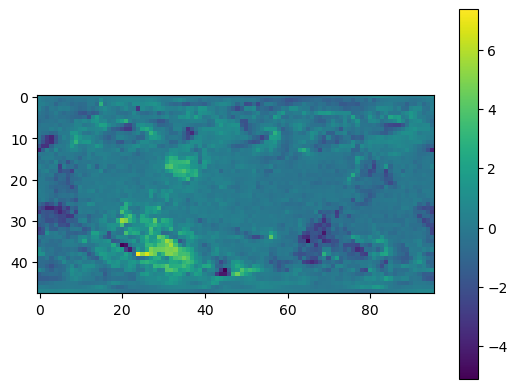

In [20]:
plt.imshow(target_dataset[500,0,:,:])
plt.colorbar()
plt.show()

In [21]:
print(torch.max(target_dataset[:,0,:,:]))

tensor(35.6476)


In [22]:
print(np.mean(temp), np.std(temp), np.min(temp), np.max(temp))
print(np.mean(humid), np.std(humid))
print(np.mean(u_wind), np.std(v_wind))
print(np.mean(v_wind), np.std(v_wind))
# print(np.mean(tisr), np.std(tisr))
# print(np.min(sst), np.max(sst))
print("-------------------------")
print("temp_delta mean & std: ", np.mean(temp_delta), np.std(temp_delta), ", temp_delta min & max: ", np.min(temp_delta),np.max(temp_delta))
print("humid_delta mean & std: ", np.mean(humid_delta), np.std(humid_delta), ", humid_delta min & max: ", np.min(humid_delta),np.max(humid_delta))
print("u_wind_delta mean & std: ", np.mean(u_wind_delta), np.std(v_wind_delta), ", u_wind delta min & max: ", np.min(u_wind_delta),np.max(u_wind_delta))
print("v_wind_delta mean & std: ", np.mean(v_wind_delta), np.std(v_wind_delta), ", v_wind delta min & max: ", np.min(v_wind_delta),np.max(v_wind_delta))
print("sp_delta mean & std: ", np.mean(sp_delta), np.std(sp_delta), ", sp_delta min & max: ", np.min(sp_delta),np.max(sp_delta))

1.48091385e-05 0.9999995 -5.4682465 3.3437874
-1.6845432e-07 0.99999946
1.0474315e-07 0.9999995
-7.616179e-09 0.9999995
-------------------------
temp_delta mean & std:  6.933891e-05 1.0000012 , temp_delta min & max:  -32.03803 35.647552
humid_delta mean & std:  3.4759298e-05 1.0000015 , humid_delta min & max:  -62.224495 59.51605
u_wind_delta mean & std:  -6.716601e-06 1.0000001 , u_wind delta min & max:  -14.386698 15.104862
v_wind_delta mean & std:  -8.494543e-07 1.0000001 , v_wind delta min & max:  -17.787954 19.377218
sp_delta mean & std:  9.088591e-06 0.99999887 , sp_delta min & max:  -15.372133 14.809394


In [23]:
print(torch.max(target_dataset[0,0,:,:]))

tensor(6.9715)


In [24]:
class SpectralLoss(nn.Module):
    """Spectral loss"""

    def __init__(
        self,
        img_size: Tuple[int, int],
        p: Optional[float] = 2.0,
        size_average: Optional[bool] = True,
        reduction: Optional[bool] = False,
        absolute: Optional[bool] = False,
        squared: Optional[bool] = False,
    ):  # pragma: no cover
        super(SpectralLoss, self).__init__()

        self.reduction = reduction
        self.size_average = size_average
        self.absolute = absolute
        self.squared = squared

        self.sht = RealSHT(*img_size, grid="legendre-gauss").float()
        spectral_weights = torch.arange(self.sht.lmax).float()
        spectral_weights = spectral_weights + 1
        self.register_buffer("spectral_weights", spectral_weights)

    def abs(self, prd: torch.Tensor, tar: torch.Tensor):  # pragma: no cover
        """Computes the absolute loss"""
        num_examples = prd.size()[0]

        # compute coefficients
        coeffs = torch.view_as_real(self.sht(prd - tar))
        coeffs = coeffs[..., 0] ** 2 + coeffs[..., 1] ** 2
        norm2 = coeffs[..., :, 0] + 2 * torch.sum(coeffs[..., :, 1:], dim=-1)
        norm2 = (self.spectral_weights * norm2).reshape(num_examples, -1).sum(dim=-1)

        if not self.squared:
            norm2 = torch.sqrt(norm2)

        all_norms = norm2

        if self.reduction:
            if self.size_average:
                return torch.mean(all_norms)
            else:
                return torch.sum(all_norms)

        return all_norms

    def rel(
        self, prd: torch.Tensor, tar: torch.Tensor, mask: Optional[torch.Tensor] = None
    ):  # pragma: no cover
        """Computes the relative loss"""
        num_examples = prd.size()[0]

        # compute coefficients
        coeffs = torch.view_as_real(self.sht(prd - tar))
        coeffs = coeffs[..., 0] ** 2 + coeffs[..., 1] ** 2
        norm2 = coeffs[..., :, 0] + 2 * torch.sum(coeffs[..., :, 1:], dim=-1)
        norm2 = (self.spectral_weights * norm2).reshape(num_examples, -1).sum(dim=-1)

        # compute coefficients
        tar_coeffs = torch.view_as_real(self.sht(tar))
        tar_coeffs = tar_coeffs[..., 0] ** 2 + tar_coeffs[..., 1] ** 2
        tar_norm2 = tar_coeffs[..., :, 0] + 2 * torch.sum(
            tar_coeffs[..., :, 1:], dim=-1
        )
        tar_norm2 = (
            (self.spectral_weights * tar_norm2).reshape(num_examples, -1).sum(dim=-1)
        )

        retval = tar_norm2 / norm2

        if mask is not None:
            retval = retval * mask

        if self.reduction:
            if self.size_average:
                if mask is None:
                    retval = torch.mean(retval)
                else:
                    retval = torch.sum(retval) / torch.sum(mask)
            else:
                retval = torch.sum(retval)

        if not self.squared:
            retval

        return retval

    def forward(
        self, prd: torch.Tensor, tar: torch.Tensor, mask: Optional[torch.Tensor] = None
    ):  # pragma: no cover
        # prd = prd.to(device)
        # tar = tar.to(device)
        if self.absolute:
            loss = self.abs(prd, tar)
        else:
            loss = self.rel(prd, tar, mask)

        return loss

In [25]:
import numpy as np
import torch
import torch.nn as nn
import torch.fft



class RealSHT(nn.Module):
    """
    Defines a module for computing the forward (real-valued) SHT.
    Precomputes Legendre Gauss nodes, weights and associated Legendre polynomials on these nodes.
    The SHT is applied to the last two dimensions of the input

    [1] Schaeffer, N. Efficient spherical harmonic transforms aimed at pseudospectral numerical simulations, G3: Geochemistry, Geophysics, Geosystems.
    [2] Wang, B., Wang, L., Xie, Z.; Accurate calculation of spherical and vector spherical harmonic expansions via spectral element grids; Adv Comput Math.
    """

    def __init__(self, nlat, nlon, lmax=None, mmax=None, grid="lobatto", norm="ortho", csphase=True):
        """
        Initializes the SHT Layer, precomputing the necessary quadrature weights

        Parameters:
        nlat: input grid resolution in the latitudinal direction
        nlon: input grid resolution in the longitudinal direction
        grid: grid in the latitude direction (for now only tensor product grids are supported)
        """

        super().__init__()

        self.nlat = nlat
        self.nlon = nlon
        self.grid = grid
        self.norm = norm
        self.csphase = csphase

        # TODO: include assertions regarding the dimensions

        # compute quadrature points
        if self.grid == "legendre-gauss":
            cost, w = legendre_gauss_weights(nlat, -1, 1)
            self.lmax = lmax or self.nlat
        elif self.grid == "lobatto":
            cost, w = lobatto_weights(nlat, -1, 1)
            self.lmax = lmax or self.nlat-1
        elif self.grid == "equiangular":
            cost, w = clenshaw_curtiss_weights(nlat, -1, 1)
            # cost, w = fejer2_weights(nlat, -1, 1)
            self.lmax = lmax or self.nlat
        else:
            raise(ValueError("Unknown quadrature mode"))

        # apply cosine transform and flip them
        tq = np.flip(np.arccos(cost))

        # determine the dimensions
        self.mmax = mmax or self.nlon // 2 + 1

        # combine quadrature weights with the legendre weights
        weights = torch.from_numpy(w).to(device)
        pct = _precompute_legpoly(self.mmax, self.lmax, tq, norm=self.norm, csphase=self.csphase)
        pct = torch.from_numpy(pct).to(device)
        weights = torch.einsum('mlk,k->mlk', pct, weights)

        # remember quadrature weights
        # if USE_FIX:
        self.weights = weights.float().to(device)
        # else:
        #     self.register_buffer('weights', weights, persistent=False)

    def extra_repr(self):
        """
        Pretty print module
        """
        return f'nlat={self.nlat}, nlon={self.nlon},\n lmax={self.lmax}, mmax={self.mmax},\n grid={self.grid}, csphase={self.csphase}'

    def forward(self, x: torch.Tensor):

        assert(x.shape[-2] == self.nlat)
        assert(x.shape[-1] == self.nlon)

        # apply real fft in the longitudinal direction
        x = 2.0 * torch.pi * torch.fft.rfft(x, dim=-1, norm="forward")

        # do the Legendre-Gauss quadrature
        x = torch.view_as_real(x)

        # distributed contraction: fork
        out_shape = list(x.size())
        out_shape[-3] = self.lmax
        out_shape[-2] = self.mmax
        xout = torch.zeros(out_shape, dtype=x.dtype, device=x.device)
        # contraction
        self.weights = self.weights.to(x.device)
        xout[..., 0] = torch.einsum('...km,mlk->...lm', x[..., :self.mmax, 0], self.weights)
        xout[..., 1] = torch.einsum('...km,mlk->...lm', x[..., :self.mmax, 1], self.weights)
        x = torch.view_as_complex(xout)

        return x

class InverseRealSHT(nn.Module):
    """
    Defines a module for computing the inverse (real-valued) SHT.
    Precomputes Legendre Gauss nodes, weights and associated Legendre polynomials on these nodes.
    nlat, nlon: Output dimensions
    lmax, mmax: Input dimensions (spherical coefficients). For convenience, these are inferred from the output dimensions

    [1] Schaeffer, N. Efficient spherical harmonic transforms aimed at pseudospectral numerical simulations, G3: Geochemistry, Geophysics, Geosystems.
    [2] Wang, B., Wang, L., Xie, Z.; Accurate calculation of spherical and vector spherical harmonic expansions via spectral element grids; Adv Comput Math.
    """

    def __init__(self, nlat, nlon, lmax=None, mmax=None, grid="lobatto", norm="ortho", csphase=True):

        super().__init__()

        self.nlat = nlat
        self.nlon = nlon
        self.grid = grid
        self.norm = norm
        self.csphase = csphase

        # compute quadrature points
        if self.grid == "legendre-gauss":
            cost, _ = legendre_gauss_weights(nlat, -1, 1)
            self.lmax = lmax or self.nlat
        elif self.grid == "lobatto":
            cost, _ = lobatto_weights(nlat, -1, 1)
            self.lmax = lmax or self.nlat-1
        elif self.grid == "equiangular":
            cost, _ = clenshaw_curtiss_weights(nlat, -1, 1)
            self.lmax = lmax or self.nlat
        else:
            raise(ValueError("Unknown quadrature mode"))

        # apply cosine transform and flip them
        t = np.flip(np.arccos(cost))

        # determine the dimensions
        self.mmax = mmax or self.nlon // 2 + 1

        pct = _precompute_legpoly(self.mmax, self.lmax, t, norm=self.norm, inverse=True, csphase=self.csphase)
        pct = torch.from_numpy(pct).to(device)
        USE_FIX = True
        # register buffer
        if USE_FIX:
            self.pct = pct.float()
        else:
            self.register_buffer('pct', pct, persistent=False)

    def extra_repr(self):
        """
        Pretty print module
        """
        return f'nlat={self.nlat}, nlon={self.nlon},\n lmax={self.lmax}, mmax={self.mmax},\n grid={self.grid}, csphase={self.csphase}'

    def forward(self, x: torch.Tensor):

        assert(x.shape[-2] == self.lmax)
        assert(x.shape[-1] == self.mmax)

        # Evaluate associated Legendre functions on the output nodes
        x = torch.view_as_real(x)
        USE_FIX = True
        if USE_FIX:
            self.pct = self.pct.to(x.device)
        rl = torch.einsum('...lm, mlk->...km', x[..., 0], self.pct )
        im = torch.einsum('...lm, mlk->...km', x[..., 1], self.pct )
        xs = torch.stack((rl, im), -1)

        # apply the inverse (real) FFT
        x = torch.view_as_complex(xs)
        x = torch.fft.irfft(x, n=self.nlon, dim=-1, norm="forward")

        return x

In [26]:
import time

def spectral_regularizer(prd, tar, relative=False, squared=True):
    # compute coefficients
    diff = (prd-tar)

    shtdiff = sht(diff)
    coeffs = torch.view_as_real(shtdiff)

    coeffs = coeffs[..., 0]**2 + coeffs[..., 1]**2    # take the real part only

    norm2 = 2 * torch.sum(coeffs[..., :, 24:], dim=-1)  # regularize the wave number beyond 5
    loss_reg = torch.sum(norm2, dim=(-1,-2))

    if not squared:
        loss_reg = torch.sqrt(loss_reg)
    loss_reg = loss_reg.mean()

    return loss_reg

num_elements = 48

# Generate evenly spaced values between -π/2 and π/2
cos_weight_reg = torch.cos(torch.linspace(-np.pi, np.pi, num_elements)).to(device).reshape(1,48) + 1


mse_loss = nn.MSELoss()
def train_model(model, train_set, test_set, optimizer, scheduler=None, nepochs=20, nfuture=0, num_examples=256, num_valid=8, loss_fn='l2', reg_rate=0):

    train_start = time.time()

    train_loader_1 = DataLoader(train_set, batch_size=16, shuffle=True)
    test_loader_1 = DataLoader(test_set, batch_size=16, shuffle=True)

    infer_bias = 1e+80
    recall_count = 0
    for epoch in tqdm(range(nepochs)):
        if epoch < 149:
            if scheduler is not None:
                scheduler.step()
        else:
            for param_group in optimizer.param_groups:
                param_group['lr'] = 1e-6
        epoch_start = time.time()

        optimizer.zero_grad()
        acc_loss = 0

        model.train()
        batch_num = 0
        for inp, tar in train_loader_1:
            #noise = (torch.randn(inp.size(0), 5, inp.size(2), inp.size(3)) * std + mean).to(device)
            batch_num += 1
            loss = 0
            inp = inp.to(device)
            #inp[:,:5,:,:] += noise
            tar = tar.to(device)
            #tar[:,:5,:,:] -= noise
            prd = model(inp)

            if loss_fn == 'l2':
                loss_delta = l2loss_sphere(prd[:,:5,:,:], tar[:,:5,:,:], relative=True)
                #loss_tp = SpectralLoss(img_size=(48, 96), absolute=True)(prd[:,5:,:,:].to("cpu"),tar[:,5:,:,:].to("cpu"))
                loss_tp = torch.mean((prd[:,5:,:,:]-tar[:,5:,:,:])**2)
                loss = (loss_delta.to(device)*5 + loss_tp.to(device))/6
                #loss = loss.mean()
            #    loss += 0.1*l2loss_sphere(frame, next_frame)
            elif loss_fn == "spectral l2":
                #loss = spectral_l2loss_sphere(prd, tar)
                # prd = prd / res_array
                # tar = tar / res_array
                loss = SpectralLoss(img_size=(48, 96), absolute=True)(prd.to("cpu"),tar.to("cpu"))


            prd = prd.to(device)
            roll_loss = 0
            acc_loss += loss.item() * inp.size(0)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            prd_plt = prd
            tar_plt = tar

        # print(loss_delta.item(), loss_tp.item(), loss_reg.item())
        #print(loss0.item(), loss1.item(), loss2.item(), loss3.item(), loss4.item(), loss5.item())
        if scheduler is not None:
            scheduler.step()

        if (epoch+1) % 20 == 0:
            with torch.no_grad():
                pred_frame = input_dataset[0].reshape(1,7,48,96) # T, SH, U, V, SP, TISR, ORO
                pred_frame = pred_frame.to(device)
                temp_bias = torch.zeros(48,96).to(device)
                for k in range(2920):
                    previous_frame = pred_frame[:,:5,:,:]
                    pred_frame = model(pred_frame) # 6
                    pred_frame[:,:5,:,:] = pred_frame[:,:5,:,:] * target_stds[:,:5,:,:] # T, SH, U, V, SP, TP
                    # pred_frame = (pred_frame + 1) / 2 * (target_maxs - target_mins) + target_mins

                    pred_frame[:,:5,:,:] += previous_frame[:,:5,:,:] * input_stds + input_means
                    tp_frame = pred_frame[:,5:,:,:] * tp_std + tp_mean
                    # pred_frame += (previous_frame + 1) / 2 * (input_maxs - input_mins) + input_mins
                    plot_frame = torch.cat((pred_frame[:,:5,:,:], tp_frame), 1) # T, SH, U, V, SP, TP

                    pred_frame = pred_frame[:,:5,:,:]
                    pred_frame = (pred_frame - input_means) / input_stds
                    if k >= 1460:
                        temp_bias += pred_frame[0,0,:,:].clone().detach()
                    # pred_frame = 2 * (pred_frame - input_mins) / (input_maxs - input_mins) - 1

                    pred_frame = torch.cat((pred_frame, input_dataset[k+1,5:,:,:].reshape(1,2,48,96).to(device)), dim=1)
                    
                temp_bias = torch.mean(torch.abs(temp_bias / 1460 - true_temp_clim))
                print(temp_bias)
                validation_bias.append(temp_bias)
                if epoch > 60:
                    if temp_bias <= infer_bias:
                        infer_bias = temp_bias
                        torch.save(model.state_dict(), 'LUCIE_method_results/regular_training_checkpoint_0.pth')
                        recall_count = 0
                    else:
                        print('recall')
                        state_pth = torch.load('LUCIE_method_results/regular_training_checkpoint_0.pth')
                        model.load_state_dict(state_pth)
                        recall_count += 1
                        if recall_count > 3:
                            print(epoch)
                            break
                        
                    
                plot_frame = plot_frame.clone().detach().cpu().numpy()
                fig = plt.figure(figsize=(14, 4))
                plt.subplot(1,7,1)
                plt.imshow(plot_frame[0][0], origin="lower")
                plt.axis("off")
                plt.colorbar(shrink=0.3)
                plt.subplot(1,7,2)
                plt.imshow(plot_frame[0][1], origin="lower")
                plt.axis("off")
                plt.colorbar(shrink=0.3)
                plt.subplot(1,7,3)
                plt.imshow(plot_frame[0][2], origin="lower")
                plt.axis("off")
                plt.colorbar(shrink=0.3)
                plt.subplot(1,7,4)
                plt.imshow(plot_frame[0][3], origin="lower")
                plt.axis("off")
                plt.colorbar(shrink=0.3)
                plt.subplot(1,7,5)
                plt.imshow(plot_frame[0][4], origin="lower")
                plt.axis("off")
                plt.colorbar(shrink=0.3)
                plt.subplot(1,7,6)
                plt.imshow(plot_frame[0][5], origin="lower")
                plt.axis("off")
                plt.colorbar(shrink=0.3)
                plt.show()



In [27]:
# coding=utf-8

# SPDX-FileCopyrightText: Copyright (c) 2022 The torch-harmonics Authors. All rights reserved.
# SPDX-License-Identifier: BSD-3-Clause
# 
# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:
#
# 1. Redistributions of source code must retain the above copyright notice, this
# list of conditions and the following disclaimer.
#
# 2. Redistributions in binary form must reproduce the above copyright notice,
# this list of conditions and the following disclaimer in the documentation
# and/or other materials provided with the distribution.
#
# 3. Neither the name of the copyright holder nor the names of its
# contributors may be used to endorse or promote products derived from
# this software without specific prior written permission.
#
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
# FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
# DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
# SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
# CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
# OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
#

import numpy as np

def _precompute_grid(n, grid="equidistant", a=0.0, b=1.0, periodic=False):

    if (grid != "equidistant") and periodic:
        raise ValueError(f"Periodic grid is only supported on equidistant grids.")

    # compute coordinates
    if grid == "equidistant":
        xlg, wlg = trapezoidal_weights(n, a=a, b=b, periodic=periodic)
    elif grid == "legendre-gauss":
        xlg, wlg = legendre_gauss_weights(n, a=a, b=b)
    elif grid == "lobatto":
        xlg, wlg = lobatto_weights(n, a=a, b=b)
    elif grid == "equiangular":
        xlg, wlg = clenshaw_curtiss_weights(n, a=a, b=b)
    else:
        raise ValueError(f"Unknown grid type {grid}")

    return xlg, wlg

def _precompute_latitudes(nlat, grid="equiangular"):
    r"""
    Convenience routine to precompute latitudes
    """

    # compute coordinates
    xlg, wlg = _precompute_grid(nlat, grid=grid, a=-1.0, b=1.0, periodic=False)

    lats = np.flip(np.arccos(xlg)).copy()
    wlg = np.flip(wlg).copy()

    return lats, wlg

def trapezoidal_weights(n, a=-1.0, b=1.0, periodic=False):
    r"""
    Helper routine which returns equidistant nodes with trapezoidal weights
    on the interval [a, b]
    """

    xlg = np.linspace(a, b, n)
    wlg = (b - a) / (n - 1) * np.ones(n)

    if not periodic:
        wlg[0] *= 0.5
        wlg[-1] *= 0.5

    return xlg, wlg

def legendre_gauss_weights(n, a=-1.0, b=1.0):
    r"""
    Helper routine which returns the Legendre-Gauss nodes and weights
    on the interval [a, b]
    """

    xlg, wlg = np.polynomial.legendre.leggauss(n)
    xlg = (b - a) * 0.5 * xlg + (b + a) * 0.5
    wlg = wlg * (b - a) * 0.5

    return xlg, wlg

def lobatto_weights(n, a=-1.0, b=1.0, tol=1e-16, maxiter=100):
    r"""
    Helper routine which returns the Legendre-Gauss-Lobatto nodes and weights
    on the interval [a, b]
    """

    wlg = np.zeros((n,))
    tlg = np.zeros((n,))
    tmp = np.zeros((n,))

    # Vandermonde Matrix
    vdm = np.zeros((n, n))
  
    # initialize Chebyshev nodes as first guess
    for i in range(n): 
        tlg[i] = -np.cos(np.pi*i / (n-1))
    
    tmp = 2.0
    
    for i in range(maxiter):
        tmp = tlg
       
        vdm[:,0] = 1.0 
        vdm[:,1] = tlg
       
        for k in range(2, n):
            vdm[:, k] = ( (2*k-1) * tlg * vdm[:, k-1] - (k-1) * vdm[:, k-2] ) / k
       
        tlg = tmp - ( tlg*vdm[:, n-1] - vdm[:, n-2] ) / ( n * vdm[:, n-1]) 
        
        if (max(abs(tlg - tmp).flatten()) < tol ):
            break 
    
    wlg = 2.0 / ( (n*(n-1))*(vdm[:, n-1]**2))

    # rescale
    tlg = (b - a) * 0.5 * tlg + (b + a) * 0.5
    wlg = wlg * (b - a) * 0.5
    
    return tlg, wlg


def clenshaw_curtiss_weights(n, a=-1.0, b=1.0):
    r"""
    Computation of the Clenshaw-Curtis quadrature nodes and weights.
    This implementation follows

    [1] Joerg Waldvogel, Fast Construction of the Fejer and Clenshaw-Curtis Quadrature Rules; BIT Numerical Mathematics, Vol. 43, No. 1, pp. 001–018.
    """

    assert(n > 1)

    tcc = np.cos(np.linspace(np.pi, 0, n))

    if n == 2:
        wcc = np.array([1., 1.])
    else:

        n1 = n - 1
        N = np.arange(1, n1, 2)
        l = len(N)
        m = n1 - l

        v = np.concatenate([2 / N / (N-2), 1 / N[-1:], np.zeros(m)])
        v = 0 - v[:-1] - v[-1:0:-1]

        g0 = -np.ones(n1)
        g0[l] = g0[l] + n1
        g0[m] = g0[m] + n1
        g = g0 / (n1**2 - 1 + (n1%2))
        wcc = np.fft.ifft(v + g).real
        wcc = np.concatenate((wcc, wcc[:1]))

    # rescale
    tcc = (b - a) * 0.5 * tcc + (b + a) * 0.5
    wcc = wcc * (b - a) * 0.5

    return tcc, wcc

def fejer2_weights(n, a=-1.0, b=1.0):
    r"""
    Computation of the Fejer quadrature nodes and weights.
    This implementation follows

    [1] Joerg Waldvogel, Fast Construction of the Fejer and Clenshaw-Curtis Quadrature Rules; BIT Numerical Mathematics, Vol. 43, No. 1, pp. 001–018.
    """

    assert(n > 2)

    tcc = np.cos(np.linspace(np.pi, 0, n))

    n1 = n - 1
    N = np.arange(1, n1, 2)
    l = len(N)
    m = n1 - l

    v = np.concatenate([2 / N / (N-2), 1 / N[-1:], np.zeros(m)])
    v = 0 - v[:-1] - v[-1:0:-1]

    wcc = np.fft.ifft(v).real
    wcc = np.concatenate((wcc, wcc[:1]))

    # rescale
    tcc = (b - a) * 0.5 * tcc + (b + a) * 0.5
    wcc = wcc * (b - a) * 0.5

    return tcc, wcc

In [28]:


import numpy as np

def clm(l, m):
    """
    defines the normalization factor to orthonormalize the Spherical Harmonics
    """
    return np.sqrt((2*l + 1) / 4 / np.pi) * np.sqrt(np.math.factorial(l-m) / np.math.factorial(l+m))

def legpoly(mmax, lmax, x, norm="ortho", inverse=False, csphase=True):
    r"""
    Computes the values of (-1)^m c^l_m P^l_m(x) at the positions specified by x.
    The resulting tensor has shape (mmax, lmax, len(x)). The Condon-Shortley Phase (-1)^m
    can be turned off optionally.

    method of computation follows
    [1] Schaeffer, N.; Efficient spherical harmonic transforms aimed at pseudospectral numerical simulations, G3: Geochemistry, Geophysics, Geosystems.
    [2] Rapp, R.H.; A Fortran Program for the Computation of Gravimetric Quantities from High Degree Spherical Harmonic Expansions, Ohio State University Columbus; report; 1982;
        https://apps.dtic.mil/sti/citations/ADA123406
    [3] Schrama, E.; Orbit integration based upon interpolated gravitational gradients
    """

    # compute the tensor P^m_n:
    nmax = max(mmax,lmax)
    vdm = np.zeros((nmax, nmax, len(x)), dtype=np.float64)
        
    norm_factor = 1. if norm == "ortho" else np.sqrt(4 * np.pi)
    norm_factor = 1. / norm_factor if inverse else norm_factor

    # initial values to start the recursion
    vdm[0,0,:] = norm_factor / np.sqrt(4 * np.pi)

    # fill the diagonal and the lower diagonal
    for l in range(1, nmax):
        vdm[l-1, l, :] = np.sqrt(2*l + 1) * x * vdm[l-1, l-1, :]
        vdm[l, l, :] = np.sqrt( (2*l + 1) * (1 + x) * (1 - x) / 2 / l ) * vdm[l-1, l-1, :]

    # fill the remaining values on the upper triangle and multiply b
    for l in range(2, nmax):
        for m in range(0, l-1):
            vdm[m, l, :] = x * np.sqrt((2*l - 1) / (l - m) * (2*l + 1) / (l + m)) * vdm[m, l-1, :] \
                            - np.sqrt((l + m - 1) / (l - m) * (2*l + 1) / (2*l - 3) * (l - m - 1) / (l + m)) * vdm[m, l-2, :]

    if norm == "schmidt":
        for l in range(0, nmax):
            if inverse:
                vdm[:, l, : ] = vdm[:, l, : ] * np.sqrt(2*l + 1)
            else:
                vdm[:, l, : ] = vdm[:, l, : ] / np.sqrt(2*l + 1)

    vdm = vdm[:mmax, :lmax]

    if csphase:
        for m in range(1, mmax, 2):
            vdm[m] *= -1

    return vdm

def _precompute_legpoly(mmax, lmax, t, norm="ortho", inverse=False, csphase=True):
    r"""
    Computes the values of (-1)^m c^l_m P^l_m(\cos \theta) at the positions specified by t (theta).
    The resulting tensor has shape (mmax, lmax, len(x)). The Condon-Shortley Phase (-1)^m
    can be turned off optionally.

    method of computation follows
    [1] Schaeffer, N.; Efficient spherical harmonic transforms aimed at pseudospectral numerical simulations, G3: Geochemistry, Geophysics, Geosystems.
    [2] Rapp, R.H.; A Fortran Program for the Computation of Gravimetric Quantities from High Degree Spherical Harmonic Expansions, Ohio State University Columbus; report; 1982;
        https://apps.dtic.mil/sti/citations/ADA123406
    [3] Schrama, E.; Orbit integration based upon interpolated gravitational gradients
    """

    return legpoly(mmax, lmax, np.cos(t), norm=norm, inverse=inverse, csphase=csphase)

def _precompute_dlegpoly(mmax, lmax, t, norm="ortho", inverse=False, csphase=True):
    r"""
    Computes the values of the derivatives $\frac{d}{d \theta} P^m_l(\cos \theta)$
    at the positions specified by t (theta), as well as $\frac{1}{\sin \theta} P^m_l(\cos \theta)$,
    needed for the computation of the vector spherical harmonics. The resulting tensor has shape
    (2, mmax, lmax, len(t)).

    computation follows
    [2] Wang, B., Wang, L., Xie, Z.; Accurate calculation of spherical and vector spherical harmonic expansions via spectral element grids; Adv Comput Math.
    """

    pct = _precompute_legpoly(mmax+1, lmax+1, t, norm=norm, inverse=inverse, csphase=False)

    dpct = np.zeros((2, mmax, lmax, len(t)), dtype=np.float64)

    # fill the derivative terms wrt theta
    for l in range(0, lmax):

        # m = 0
        dpct[0, 0, l] = - np.sqrt(l*(l+1)) * pct[1, l]

        # 0 < m < l
        for m in range(1, min(l, mmax)):
            dpct[0, m, l] = 0.5 * ( np.sqrt((l+m)*(l-m+1)) * pct[m-1, l] - np.sqrt((l-m)*(l+m+1)) * pct[m+1, l] )

        # m == l
        if mmax > l:
            dpct[0, l, l] = np.sqrt(l/2) * pct[l-1, l]

        # fill the - 1j m P^m_l / sin(phi). as this component is purely imaginary,
        # we won't store it explicitly in a complex array
        for m in range(1, min(l+1, mmax)):
            # this component is implicitly complex
            # we do not divide by m here as this cancels with the derivative of the exponential
            dpct[1, m, l] = 0.5 * np.sqrt((2*l+1)/(2*l+3)) * \
                ( np.sqrt((l-m+1)*(l-m+2)) * pct[m-1, l+1] + np.sqrt((l+m+1)*(l+m+2)) * pct[m+1, l+1] )

    if csphase:
        for m in range(1, mmax, 2):
            dpct[:, m] *= -1

    return dpct

In [29]:
import time

def spectral_regularizer(prd, tar, relative=False, squared=True):
    # compute coefficients
    diff = (prd-tar)

    shtdiff = sht(diff)
    coeffs = torch.view_as_real(shtdiff)

    coeffs = coeffs[..., 0]**2 + coeffs[..., 1]**2    # take the real part only

    norm2 = 2 * torch.sum(coeffs[..., :, 24:], dim=-1)  # regularize the wave number beyond 5
    loss_reg = torch.sum(norm2, dim=(-1,-2))

    if not squared:
        loss_reg = torch.sqrt(loss_reg)
    loss_reg = loss_reg.mean()

    return loss_reg

num_elements = 48

# Generate evenly spaced values between -π/2 and π/2
cos_weight_reg = torch.cos(torch.linspace(-np.pi, np.pi, num_elements)).to(device).reshape(1,48) + 1


mse_loss = nn.MSELoss()
def train_model_fft(model, train_set, test_set, optimizer, scheduler=None, nepochs=20, nfuture=0, num_examples=256, num_valid=8, loss_fn='l2', reg_rate=0):

    train_start = time.time()

    train_loader_1 = DataLoader(train_set, batch_size=16, shuffle=True)
    test_loader_1 = DataLoader(test_set, batch_size=16, shuffle=True)

    for epoch in range(nepochs):
        epoch_start = time.time()

        optimizer.zero_grad()
        acc_loss = 0

        model.train()
        i = 0
        for inp, tar in train_loader_1:
            #noise = (torch.randn(inp.size(0), 5, inp.size(2), inp.size(3)) * std + mean).to(device)
            i += 1
            loss = 0
            inp = inp.to(device)
            #inp[:,:5,:,:] += noise
            tar = tar.to(device)
            #tar[:,:5,:,:] -= noise
            prd = model(inp)

            if loss_fn == 'l2':
                loss_delta = l2loss_sphere(prd[:,:5,:,:], tar[:,:5,:,:], relative=True)
                #loss_tp = SpectralLoss(img_size=(48, 96), absolute=True)(prd[:,5:,:,:].to("cpu"),tar[:,5:,:,:].to("cpu"))
                loss_tp = torch.mean((prd[:,5:,:,:]-tar[:,5:,:,:])**2)
                loss = (loss_delta.to(device)*5 + loss_tp.to(device))/6
                #loss = loss.mean()
            #    loss += 0.1*l2loss_sphere(frame, next_frame)
            elif loss_fn == "spectral l2":
                #loss = spectral_l2loss_sphere(prd, tar)
                # prd = prd / res_array
                # tar = tar / res_array
                loss = SpectralLoss(img_size=(48, 96), absolute=True)(prd.to("cpu"),tar.to("cpu"))

            
            lat_index = np.r_[7:15, 32:40]
            # lat_index = np.r_[0:48]
            quad_weight_reg = quad_weights.reshape(1,1,48,1)[:,:,lat_index,:]
            out_fft = torch.mean(torch.abs(torch.fft.rfft(prd[:,:,lat_index,:],dim=3)),dim=2)
            target_fft = torch.mean(torch.abs(torch.fft.rfft(tar[:,:,lat_index,:],dim=3)),dim=2)
            

            # wave_weight = torch.arange(48).reshape(1,1,48).to(device)
            wave_index = np.r_[0:48]
            #wave_index = np.r_[7:15,32:40]
            loss_reg = torch.mean(torch.mean(torch.abs(out_fft[:,:,wave_index]-target_fft[:,:,wave_index]),dim=-1))

            loss = loss + reg_rate * loss_reg

            prd = prd.to(device)
            roll_loss = 0
            acc_loss += loss.item() * inp.size(0)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            prd_plt = prd
            tar_plt = tar

        print(loss_delta.item(), loss_tp.item(), loss_reg.item())
        print(loss0.item(), loss1.item(), loss2.item(), loss3.item(), loss4.item(), loss5.item())
        if scheduler is not None:
            scheduler.step()
        acc_loss = acc_loss / len(train_loader_1.dataset)
        if epoch % 5 == 0:
            print(str(epoch))
            plt.subplot(1,2,1)
            plt.imshow(prd_plt[0,5,:,:].clone().detach().cpu(),origin="lower")
            plt.colorbar(shrink=0.5)
            plt.subplot(1,2,2)
            plt.imshow(tar_plt[0,5,:,:].clone().detach().cpu(),origin="lower")
            plt.colorbar(shrink=0.5)
            #plt.savefig("train_inc.png")
            plt.show()
        valid_loss = 0
        model.eval()

        if (epoch+1) % 10 == 0:
            with torch.no_grad():
                pred_frame = input_dataset[0].reshape(1,7,48,96) # T, SH, U, V, SP, TISR, ORO
                pred_frame = pred_frame.to(device)
                for k in range(1000):
                    previous_frame = pred_frame[:,:5,:,:]
                    pred_frame = model(pred_frame) # 6

                    pred_frame[:,:5,:,:] = pred_frame[:,:5,:,:] * target_stds[:,:5,:,:] # T, SH, U, V, SP, TP
                    # pred_frame = (pred_frame + 1) / 2 * (target_maxs - target_mins) + target_mins

                    pred_frame[:,:5,:,:] += previous_frame[:,:5,:,:] * input_stds + input_means
                    tp_frame = pred_frame[:,5:,:,:] * tp_std + tp_mean
                    # pred_frame += (previous_frame + 1) / 2 * (input_maxs - input_mins) + input_mins
                    plot_frame = torch.cat((pred_frame[:,:5,:,:], tp_frame), 1) # T, SH, U, V, SP, TP

                    pred_frame = pred_frame[:,:5,:,:]
                    pred_frame = (pred_frame - input_means) / input_stds
                    # pred_frame = 2 * (pred_frame - input_mins) / (input_maxs - input_mins) - 1

                    pred_frame = torch.cat((pred_frame, input_dataset[k+1,5:,:,:].reshape(1,2,48,96).to(device)), dim=1)
                plot_frame = plot_frame.clone().detach().cpu().numpy()
                fig = plt.figure(figsize=(14, 4))
                plt.subplot(1,7,1)
                plt.imshow(plot_frame[0][0], origin="lower")
                plt.axis("off")
                plt.colorbar(shrink=0.3)
                plt.subplot(1,7,2)
                plt.imshow(plot_frame[0][1], origin="lower")
                plt.axis("off")
                plt.colorbar(shrink=0.3)
                plt.subplot(1,7,3)
                plt.imshow(plot_frame[0][2], origin="lower")
                plt.axis("off")
                plt.colorbar(shrink=0.3)
                plt.subplot(1,7,4)
                plt.imshow(plot_frame[0][3], origin="lower")
                plt.axis("off")
                plt.colorbar(shrink=0.3)
                plt.subplot(1,7,5)
                plt.imshow(plot_frame[0][4], origin="lower")
                plt.axis("off")
                plt.colorbar(shrink=0.3)
                plt.subplot(1,7,6)
                plt.imshow(plot_frame[0][5], origin="lower")
                plt.axis("off")
                plt.colorbar(shrink=0.3)
                # plt.subplot(1,7,7)
                # plt.imshow(first_tp[0,0,:,:].clone().detach().to("cpu").numpy(), origin="lower")
                # plt.axis("off")
                # plt.colorbar(shrink=0.3)
                #plt.savefig("hybrid_delta_6var.png")
                plt.show()

In [30]:
import time

def spectral_regularizer(prd, tar, relative=False, squared=True):
    # compute coefficients
    diff = (prd-tar)

    shtdiff = sht(diff)
    coeffs = torch.view_as_real(shtdiff)

    coeffs = coeffs[..., 0]**2 + coeffs[..., 1]**2    # take the real part only

    norm2 = 2 * torch.sum(coeffs[..., :, 24:], dim=-1)  # regularize the wave number beyond 5
    loss_reg = torch.sum(norm2, dim=(-1,-2))

    if not squared:
        loss_reg = torch.sqrt(loss_reg)
    loss_reg = loss_reg.mean()

    return loss_reg

num_elements = 48

# Generate evenly spaced values between -π/2 and π/2
cos_weight_reg = torch.cos(torch.linspace(-np.pi, np.pi, num_elements)).to(device).reshape(1,48) + 1


mse_loss = nn.MSELoss()
def train_model_fine(model, train_set, test_set, optimizer, scheduler=None, nepochs=20, nfuture=0, num_examples=256, num_valid=8, loss_fn='l2', reg_rate=0):

    train_start = time.time()

    train_loader_1 = DataLoader(train_set, batch_size=16, shuffle=True)
    test_loader_1 = DataLoader(test_set, batch_size=16, shuffle=True)

    infer_bias = 1e+20
    recall_count = 0
    for epoch in tqdm(range(nepochs)):
        if epoch < 149:
            if scheduler is not None:
                scheduler.step()
        else:
            for param_group in optimizer.param_groups:
                param_group['lr'] = 1e-6
        epoch_start = time.time()

        optimizer.zero_grad()
        acc_loss = 0

        model.train()
        batch_num = 0
        for inp, tar in train_loader_1:
            #noise = (torch.randn(inp.size(0), 5, inp.size(2), inp.size(3)) * std + mean).to(device)
            batch_num += 1
            loss = 0
            inp = inp.to(device)
            #inp[:,:5,:,:] += noise
            tar = tar.to(device)
            #tar[:,:5,:,:] -= noise
            prd = model(inp)

            if loss_fn == 'l2':
                loss_delta = l2loss_sphere(prd[:,:5,:,:], tar[:,:5,:,:], relative=True)
                #loss_tp = SpectralLoss(img_size=(48, 96), absolute=True)(prd[:,5:,:,:].to("cpu"),tar[:,5:,:,:].to("cpu"))
                loss_tp = torch.mean((prd[:,5:,:,:]-tar[:,5:,:,:])**2)
                loss = (loss_delta.to(device)*5 + loss_tp.to(device))/6
                #loss = loss.mean()
            #    loss += 0.1*l2loss_sphere(frame, next_frame)
            elif loss_fn == "spectral l2":
                #loss = spectral_l2loss_sphere(prd, tar)
                # prd = prd / res_array
                # tar = tar / res_array
                loss = SpectralLoss(img_size=(48, 96), absolute=True)(prd.to("cpu"),tar.to("cpu"))


            prd = prd.to(device)
            roll_loss = 0
            acc_loss += loss.item() * inp.size(0)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            prd_plt = prd
            tar_plt = tar

        # print(loss_delta.item(), loss_tp.item(), loss_reg.item())
        #print(loss0.item(), loss1.item(), loss2.item(), loss3.item(), loss4.item(), loss5.item())
        if scheduler is not None:
            scheduler.step()

        if (epoch+1) % 10 == 0:
            with torch.no_grad():
                pred_frame = input_dataset[0].reshape(1,7,48,96) # T, SH, U, V, SP, TISR, ORO
                pred_frame = pred_frame.to(device)
                temp_bias = torch.zeros(48,96).to(device)
                for k in range(2920):
                    previous_frame = pred_frame[:,:5,:,:]
                    pred_frame = model(pred_frame) # 6
                    pred_frame[:,:5,:,:] = pred_frame[:,:5,:,:] * target_stds[:,:5,:,:] # T, SH, U, V, SP, TP
                    # pred_frame = (pred_frame + 1) / 2 * (target_maxs - target_mins) + target_mins

                    pred_frame[:,:5,:,:] += previous_frame[:,:5,:,:] * input_stds + input_means
                    tp_frame = pred_frame[:,5:,:,:] * tp_std + tp_mean
                    # pred_frame += (previous_frame + 1) / 2 * (input_maxs - input_mins) + input_mins
                    plot_frame = torch.cat((pred_frame[:,:5,:,:], tp_frame), 1) # T, SH, U, V, SP, TP

                    pred_frame = pred_frame[:,:5,:,:]
                    pred_frame = (pred_frame - input_means) / input_stds
                    if k >= 1460:
                        temp_bias += pred_frame[0,0,:,:].clone().detach()
                    # pred_frame = 2 * (pred_frame - input_mins) / (input_maxs - input_mins) - 1

                    pred_frame = torch.cat((pred_frame, input_dataset[k+1,5:,:,:].reshape(1,2,48,96).to(device)), dim=1)
                    
                temp_bias = torch.mean(torch.abs(temp_bias / 1460 - true_temp_clim))
                print(temp_bias)
                validation_bias.append(temp_bias)
                if epoch > 1:
                    if temp_bias <= infer_bias:
                        infer_bias = temp_bias
                        torch.save(model.state_dict(), 'LUCIE_method_results/regular_training_checkpoint.pth')
                        recall_count = 0
                    else:
                        print('recall')
                        state_pth = torch.load('LUCIE_method_results/regular_training_checkpoint.pth')
                        model.load_state_dict(state_pth)
                        recall_count += 1
                        if recall_count > 3:
                            print(epoch)
                            break
                        
                    
                plot_frame = plot_frame.clone().detach().cpu().numpy()
                fig = plt.figure(figsize=(14, 4))
                plt.subplot(1,7,1)
                plt.imshow(plot_frame[0][0], origin="lower")
                plt.axis("off")
                plt.colorbar(shrink=0.3)
                plt.subplot(1,7,2)
                plt.imshow(plot_frame[0][1], origin="lower")
                plt.axis("off")
                plt.colorbar(shrink=0.3)
                plt.subplot(1,7,3)
                plt.imshow(plot_frame[0][2], origin="lower")
                plt.axis("off")
                plt.colorbar(shrink=0.3)
                plt.subplot(1,7,4)
                plt.imshow(plot_frame[0][3], origin="lower")
                plt.axis("off")
                plt.colorbar(shrink=0.3)
                plt.subplot(1,7,5)
                plt.imshow(plot_frame[0][4], origin="lower")
                plt.axis("off")
                plt.colorbar(shrink=0.3)
                plt.subplot(1,7,6)
                plt.imshow(plot_frame[0][5], origin="lower")
                plt.axis("off")
                plt.colorbar(shrink=0.3)
                # plt.subplot(1,7,7)
                # plt.imshow(first_tp[0,0,:,:].clone().detach().to("cpu").numpy(), origin="lower")
                # plt.axis("off")
                # plt.colorbar(shrink=0.3)
                #plt.savefig("hybrid_delta_6var.png")
                plt.show()



**!Model!**

In [ ]:
from math import ceil, sqrt
torch.manual_seed(1447)
torch.cuda.manual_seed(1447)
torch.cuda.empty_cache()

std = 0.05
mean = 0

grid='legendre-gauss'
nlat = 48
nlon = 96
hard_thresholding_fraction = 0.9
lmax = ceil(nlat / 1)
mmax = lmax
modes_lat = int(nlat * hard_thresholding_fraction)
modes_lon = int(nlon//2 * hard_thresholding_fraction)
modes_lat = modes_lon = min(modes_lat, modes_lon)
sht = RealSHT(nlat, nlon, lmax=modes_lat, mmax=modes_lon, grid=grid, csphase=False)
radius=6.37122E6
cost, quad_weights = legendre_gauss_weights(nlat, -1, 1)
#cost, quad_weights = th.quadrature.clenshaw_curtiss_weights(nlat, -1, 1)
quad_weights = (torch.as_tensor(quad_weights).reshape(-1, 1)).to(device)

model = SphericalFourierNeuralOperatorNet(params = {}, spectral_transform='sht', filter_type = "linear", operator_type='dhconv', img_shape=(48, 96),
                 num_layers=8, in_chans=7, out_chans=6, scale_factor=1, embed_dim=72, activation_function="silu", big_skip=True, pos_embed="latlon", use_mlp=True,
                                          normalization_layer="instance_norm", hard_thresholding_fraction=hard_thresholding_fraction,
                                          mlp_ratio = 2.).to(device)

validation_bias = []

from torch.optim.lr_scheduler import OneCycleLR, CosineAnnealingLR, StepLR
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0)
scheduler = CosineAnnealingLR(optimizer, T_max=150, eta_min=1e-5)
train_model(model, train_set, test_set, optimizer, scheduler=scheduler, nepochs=500, loss_fn = "l2")
torch.save(model.state_dict(), 'LUCIE_method_results/regular_8x72.pth')

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1E-6, weight_decay=0)
# scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-7)
train_model_fft(model, train_set, test_set, optimizer, scheduler=None, nepochs=10, loss_fn = "l2", reg_rate=0.05)

In [30]:
from tqdm import tqdm
val_a = input_dataset[0,:,:,:]

save_data = []
model.eval()
with torch.no_grad():
    inp_val = val_a.reshape(1,7,48,96)
    inp_val = inp_val.to(device)
    for i in tqdm(range(16000)):
        forcing_idx = i % 1460
        previous = inp_val[:,:5,:,:]

        pred = model(inp_val)
        pred[:,:5,:,:] = pred[:,:5,:,:] * target_stds[:,:5,:,:]

        pred[:,:5,:,:] += previous[:,:5,:,:] * input_stds + input_means
        tp_frame = pred[:,5:,:,:] * tp_std + tp_mean
        # pred_frame += (previous_frame + 1) / 2 * (input_maxs - input_mins) + input_mins
        plot = torch.cat((pred[:,:5,:,:],tp_frame), 1)

        inp_val = (pred[:,:5,:,:] - input_means) / input_stds
        inp_val = torch.cat((inp_val, input_dataset[i+1,5:,:,:].reshape(1,2,48,96).to(device)), dim=1)
        plot = plot.cpu().clone().detach().permute(0,2,3,1).numpy()
        save_data.append(plot[0])

save_data = np.array(save_data)
save_data[:,:,:,5] = (np.exp(save_data[:,:,:,5]) - 1) * 1e-2

# np.savez('LUCIE_method_results/regular_8x72_fftreg_baseline.npz', data=save_data)

100%|███████████████████| 16000/16000 [02:36<00:00, 102.40it/s]


(16538, 48, 96, 6)


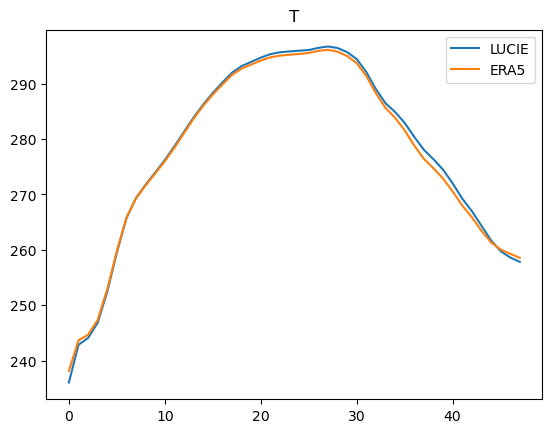

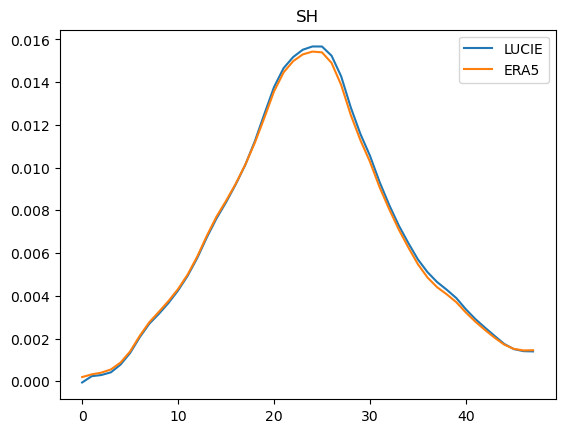

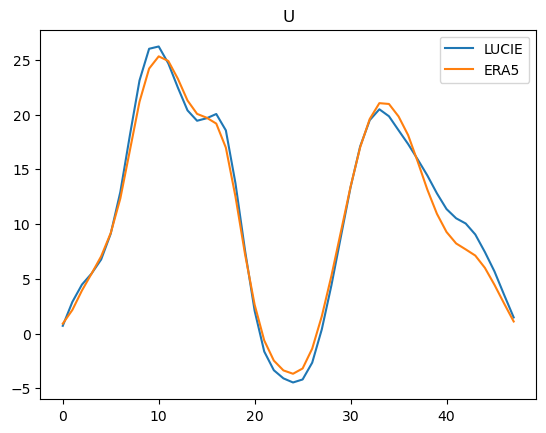

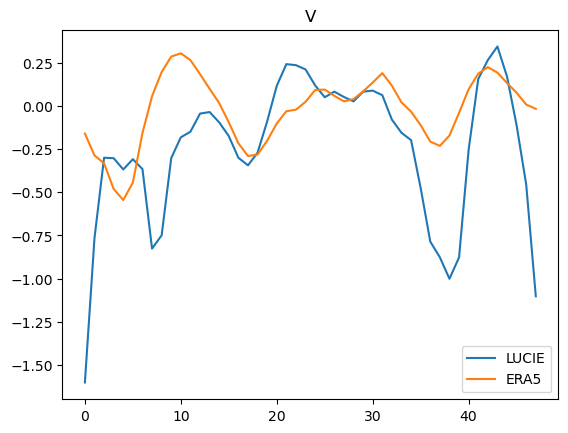

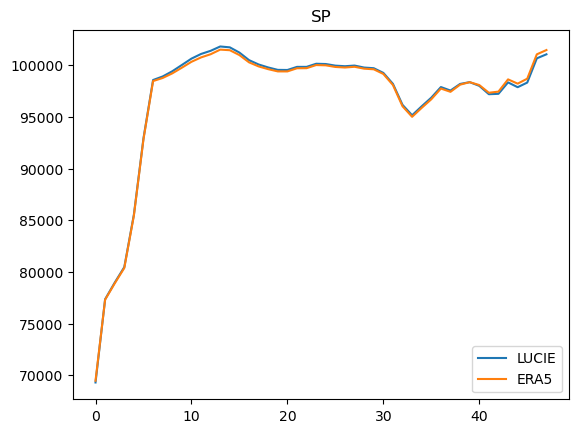

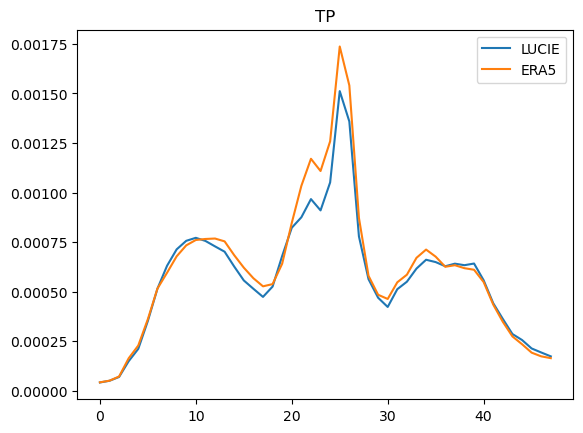

In [58]:
def compute_mean(arr):

  '''
arr is of shape [Ntime,Nchannels, Nlon,Nlat]
compute mean across time and latitudes
  '''


  time_mean = np.squeeze(np.mean(arr,0))
  time_zonal_mean = np.squeeze(np.mean(time_mean,2))
  return time_zonal_mean

data_p = load_data("../dataset/era5_numpy_file_train_test_logp.npz")
sp_true = np.exp(data_p[:16538,:,:,:]) * 1000.0 * 100.0

data_tp = load_data("../dataset/era5_tp_6hr.npz")
tp_true = data_tp[:16538,:,:,:]

infer_data = torch.tensor(save_data[2000:,:,:,:6]).permute(0,3,1,2).numpy()
# infer_data[:,5,:,:] = (np.exp(infer_data[:,5,:,:]) + 1) * 1e-4
infer_data = compute_mean(infer_data)

data_5year = load_data('../dataset/era5_numpy_file.npz')
data_5year = np.concatenate((data_5year,sp_true,tp_true),axis=-1)
print(data_5year.shape)
true_long = torch.tensor(data_5year[1:7501]).permute(0,3,1,2).numpy()
true_long = compute_mean(true_long)

plt.title("T")
plt.plot(infer_data[0], label="LUCIE")
plt.plot(true_long[0], label="ERA5")
plt.legend()
plt.show()

plt.title("SH")
plt.plot(infer_data[1], label="LUCIE")
plt.plot(true_long[1], label="ERA5")
plt.legend()
plt.show()

plt.title("U")
plt.plot(infer_data[2], label="LUCIE")
plt.plot(true_long[2], label="ERA5")
plt.legend()
plt.show()

plt.title("V")
plt.plot(infer_data[3], label="LUCIE")
plt.plot(true_long[3], label="ERA5")
plt.legend()
plt.show()

plt.title("SP")
plt.plot(infer_data[4], label="LUCIE")
plt.plot(true_long[4], label="ERA5")
plt.legend()
plt.show()

plt.title("TP")
plt.plot(infer_data[5], label="LUCIE")
plt.plot(true_long[5], label="ERA5")
plt.legend()
plt.show()